# Week 1 Tasks

Machine Learning SF3 

rjh254


In [1]:
%pip install autograd
import numpy as np
import matplotlib.pyplot as plt

from CartPole import CartPole
from CartPole import remap_angle

Note: you may need to restart the kernel to use updated packages.


In [2]:
p = np.pi

#### Task 1.1

Study the code in the `CartPole.py` file, which creates a Python class to describe the system. Note the variables that describe to the state of system, and the `performAction()` function that updates the state variables using the _Euler_ algorithm (it does a small number of steps), using a given force (which is the 'action') on the cart. Passing a zero value for the force corresponds to free dynamics. 

Write code to simulate a “rollout” (i.e. a run with specified initial condition simulated for a number of time steps) using the `performAction` function in a loop, starting from the stable equilibrium position and some nonzero initial cart velocity or angular velocity, and no applied force. Plot the resulting time evolution of the system variables. Vary the size of the initial velocities to realize different behaviours: simple oscillation around the stable equilibrium, and also the complete rotation of the pendulum. Useful ranges are as follows. Cart velocity: $[-10,10]$, pole angle: $[-\pi,\pi]$, pole (angular) velocity: $[-15,15]$.

You can plot all variables as a function of time, and also pairs of variables against one another (similar to phase portraits).


Note how the angle is used in the dynamics as a continous variable, rather than just in the range $[-\pi,\pi]$. There is a `remap_angle` function in the `CartPole` module that you can use to get the angle in the usual range. _This will be an important consideration later on when we develop models of the dynamics._


In [3]:
cp = CartPole()

In [4]:
def run(initial_state, num_steps):
    cp.setState(initial_state)
    state = []
    for i in range(num_steps):
        new_state = cp.getState()
        #if new_state[2] < -p or new_state[2] > p:
        #    cp.remap_angle()
        state.append(new_state)
        cp.performAction()
    return np.array(state)

In [5]:
def plot_states(states):
    n = len(states)
    cart_pos = states[:,0]
    cart_vel = states[:,1]
    pole_pos = states[:,2]
    pole_vel = states[:,3]

    dt = cp.delta_time
    t = np.linspace(0,dt*n,n)
    
    fig, axs = plt.subplots(2, 2, sharex='col')
    
    axs[0, 0].plot(t,cart_pos,label='cart_pos')
    axs[0, 0].set_title('Cart Position with time')
    axs[0, 0].set_xlabel('time (s)')
    axs[0, 0].set_ylabel('position (m)')
    axs[0, 1].plot(t,cart_vel,label='cart_vel')
    axs[0, 1].set_title('Cart Velocity with time')
    axs[0, 1].set_xlabel('time (s)')
    axs[0, 1].set_ylabel('veolcity (m/s)')
    axs[1, 0].plot(t,pole_pos,label='pole_pos')
    axs[1, 0].set_title('Pole Position with time')
    axs[1, 0].set_xlabel('time (s)')
    axs[1, 0].set_ylabel('theta (rad)')
    axs[1, 1].plot(t,pole_vel,label='pole_vel')
    axs[1, 1].set_title('Pole velocity with time')
    axs[1, 1].set_xlabel('time (s)')
    axs[1, 1].set_ylabel('angular velocity (rad/s)')
    plt.show()
    
    fig, axs = plt.subplots(2, 3)
    
    axs[0, 0].plot(cart_pos,cart_vel,label='pole_vel')
    axs[0, 0].set_title('Cart Velocity against Cart Position')
    axs[0, 0].set_xlabel('Cart Position (m)')
    axs[0, 0].set_ylabel('angular velocity (rad/s)')
    axs[0, 1].plot(cart_pos,pole_pos,label='pole_vel')
    axs[0, 1].set_title('Pole Position against Cart Position')
    axs[0, 1].set_xlabel('Cart Position (m)')
    axs[0, 1].set_ylabel('theta (rad)')
    axs[0, 2].plot(cart_pos,pole_vel,label='pole_vel')
    axs[0, 2].set_title('Pole Velocity against Cart Position')
    axs[0, 2].set_xlabel('Cart Position (m)')
    axs[0, 2].set_ylabel('angular velocity (rad/s)')
    axs[1, 2].plot(pole_pos,pole_vel,label='pole_vel')
    axs[1, 2].set_title('Pole Velocity against Pole Position')
    axs[1, 2].set_xlabel('theta (rad)')
    axs[1, 2].set_ylabel('angular velocity (rad/s)')
    axs[1, 0].plot(pole_pos,cart_vel,label='pole_vel')
    axs[1, 0].set_title('Cart Velocity against Pole Position')
    axs[1, 0].set_ylabel('cart velocity (m/s)')
    axs[1, 0].set_xlabel('theta (rad)')
    axs[1, 1].plot(cart_vel,pole_vel,label='pole_vel')
    axs[1, 1].set_title('Pole Velocity against Cart Velocity')
    axs[1, 1].set_xlabel('cart velocity (m/s)')
    axs[1, 1].set_ylabel('angular velocity (rad/s)')
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.25, hspace=0.3)
    plt.show()

In [6]:
plt.rcParams['figure.figsize'] = [15,8]
#plt.rcParams['axes.labelsize'] = 15
#plt.rcParams['axes.titlesize'] = 20
#plt.rcParams['xtick.labelsize'] = 10
#plt.rcParams['ytick.labelsize'] = 10

In [7]:
init_state = [0,1,p,15]

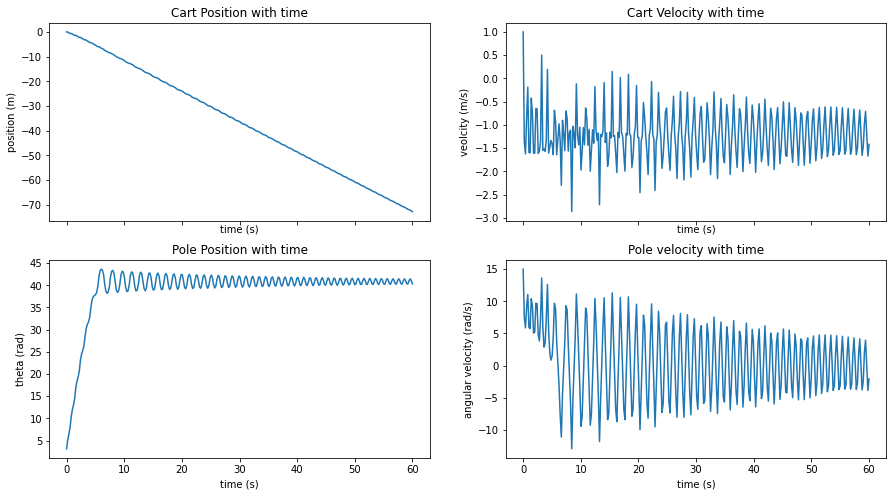

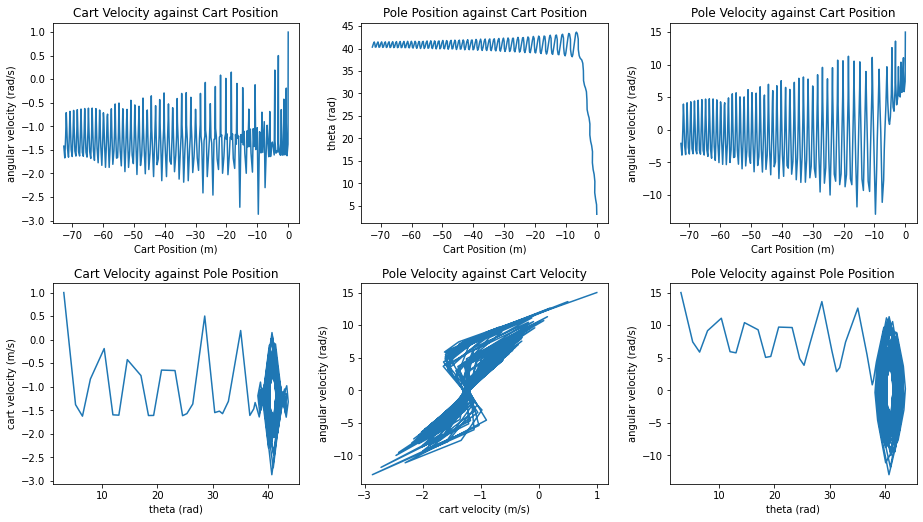

In [8]:
states = run(init_state,300)
plot_states(states)

### Changes of state

You know from 3F2 that a simple linear controller works for this system, as long as you know where the stationary point is, and have access to the equations of motion so that you can linearise them. But in general, we do not know the equations behind the evolution of a physical system, and so we will take a different approach. What do have are _observations_ of the time evolution of the system. So we will use the simulations like the ones you did above to gather data about the system, and develop a _model_ for this time evolution. 


We will want to build a _model_ for the time evolution of the system. The model is a function $f(X)$ that takes the current state of the system, and maps it onto a new state, which is its prediction for the state at a later time. Let the state of the system be described by a vector X, given by

$$
X = [x, \dot x, \theta, \dot \theta]
$$

Given the current state $X$, let us call $Y$ the state of the system after a single call to the `PerformAction` function (with 0.0 as the force argument, or no argument, which is equivalent). 

#### Task 1.2

To investigate and visualise the functional relationship between $X$ and $Y$, initialise the system using a random value for all state variables, and then scan through one of the state variables in a suitable range (don't forget to reset all the state variables after each call to `PerformAction`), and plot $Y$ as a function of your scan. 

In [9]:
def get_init_state(ranges = [(-100, 100),(-10, 10),(-p, p),(-15, 15)]):
    rng = np.random.default_rng()
    x = rng.uniform(ranges[0][0], ranges[0][1])
    xdot = rng.uniform(ranges[1][0], ranges[1][1])
    theta = rng.uniform(ranges[2][0], ranges[2][1])
    thetadot = rng.uniform(ranges[3][0], ranges[3][1])
    return np.array([x, xdot, theta, thetadot])

In [10]:
def sweep(state_var):
    if state_var not in range(4):
        print("state_var must be in [0,1,2,3]")
        raise ValueError 
    n = 1000
    state = get_init_state()
    ranges = [(-100, 100),(-10, 10),(-p, p),(-15, 15)]
    lower = ranges[state_var][0]
    upper = ranges[state_var][1]
    x = np.linspace(lower, upper, n)
    y = []
    for i in range(len(x)):
        state[state_var] =  x[i]
        cp.setState(state)
        cp.performAction()
        new_state = cp.getState()
        y.append(new_state)
    return [x,np.array(y)]

In [11]:
def plot_sweep(x,y,var):
    
    if var == 0:
        xlabel = 'Cart Position (m)'
        title = 'Sweep Cart Position between (-100, 100)'
    elif var == 1:
        xlabel = 'Cart Velocity (m/s)'
        title = 'Sweep Cart Velocity between (-10, 10)'
    elif var == 2:
        xlabel = 'Pole Position (rad)'
        title = 'Sweep Pole Position between (-$\pi$,$\pi$)'
    elif var == 3:
        xlabel = 'Pole Velocity (rad/s)'
        title = 'Sweep Pole Velocity between (-15, 15)'
    else:
        print('var must be in [0,1,2,3]')
        raise ValueError

    y1,y2,y3,y4 = y[:,0],y[:,1],y[:,2],y[:,3]

    fig, axs = plt.subplots(2, 2, sharex='all')
    
    fig.suptitle(f'{title}', y=0.93)
    axs[0,0].plot(x,y1)
    axs[0,0].set_title('$x$')
    axs[0,0].set_xlabel(f'{xlabel}')
    axs[0,0].set_ylabel('New Cart Position (m)')
    axs[0,1].plot(x,y2)
    axs[0,1].set_title('$\dot{x}$')
    axs[0,1].set_xlabel(f'{xlabel}')
    axs[0,1].set_ylabel('New Cart Velocity (m/s)')
    axs[1,0].plot(x,y3)
    axs[1,0].set_title(r'$\theta$')
    axs[1,0].set_xlabel(f'{xlabel}')
    axs[1,0].set_ylabel('New Pole Position (rad)')
    axs[1,1].plot(x,y4)
    axs[1,1].set_title(r'$\dot{\theta}$')
    axs[1,1].set_xlabel(f'{xlabel}')
    axs[1,1].set_ylabel('New Pole Velocity (rad/s)')
    
    plt.show()

In [12]:
x1,y1 = sweep(0)
x2,y2 = sweep(1)
x3,y3 = sweep(2)
x4,y4 = sweep(3)

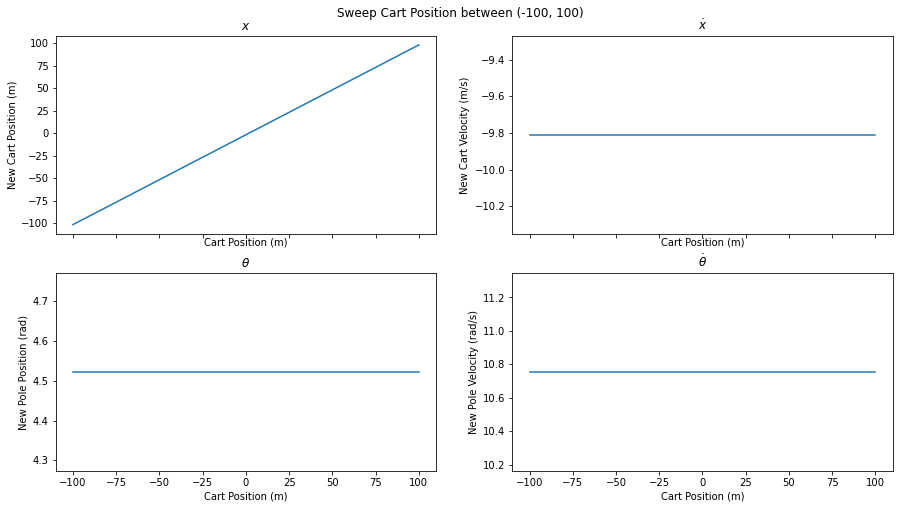

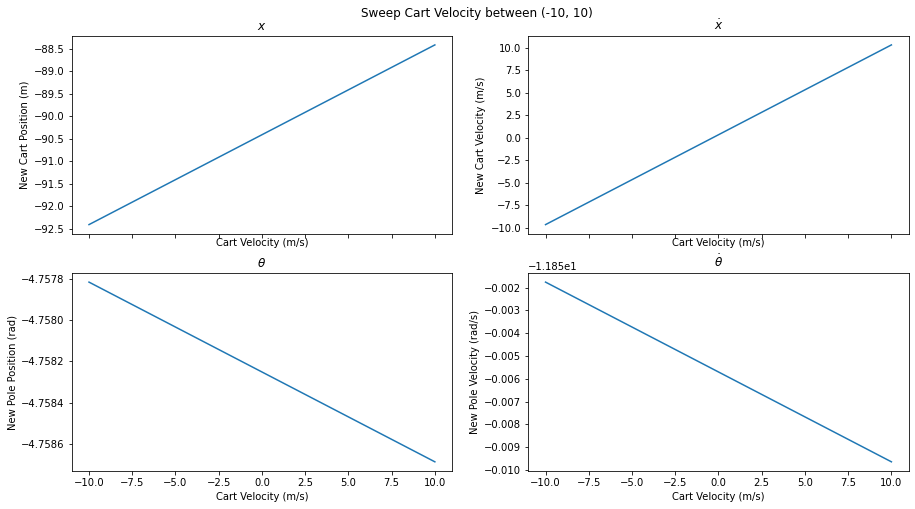

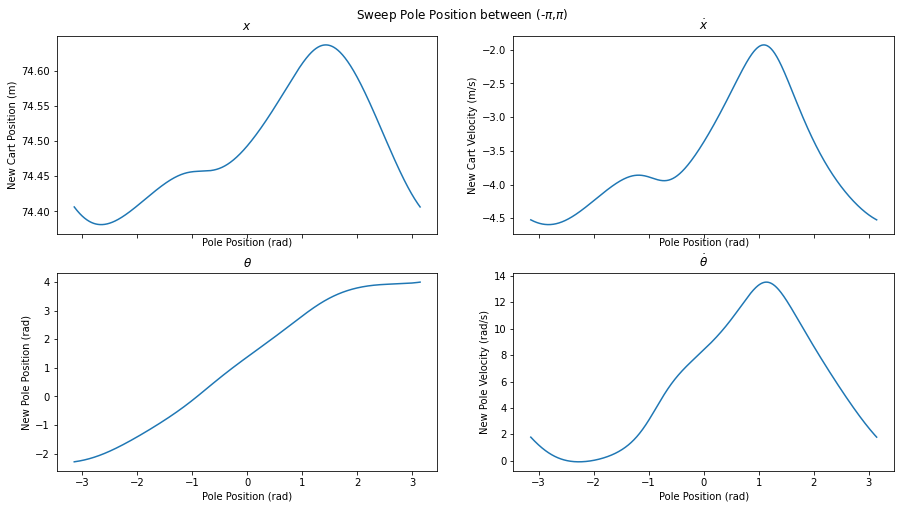

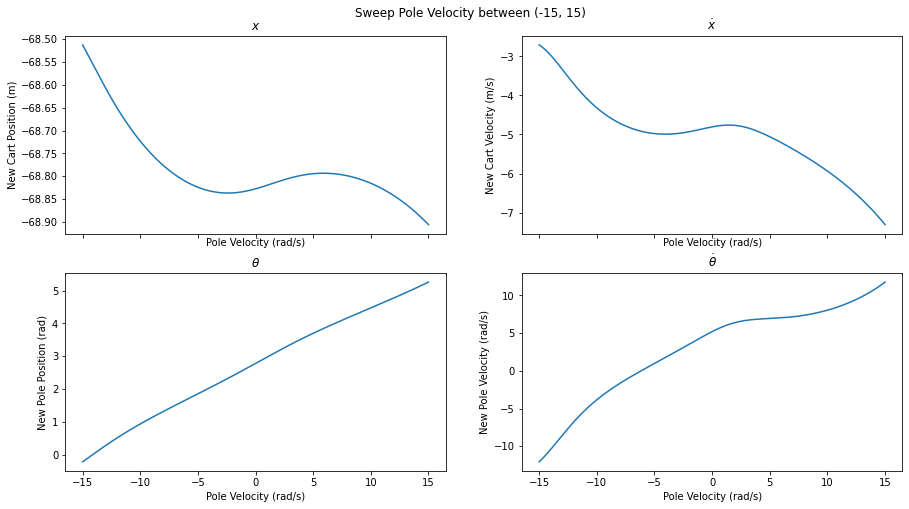

In [13]:
plot_sweep(x1,y1,0)
plot_sweep(x2,y2,1)
plot_sweep(x3,y3,2)
plot_sweep(x4,y4,3)

You will observe that the relationship between $X$ and $Y$ as defined above is nearly linear, which is not surprising because the change in one step is small.

We can take account of this and model the _change_ in state vector, rather than taking the new state vector itself as the target of our model. So we define the new target for the modelling as $Y\equiv X(T)-X(0)$, where $X(t)$ represents the time evolution of the state under the dynamics, and T corresponds to a single call to `PerformAction`. Note that in principle we could model changes corresponding arbitrary time shifts, rather than a single call to `PerformAction`, but the longer the time shift, the more complex the model would have to be. 

Explore this new functional relationship again (i) using scans of single variables, and (ii) contour plots where you take slices of the data in two of the variables while you keep the other two variables fixed (the `tricontourf` function of `matplotlib` is very useful). One of the variables has no effect on the next step - which one? 

In [14]:
def sweep_change(state_var):
    if state_var not in range(4):
        print("state_var must be in [0,1,2,3]")
        raise ValueError 
    n = 1000
    state = get_init_state()
    print(state)
    ranges = [(-100, 100),(-10, 10),(-p, p),(-15, 15)]
    lower = ranges[state_var][0]
    upper = ranges[state_var][1]
    x = np.linspace(lower, upper, n)
    y = []
    for i in range(len(x)):
        state[state_var] =  x[i]
        cp.setState(state)
        cp.performAction()
        new_state = cp.getState()
        change = new_state - state
        y.append(change)
    return [x,np.array(y)]

In [15]:
def plot_sweep_change(x,y,var):
    
    if var == 0:
        xlabel = 'Cart Position (m)'
        title = 'Sweep Cart Position between (-100, 100)'
    elif var == 1:
        xlabel = 'Cart Velocity (m/s)'
        title = 'Sweep Cart Velocity between (-10, 10)'
    elif var == 2:
        xlabel = 'Pole Position (rad)'
        title = 'Sweep Pole Position between (-$\pi$,$\pi$)'
    elif var == 3:
        xlabel = 'Pole Velocity (rad/s)'
        title = 'Sweep Pole Velocity between (-15, 15)'
    else:
        print('var must be in [0,1,2,3]')
        raise ValueError

    y1,y2,y3,y4 = y[:,0],y[:,1],y[:,2],y[:,3]

    fig, axs = plt.subplots(2, 2, sharex='all')
    
    fig.suptitle(f'{title}', y=0.93)
    axs[0,0].plot(x,y1)
    axs[0,0].set_title('$x$')
    axs[0,0].set_xlabel(f'{xlabel}')
    axs[0,0].set_ylabel('Change in Cart Position (m)')
    axs[0,1].plot(x,y2)
    axs[0,1].set_title('$\dot{x}$')
    axs[0,1].set_xlabel(f'{xlabel}')
    axs[0,1].set_ylabel('Change in Cart Velocity (m/s)')
    axs[1,0].plot(x,y3)
    axs[1,0].set_title(r'$\theta$')
    axs[1,0].set_xlabel(f'{xlabel}')
    axs[1,0].set_ylabel('Change in Pole Position (rad)')
    axs[1,1].plot(x,y4)
    axs[1,1].set_title(r'$\dot{\theta}$')
    axs[1,1].set_xlabel(f'{xlabel}')
    axs[1,1].set_ylabel('Change in Pole Velocity (rad/s)')
    
    plt.show()

In [16]:
x1,y1 = sweep_change(0)
x2,y2 = sweep_change(1)
x3,y3 = sweep_change(2)
x4,y4 = sweep_change(3)

[47.03894133  9.45803852 -2.61683011  4.94931809]
[84.12537747 -5.73576688 -2.54994938  4.90082993]
[16.61207473 -8.20288198 -2.87630394 13.03179746]
[-30.7801898   -0.91430737   2.36622828   0.98033901]


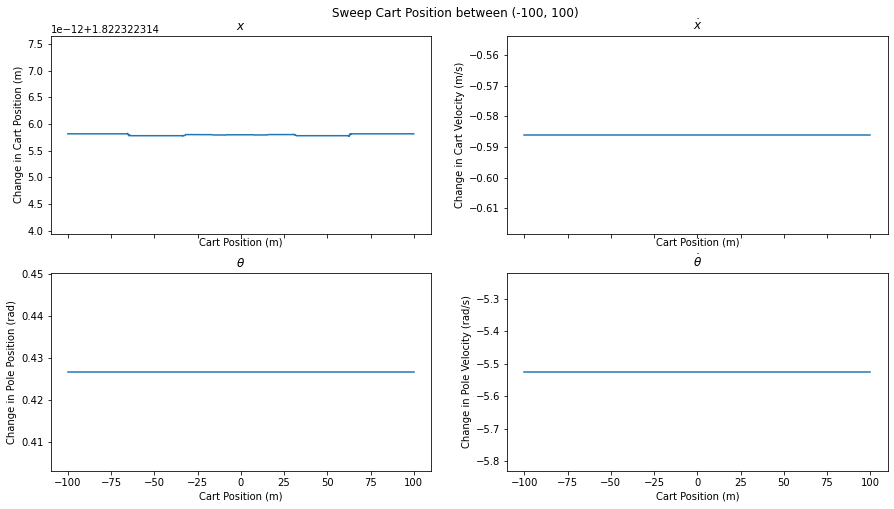

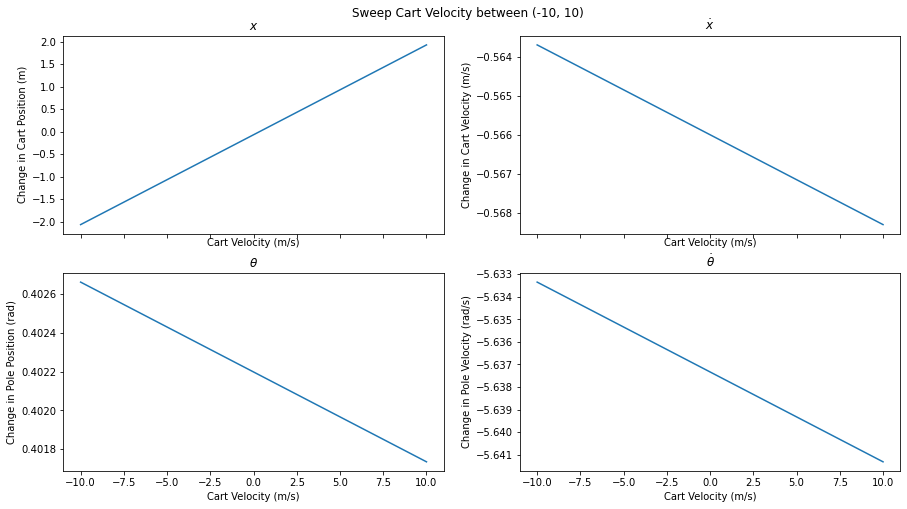

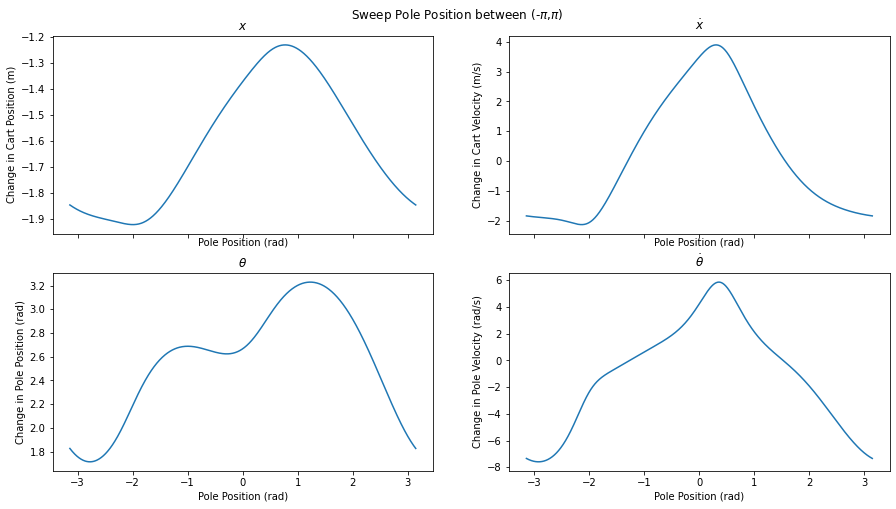

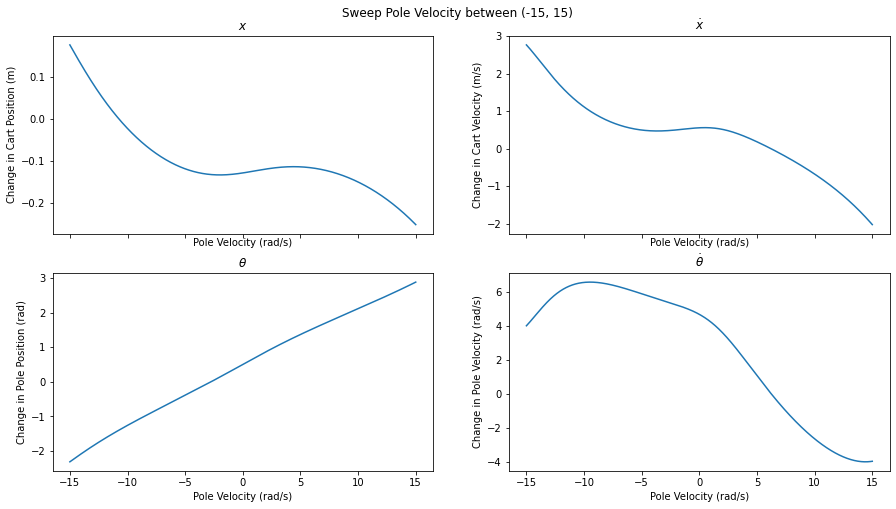

In [17]:
plot_sweep_change(x1,y1,0)
plot_sweep_change(x2,y2,1)
plot_sweep_change(x3,y3,2)
plot_sweep_change(x4,y4,3)

In [18]:
def state_slice(var1,var2,n):
    if var1 == var2:
        print("var1 and var2 must be different")
        raise ValueError
    if var1 not in range(4) or var2 not in range(4):
        print("var1 and var2 must be in [0,1,2,3]")
        raise ValueError
    state = get_init_state()
    ranges = [(-100, 100),(-10, 10),(-p, p),(-15, 15)]
    low1 = ranges[var1][0]
    up1 = ranges[var1][1]
    low2 = ranges[var2][0]
    up2 = ranges[var2][1]
    x1 = np.linspace(low1, up1, n)
    x2 = np.linspace(low2, up2, n)
    z = []
    for i in range(n):
        z_j = []
        for j in range(n):
            state[var1] = x1[i]
            state[var2] = x2[j]
            cp.setState(state)
            cp.performAction()
            new_state = cp.getState()
            change = new_state - state
            z_j.append(change)
        z.append(z_j)
    return [x1,x2,np.array(z)]

In [19]:
def plot_contour(var1,var2,n=30):
    
    labels = ['Cart Position','Cart Velocity','Pole Position','Pole Velocity']
    units = ['m','m/s','rad','rad/s']
    
    label1,label2 = labels[var1],labels[var2]
    unit1,unit2 = units[var1],units[var2]
    
    x1,x2,z = state_slice(var1,var2,n)
    print(z.shape)
    z1,z2,z3,z4 = z[:,:,0].T,z[:,:,1].T,z[:,:,2].T,z[:,:,3].T
    
    fig, axs = plt.subplots(2, 2)
    
    fig.suptitle(f'Contour plot for {label1} against {label2}', y=0.97)
    cf1 = axs[0,0].contourf(x1,x2,z1)
    axs[0,0].set_title('Contours for x')
    axs[0,0].set_xlabel(f'{label1} ({unit1})')
    axs[0,0].set_ylabel(f'{label2} ({unit2})')
    fig.colorbar(cf1, ax=axs[0,0])
    cf2 = axs[0,1].contourf(x1,x2,z2)
    axs[0,1].set_title('Contours for $\dot{x}$')
    axs[0,1].set_xlabel(f'{label1} ({unit1})')
    axs[0,1].set_ylabel(f'{label2} ({unit2})')
    fig.colorbar(cf2, ax=axs[0,1])
    cf3 = axs[1,0].contourf(x1,x2,z3)
    axs[1,0].set_title(r'Contours for $\theta$')
    axs[1,0].set_xlabel(f'{label1} ({unit1})')
    axs[1,0].set_ylabel(f'{label2} ({unit2})')
    fig.colorbar(cf3, ax=axs[1,0])
    cf4 = axs[1,1].contourf(x1,x2,z4)
    axs[1,1].set_title(r'Contours for $\dot{\theta}$')
    axs[1,1].set_xlabel(f'{label1} ({unit1})')
    axs[1,1].set_ylabel(f'{label2} ({unit2})')
    fig.colorbar(cf4, ax=axs[1,1])
    
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)
    
    plt.show()

(30, 30, 4)


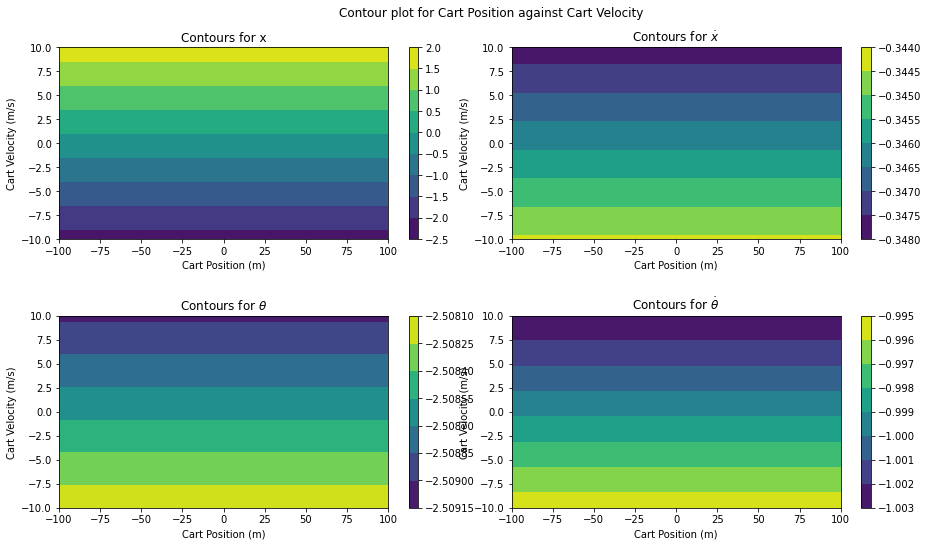

(30, 30, 4)


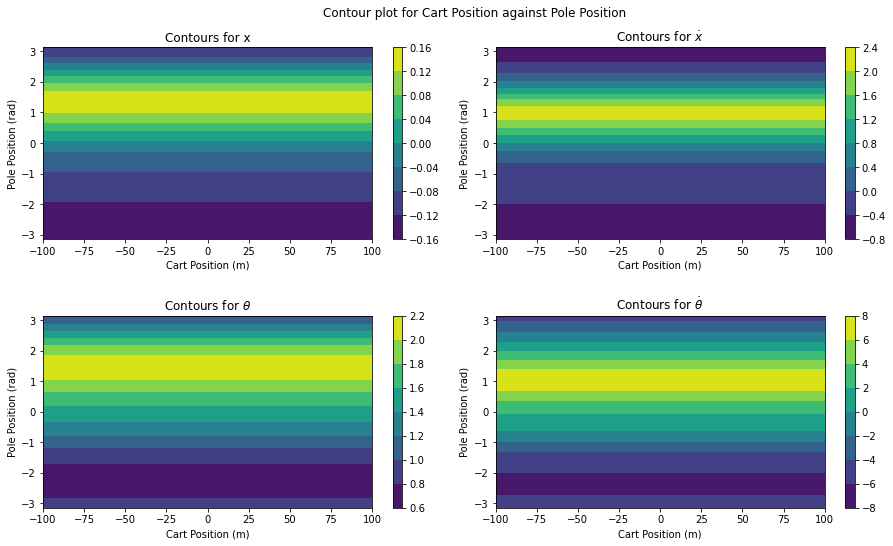

(30, 30, 4)


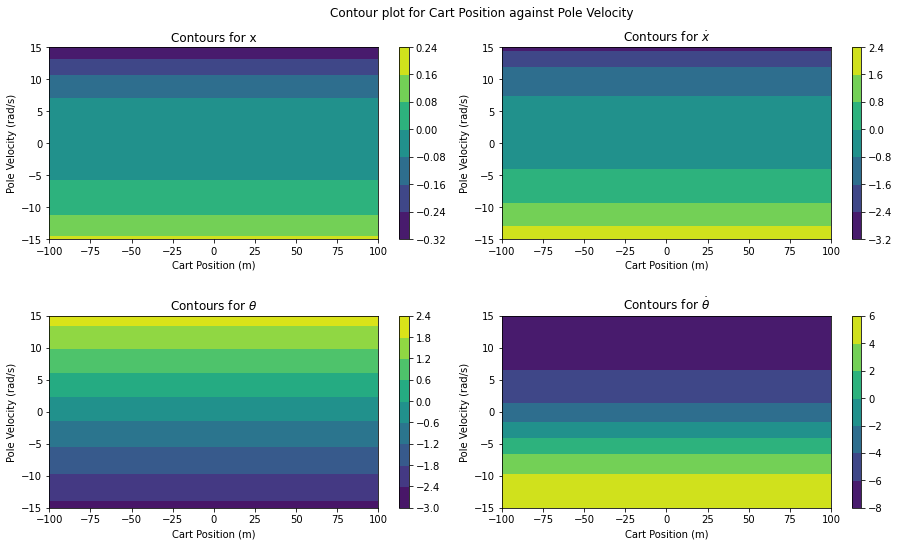

(30, 30, 4)


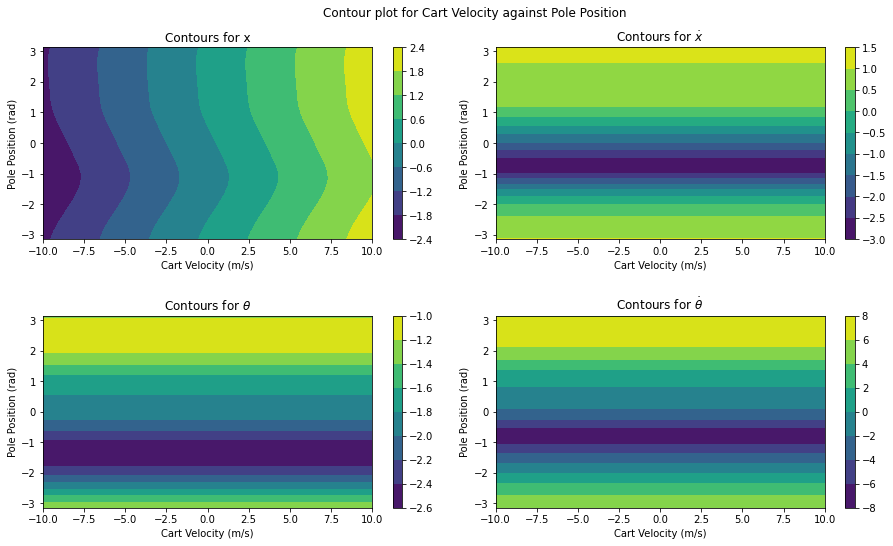

(30, 30, 4)


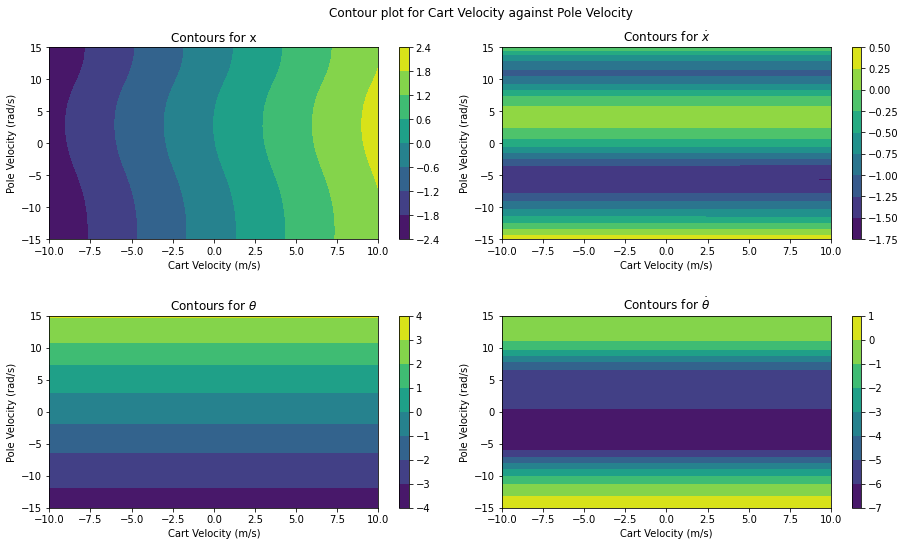

(30, 30, 4)


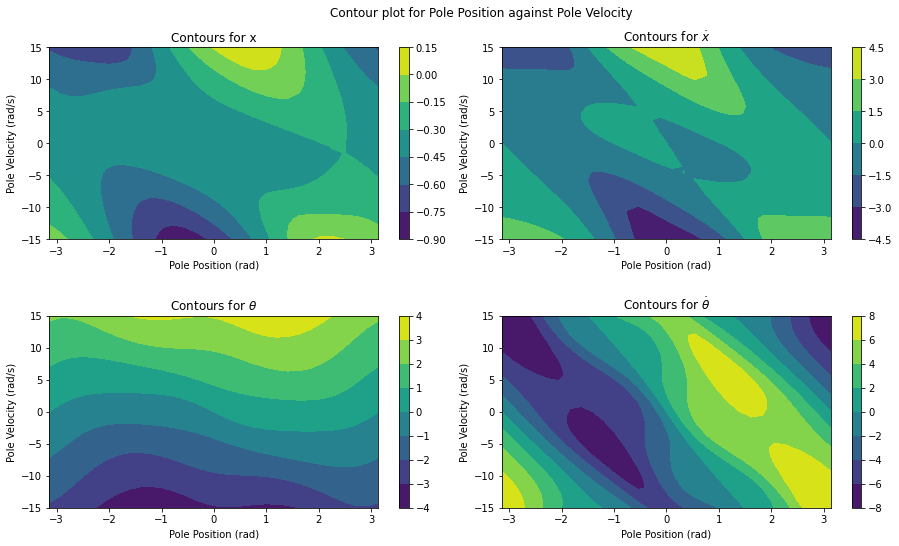

In [20]:
plot_contour(0,1)
plot_contour(0,2)
plot_contour(0,3)
plot_contour(1,2)
plot_contour(1,3)
plot_contour(2,3)

### Linear model


The simplest model is a linear one, where the target $Y$ is assumed to be linear function of the current state $X$,
$$
f(X) = {\bf C} X
$$

where ${\bf C}$ is a $4\times 4$ matrix of coefficients. 

#### Task 1.3

By initialising the simulator in a completely random state (using suitable ranges) and running it for _one_ step, gather
data in the form of pairs of state vectors (X, Y), where X represents a state of the system at step $n$, so $X\equiv X(n)$
and Y represent the change in state after a single call to `performAction` (with zero force), so $Y\equiv X(n+1)-X(n)$. 
Start with 500 data points. 

In [21]:
cp.delta_time = 0.05

In [22]:
def generate_dataset(num_datapoints):
    if num_datapoints != int(num_datapoints):
        print("number of datapoints must be an integer")
        raise ValueError
    data = []
    for i in range(num_datapoints):
        state = get_init_state()
        cp.setState(state)
        cp.performAction()
        new_state = cp.getState()
        change = new_state - state
        data.append([state, change])
    return np.array(data)

In [23]:
data = generate_dataset(5000)

In [24]:
X = data[:,0,:]
Y = data[:,1,:]

Using your data set, do linear regression to find the optimal coefficient matrix. Test your predictions against the data. One way to plot the results is to put the input state variable on the horizontal axis and on the vertical axis put the predicted state variable (i.e. what should be the "next step") and the real next step. Another way is to put the target data (i.e. the real "next step") on the horizontal axis and the predicted "next step" on the vertical axis. In this latter plot, a perfect prediction would correspond to a perfect straight line. You should also repeat the "scans" from the previous task, and plot simultaneously the real change in state with your predicted change in state as a function of your scan. Which variables are predicted well by the linear model and which ones are not? Why ? 

In [25]:
def get_coef_matrix(dataset):
    X = dataset[:,0,:]
    Y = dataset[:,1,:]
    C = np.array(np.linalg.lstsq(X, Y, rcond = None))
    return C

In [26]:
C, residual, rank, sing_vals = get_coef_matrix(data)
Y_pred = np.dot(X, C)
print(C.T)

[[ 4.34243104e-07  4.99762067e-02  4.42568279e-03  1.05856165e-04]
 [ 4.29570345e-05 -9.50830491e-04  1.64474964e-01  5.50678198e-03]
 [-8.12213162e-06  3.60548198e-05  1.61347232e-02  5.00508574e-02]
 [-2.47256620e-04  1.53454420e-03  6.05843241e-01  3.21441367e-03]]


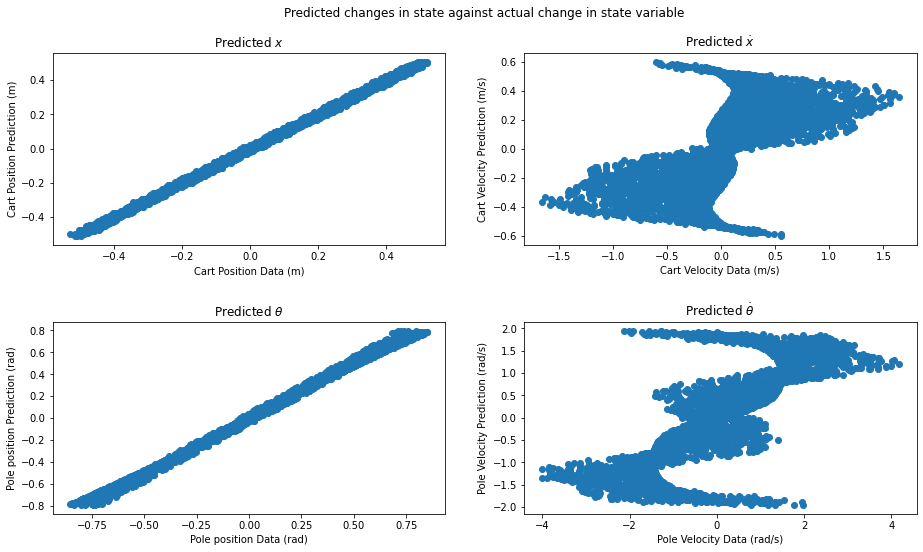

In [27]:
#def plot_predictions(X,Y,Y_pred,var,method=1):

x1,y1 = X[:,0], Y[:,0]
y1_pred = Y_pred[:,0]
x2,y2 = X[:,1], Y[:,1]
y2_pred = Y_pred[:,1]
x3,y3 = X[:,2], Y[:,2]
y3_pred = Y_pred[:,2]
x4,y4 = X[:,3], Y[:,3]
y4_pred = Y_pred[:,3]

#xs = [x1,x2,x3,x4]
#ys = [y1,y2,y3,y4]
#labels = ['Cart Position','Cart Velocity','Pole Position','Pole Velocity']
#units = ['m','m/s','rad','rad/s']

#x = xs[var]
#y = ys[var]
#label = labels[var]
#unit = units[var]

method = 1

fig, axs = plt.subplots(2, 2)

if method == 0:
    fig.suptitle('Data and Predictions for Y against input state variable')
    axs[0,0].scatter(x1,y1,label='Data')
    axs[0,0].scatter(x1,y1_pred,label='Prediction')
    axs[0,0].set_title("Prediction vs Data for x")
    axs[0,0].set_xlabel("Cart Position (m)")
    axs[0,0].set_ylabel("Next Cart Position (m)")
    axs[0,0].legend()
    axs[0,1].scatter(x2,y2,label='Data')
    axs[0,1].scatter(x2,y2_pred,label='Prediction')
    axs[0,1].set_title("Prediction vs Data for $\dot{x}$")
    axs[0,1].set_xlabel("Cart Velocity (m/s)")
    axs[0,1].set_ylabel("Next Cart Velocity (m/s)")
    axs[0,1].legend()
    axs[1,0].scatter(x3,y3,label='Data')
    axs[1,0].scatter(x3,y3_pred,label='Prediction')
    axs[1,0].set_title(r"Prediction vs Data for $\theta$")
    axs[1,0].set_xlabel("Pole Position (rad)")
    axs[1,0].set_ylabel("Next Pole Position (rad)")
    axs[1,0].legend()
    axs[1,1].scatter(x4,y4,label='Data')
    axs[1,1].scatter(x4,y4_pred,label='Prediction')
    axs[1,1].set_title(r"Prediction vs Data for $\dot{\theta}$")
    axs[1,1].set_xlabel("Pole Velocity (rad/s)")
    axs[1,1].set_ylabel("Next Pole Velocity (rad/s)")
    axs[1,1].legend()
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)
    plt.show()
elif method ==1:
    fig.suptitle(f'Predicted changes in state against actual change in state variable')
    axs[0,0].scatter(y1,y1_pred)
    axs[0,0].set_title("Predicted $x$")
    axs[0,0].set_xlabel("Cart Position Data (m)")
    axs[0,0].set_ylabel("Cart Position Prediction (m)")
    axs[0,1].scatter(y2,y2_pred)
    axs[0,1].set_title("Predicted $\dot{x}$")
    axs[0,1].set_xlabel("Cart Velocity Data (m/s)")
    axs[0,1].set_ylabel("Cart Velocity Prediction (m/s)")
    axs[1,0].scatter(y3,y3_pred)
    axs[1,0].set_title(r"Predicted $\theta$")
    axs[1,0].set_xlabel("Pole position Data (rad)")
    axs[1,0].set_ylabel("Pole position Prediction (rad)")
    axs[1,1].scatter(y4,y4_pred)
    axs[1,1].set_title(r"Predicted $\dot{\theta}$")
    axs[1,1].set_xlabel("Pole Velocity Data (rad/s)")
    axs[1,1].set_ylabel("Pole Velocity Prediction (rad/s)")
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
    plt.show()

In [28]:
#plot_predictions(X,Y,Y_pred,0)
#plot_predictions(X,Y,Y_pred,1)
#plot_predictions(X,Y,Y_pred,2)
#plot_predictions(X,Y,Y_pred,3)

In [29]:
#plot_predictions(X,Y,Y_pred,0,0)
#plot_predictions(X,Y,Y_pred,1,0)
#plot_predictions(X,Y,Y_pred,2,0)
#plot_predictions(X,Y,Y_pred,3,0)

In [157]:
def sweep_pred(state_var, C):
    if state_var not in range(4):
        print("state_var must be in [0,1,2,3]")
        raise ValueError 
    n = 1000
    state = [0,3,0,5]
    ranges = [(-100, 100),(-10, 10),(-p, p),(-15, 15)]
    lower = ranges[state_var][0]
    upper = ranges[state_var][1]
    x = np.linspace(lower, upper, n)
    y = []
    y_pred = []
    for i in range(len(x)):
        state[state_var] =  x[i]
        cp.setState(state)
        cp.performAction()
        new_state = cp.getState()
        y.append(new_state[state_var] - state[state_var])
        pred_state = np.dot(C.T, state)
        y_pred.append(pred_state[state_var])
    return [x,y,y_pred]

In [158]:
x1,y1,y1_pred = sweep_pred(0,C)
x2,y2,y2_pred = sweep_pred(1,C)
x3,y3,y3_pred = sweep_pred(2,C)
x4,y4,y4_pred = sweep_pred(3,C)

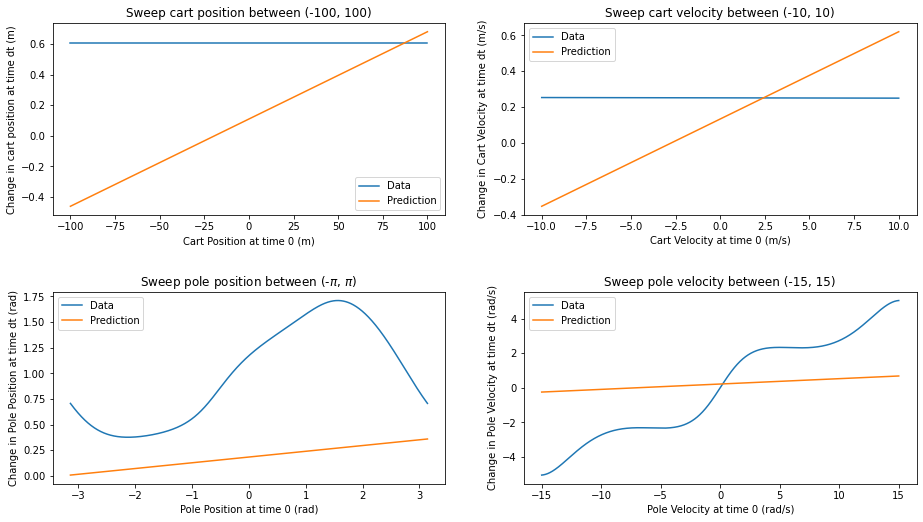

In [159]:
fig, axs = plt.subplots(2, 2)

axs[0,0].plot(x1,y1,label='Data')
axs[0,0].plot(x1,y1_pred,label='Prediction')
axs[0,0].set_title('Sweep cart position between (-100, 100)')
axs[0,0].set_xlabel('Cart Position at time 0 (m)')
axs[0,0].set_ylabel('Change in cart position at time dt (m)')
axs[0,0].legend()
axs[0,1].plot(x2,y2,label='Data')
axs[0,1].plot(x2,y2_pred,label='Prediction')
axs[0,1].set_title('Sweep cart velocity between (-10, 10)')
axs[0,1].set_xlabel('Cart Velocity at time 0 (m/s)')
axs[0,1].set_ylabel('Change in Cart Velocity at time dt (m/s)')
axs[0,1].legend()
axs[1,0].plot(x3,y3,label='Data')
axs[1,0].plot(x3,y3_pred,label='Prediction')
axs[1,0].set_title('Sweep pole position between (-$\pi$, $\pi$)')
axs[1,0].set_xlabel('Pole Position at time 0 (rad)')
axs[1,0].set_ylabel('Change in Pole Position at time dt (rad)')
axs[1,0].legend()
axs[1,1].plot(x4,y4,label='Data')
axs[1,1].plot(x4,y4_pred,label='Prediction')
axs[1,1].set_title('Sweep pole velocity between (-15, 15)')
axs[1,1].set_xlabel('Pole Velocity at time 0 (rad/s)')
axs[1,1].set_ylabel('Change in Pole Velocity at time dt (rad/s)')
axs[1,1].legend()

plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)

plt.show()

#### Task 1.4

The true test of the model is not how it matches with the gathered data it was fit to, but whether it can predict the time evolution of the physical system. Iterate the model to predict the time evolution of the system, and compare using various initial conditions how accurate the predictions are with respect to the true dynamics started from the same initial conditions. (Note that the model is being used deterministically, with no noise added)

Since your models above predict the _change_ in the state variable, the iterated time evolution is
$$
X_{n+1} \leftarrow X_n + f(X_n)
$$

Plot the true time evolution of the system as well as that of your fitted models for many cycles, and for different initial conditions, including ones where the pole makes a full circle. 

_Angle range_ If you leave the angle without remapping, your solution with the iterated model will diverge. Why is that? Ensure that you remap the angle during the above iterations. (Note how remapping is not needed in the true dynamics, since that is nonlinear, and the angle only appears inside trigonometric functions that are periodic anyway).

In [33]:
def remap(state):
    state[2] = remap_angle(state[2])
    return state

def test_linear_model(C, num_iterations = 1000, init_state = get_init_state()):
    dt = cp.delta_time
    t = np.linspace(0,dt*num_iterations, num_iterations)
    init_state = remap(init_state)
    x = [init_state]
    x_pred = [init_state]
    cp.setState(init_state)
    cp.remap_angle()
    for i in range(1,num_iterations):
        pred_state = x_pred[-1] + np.dot(C.T, x_pred[-1])
        pred_state = remap(pred_state)
        x_pred.append(pred_state)
        cp.performAction()
        cp.remap_angle()
        next_state = cp.getState()
        x.append(next_state)
    return t, x, x_pred

In [34]:
evolution = test_linear_model(C,num_iterations=200,init_state = [0,0,-3.14159,0])
t = np.array(evolution[0])
x = np.array(evolution[1])
x_pred = np.array(evolution[2])

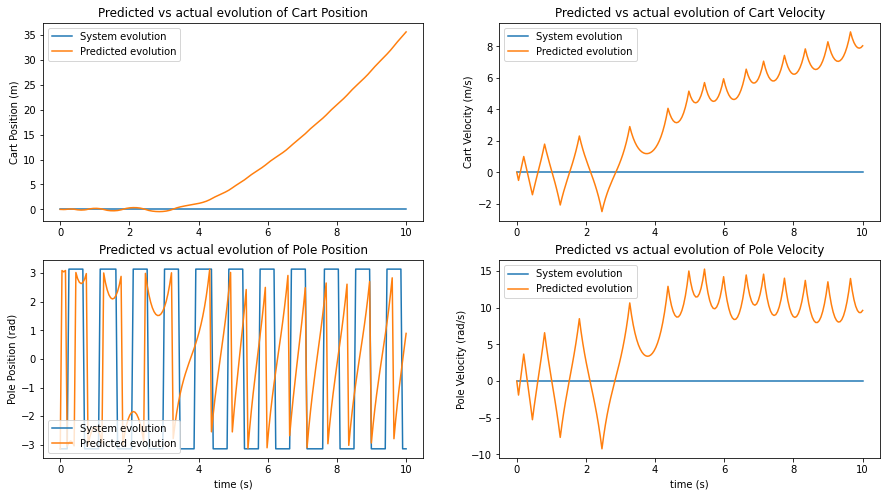

In [35]:
x1, x2, x3, x4 = x[:,0],x[:,1],x[:,2],x[:,3]
x1_pred,x2_pred,x3_pred,x4_pred = x_pred[:,0],x_pred[:,1],x_pred[:,2],x_pred[:,3]

fig, axs = plt.subplots(2, 2)

axs[0,0].plot(t,x1,label='System evolution')
axs[0,0].plot(t,x1_pred,label='Predicted evolution')
axs[0,0].set_title("Predicted vs actual evolution of Cart Position")
#axs[0,0].set_xlabel("time (s)")
axs[0,0].set_ylabel("Cart Position (m)")
axs[0,0].legend()

axs[0,1].plot(t,x2,label='System evolution')
axs[0,1].plot(t,x2_pred,label='Predicted evolution')
axs[0,1].set_title("Predicted vs actual evolution of Cart Velocity")
#axs[0,1].set_xlabel("time (s)")
axs[0,1].set_ylabel("Cart Velocity (m/s)")
axs[0,1].legend()

axs[1,0].plot(t,x3,label='System evolution')
axs[1,0].plot(t,x3_pred,label='Predicted evolution')
axs[1,0].set_title("Predicted vs actual evolution of Pole Position")
axs[1,0].set_xlabel("time (s)")
axs[1,0].set_ylabel("Pole Position (rad)")
axs[1,0].legend(loc='lower left')

axs[1,1].plot(t,x4,label='System evolution')
axs[1,1].plot(t,x4_pred,label='Predicted evolution')
axs[1,1].set_title("Predicted vs actual evolution of Pole Velocity")
axs[1,1].set_xlabel("time (s)")
axs[1,1].set_ylabel("Pole Velocity (rad/s)")
axs[1,1].legend()
plt.show()

## Week 2

### Nonlinear model
As you observed above, the linear model is not particularly good. In order to do better, we need nonlinear modelling. Next you are going to do build a nonlinear model using a linear regression with nonlinear basis functions. Given a data set of (X,Y) pairs, the model function is given by

$$
f(X) = \sum_i \alpha_i K(X, X_i)
$$

where the sum runs over the basis functions, $\alpha_i$ are the corresponding coefficients, and $K$ is a _kernel function_ that is used to define the nonlinear basis. The kernel function takes two arguments, the first one $X$ is the state vector where you evaluate the basis function, and the second argument, $X_i$ is another state vector which we use to place the basis function somewhere in the state space. To make the basis functions relevant, we take the set of locations $\{X_i\}$ to be a subset of the gathered data points.  

If you place a basis functions on every location at which you have data, the functional form above is equivalent to 
the mean of a _Gaussian process_ with covariance given by the kernel _K_. This view of the regression problem is particularly helpful 
if the data is stochastic, i.e. it has some noise component which we can model. 

For the present problem, let us use a Gaussian kernel function,

$$
K(X,X') = e^{-\sum_j \frac{\left(X^{(j)}-X'^{(j)}\right)^2}{2\sigma_j^2}}
$$

Here $X^{(j)}$ refers to the $j$th component of the state vector. There is one caveat for using this kernel function in our
current situation: one of our state vector components, $\theta$ is periodic. It helps quite a bit if we introduce this
periodicity in our kernel function, and we can do that by using $\sin^2\left( (\theta - \theta')/2 \right)$ in place
of $\left(\theta -\theta' \right)^2$ in the part of the kernel function that corresponds to the angle variable. The parameters
$\sigma_j$ are _length scale_ hyperparameters of the model, and need to be known, guessed or fitted. 



If we have $N$ data locations (each is an (X,Y) pair but remember that here X is a vector and Y is a scalar), substituting this data into
the model functional form yields the following linear system

$$
K_{NN} \alpha_N = Y_N
$$

where the subscript $N$ was used to emphasize the size of the array rather than an index. The unknown coefficients are collected
into the vector $\alpha_N$, the elements of the matrix are given by the kernel function, 

$$
[K_{NN}]_{i,i'} = K(X_i,X_{i'})
$$

and $Y_N$ is a vector of the target function values. With Gaussian basis functions, the condition number of the matrix is enormous, and a direct solution of the above linear system would be
rather unstable. One way to get around this is to _regularise_ the linear system. Tikhonov regularisation is to modify it to 

$$
(K_{NN} + \lambda I) \alpha_N = Y_N
$$
with solution
$$
\alpha_N = [K_{NN} + \lambda I]^{-1} Y_N
$$

where $\lambda$ is a parameter. The smaller the values of $\lambda$, the closer is the fit to the data, but the more unstable
the linear system. Interestingly, this is also exactly the form of the (mean) solution in the Gaussian process regression problem of
inference in the presence of noisy input data, with the identification that $\lambda$ is the variance of the data noise. 

Suppose we collected $N$ pairs of $(X,Y)$ data pairs, and we choose a subset $M$ of the $X$ locations to serve as basis function centres.
The linear system is then not square:
$$
K_{NM} \alpha_M = Y_N
$$
where again the subscripts indicate dimensions, $K_{MN}$ is an $M \times N$ matrix with elements corresponding to the $M$ basis locations
and all the $N$ data point locations. We have fewer unknown coefficients than data points, so the problem is over-determined. 
The least squares solution would be
$$
\alpha_M = [K_{MN} K_{NM}]^{-1} K_{MN} Y_N
$$
i.e. using the pseudoinverse rather than the inverse. The matrix in square brackets will in general be uninvertible or very badly 
conditioned, so again we need to regularise. Interestingly, rather just adding a multiple of the identity matrix like in the
square case, we can look to Gaussian process inference for a better idea. It turns out that a _sparse Gaussian process_ precisely
corresponds to this case. There, the model is written as a conditional probability not on the original $N$ data values directly, but on the
unknown function values at the $M$ data locations that are chosen for the basis function centers. The vector of linear coefficients of
the fitted model are then given by 

$$
\alpha^{(j)}_M = \left(K_{MN}K_{NM} + \lambda K_{MM} \right)^{-1} K_{MN}  Y_N^{(j)}
$$

where $K_{MM}$ is an $M \times M$ matrix with elements that are given by the kernel function evaluated between the locations
selected as basis locations. The interpretation of this is that the least squares system is Tikhonov regularised but the regulariser
is evaluated in the kernel-norm, rather than the Euclidean norm. 


To apply all the above to the cartpole system, we have to create four separate models for the four components of
the state vector, these are indexed by $j$. In the absence of data noise to guide the selection of $\lambda$, you need to experiment
with different values (e.g. between 1E-6 and 1E-1, on a log scale). You will also need to select the length scale parameters $\sigma_j$ for each state variable. A good start is the standard deviation
of the state variable in your dataset. Note that in the Gaussian process inference view of this problem, these hyperparameters 
would be optimised by minimising the log-likelihood, feel free to research this and experiment with it if you have time. 

**Note: You should never use the `np.linalg.inv` function to invert the matrix when solving a linear system, because that can be
numerically unstable for such ill-conditioned matrices, but instead use `np.linalg.lstsq`, which solves equations of the
form $Ax=b$ directly in a least-squares sense.**

#### Task 2.1

Fit a model of the system using the data you gathered earlier. Your target function could be either again the change in
state after one step as before, or the _error of your linear model_ in the change in state. Verify using scatterplots that
the nonlinear model indeed fits the data. Study the convergence of the model (i.e. the systematic reduction in error) as a
function of increasing data amount, and the increasing number of basis functions (e.g. start with $M=10$ and increase by
factors of 2, select the data locations for the basis randomly from the data). Also plot 2D slices of your target function
and the fit, as well as do roll-outs to see how closely the iterated model matches the real dynamics for a wide range of
sensible initial conditions. How long does your model show reasonable agreement with the real dynamics? Quantify this in units of time
and also in the number of oscillation cycles. How does this correlate with the pointwise accuracy you measure on random test data? 

An alternative to random data locations is to use _quasirandom sequences_, these provide a set of locations in an arbitrary dimensional unit cube that are "nicely" spaced out for sampling, better than random draws. You can use the `sobol_seq` module to generate such locations (read the on-line example, but each new location is obtained with a call to the `vec, seed = sobol_seq.i4_sobol(4, seed)` function for 4 dimensions, with the seed provided by the previous call)

In [36]:
%pip install git+https://github.com/naught101/sobol_seq@v0.2.0#egg=sobol_seq

In [37]:
import sobol_seq

In [38]:
vec, seed = sobol_seq.i4_sobol(4, 1)
print(vec)
print(seed)

[0.5 0.5 0.5 0.5]
2


In [39]:
cp.delta_time = 0.2

In [579]:
def get_init_state2(ranges = [(-100, 100),(-10, 10),(-p, p),(-15, 15),(-30,30)]):
    rng = np.random.default_rng()
    x = rng.uniform(ranges[0][0], ranges[0][1])
    xdot = rng.uniform(ranges[1][0], ranges[1][1])
    theta = rng.uniform(ranges[2][0], ranges[2][1])
    thetadot = rng.uniform(ranges[3][0], ranges[3][1])
    force = rng.uniform(ranges[4][0], ranges[4][1])
    return np.array([x, xdot, theta, thetadot, force])

def generate_dataset2(num_datapoints, m, ranges=[(-10,10), (-5,5),(-p,p),(-10,10),(-30,30)], dim=4):
    if num_datapoints != int(num_datapoints):
        print("number of datapoints must be an integer")
        raise ValueError
    centres = get_basis_centres(m, dim, 30)
    X = np.zeros([num_datapoints,dim])
    Y = np.zeros([num_datapoints,4])
    for i, centre in enumerate(centres):
        state = centre
        cp.setState(state[:4])
        if dim == 4:
            cp.performAction()
        elif dim == 5:
            cp.performAction(state[4])
        new_state = cp.getState()
        change = new_state - state[:4]
        X[i], Y[i] = state, change
    for i in range(m, num_datapoints):
        if dim == 4:
            state = get_init_state(ranges[:4])
        elif dim == 5:
            state = get_init_state2(ranges)
        cp.setState(state[:4])
        if dim == 4:
            cp.performAction()
        elif dim == 5:
            cp.performAction(state[4])
        new_state = cp.getState()
        change = new_state - state[:4]
        X[i], Y[i] = state, change
    return X, Y, centres

def kernel(x, x_prime, sigmas):
    sum = 0
    for j in [0,1,3]:
        sum += (x[j] - x_prime[j])**2/(2*sigmas[j]**2)
    sum += np.sin((x[2] - x_prime[2])/2)**2/(2*sigmas[2]**2)
    return np.exp(-sum)

def kernel_no_exp(x, x_prime, sigmas):
    sum = 0
    for j in [0,1,3]:
        sum += (x[j] - x_prime[j])**2/(2*sigmas[j]**2)
    sum += np.sin((x[2] - x_prime[2])/2)**2/(2*sigmas[2]**2)
    return -sum

def kernel_no_exp2(x, x_prime, sigmas):
    sum = 0
    for j in [0,1,3,4]:
        sum += (x[j] - x_prime[j])**2/(2*sigmas[j]**2)
    sum += np.sin((x[2] - x_prime[2])/2)**2/(2*sigmas[2]**2)
    return -sum

def get_basis_centres(m, dim=4, f_range=None):
    seed = 1
    centres = np.zeros([m, dim])
    for i in range(m):
        vec, seed = sobol_seq.i4_sobol(dim, seed)
        centres[i] = vec
    centres[:,0] *= 10
    centres[:,1] *= 5
    centres[:,2] *= p
    centres[:,3] *= 10
    if dim == 5:
        centres[:,4] *= f_range
    return centres

def get_Knxm(X, basis_centres, sigmas):
    n = len(X)
    m = len(basis_centres)
    K = np.zeros([n,m])
    Km = np.zeros([m,m])
    if len(basis_centres[0]) == 4:
        for i in range(n):
            for j in range(m):
                K[i,j] = kernel_no_exp(X[i], basis_centres[j], sigmas)
        for i in range(m):
            for j in range(m):
                Km[i,j] = kernel_no_exp(basis_centres[i], basis_centres[j], sigmas)
    elif len(basis_centres[0]) == 5:
        for i in range(n):
            for j in range(m):
                K[i,j] = kernel_no_exp2(X[i], basis_centres[j], sigmas)
        for i in range(m):
            for j in range(m):
                Km[i,j] = kernel_no_exp2(basis_centres[i], basis_centres[j], sigmas)
    K = np.exp(K)
    Km = np.exp(Km)
    return K, Km

def get_sigmas(X):
    sigmas = np.zeros(4)
    for i in range(4):
        sigmas[i] = np.std(X[:,i])
    return sigmas

def sum_f2(x, basis_centres, sigmas, alphas):
    kernlist = np.array([kernel_no_exp(x, basis, sigmas) for basis in basis_centres])
    sumlist = alphas*np.exp(kernlist)
    return np.sum(sumlist)   

def f2(X, basis_centres, alphas, sigmas):
    n = len(X)
    Y_pred = []
    for j in range(4):
        y_pred = []
        for k in range(n):
            sum = sum_f2(X[k], basis_centres, sigmas, alphas[j])
            y_pred.append(sum)
        Y_pred.append(y_pred)
    return np.array(Y_pred).T 

def sum_f3(x, basis_centres, sigmas, alphas):
    kernlist = np.array([kernel_no_exp2(x, basis, sigmas) for basis in basis_centres])
    sumlist = alphas*np.exp(kernlist)
    return np.sum(sumlist)   

def f3(X, basis_centres, alphas, sigmas):
    n = len(X)
    Y_pred = []
    for j in range(4):
        y_pred = []
        for k in range(n):
            sum = sum_f3(X[k], basis_centres, sigmas, alphas[j])
            y_pred.append(sum)
        Y_pred.append(y_pred)
    return np.array(Y_pred).T 

def f(x, basis_centres, alphas, sigmas):
    Y_pred = []
    for j in range(4):
        y_pred = sum_f2(x, basis_centres, sigmas, alphas[j])
        Y_pred.append(y_pred)
    return np.array(Y_pred).T

def f_5(x, basis_centres, alphas, sigmas):
    Y_pred = []
    for j in range(4):
        y_pred = sum_f3(x, basis_centres, sigmas, alphas[j])
        Y_pred.append(y_pred)
    return np.array(Y_pred).T

def MSE(Y, Y_pred):
    y1,y2,y3,y4 = Y[:,0],Y[:,1],Y[:,2],Y[:,3]
    y1_pred,y2_pred,y3_pred,y4_pred = Y_pred[:,0],Y_pred[:,1],Y_pred[:,2],Y_pred[:,3]
    return np.array([np.mean((y1-y1_pred)**2),np.mean((y2-y2_pred)**2),np.mean((y3-y3_pred)**2),np.mean((y4-y4_pred)**2)])

In [499]:
X, Y, basis_centres = generate_dataset2(4000, 320)

In [503]:
# sigmas = get_sigmas(dataset)
sigmas = [10, 7, 2, 10]

In [504]:
K, Km = get_Knxm(X, basis_centres, sigmas) 

In [505]:
A = np.dot(K.T, K) + 1e-6*Km
B = np.array([np.dot(K.T, Y[:,i]) for i in range(4)])
B= B.T
alphas,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
alphas = alphas.T

In [506]:
Y_pred = f2(X, basis_centres, alphas, sigmas)

In [521]:
print(f(X[0],basis_centres,alphas,sigmas))
print(Y_pred[0])
print(f([-10,-10,2.35799737,-9.6046724],basis_centres,alphas,sigmas))

[0.65485606 1.22266245 1.7368733  5.7927876 ]
[0.65485606 1.22266245 1.7368733  5.7927876 ]
[-0.98950847  0.41736275 -0.76719818  3.03565271]


In [507]:
num_iterations = 50
init_state = [0,5,0,5]
dt = cp.delta_time
t = np.linspace(0,dt*num_iterations, num_iterations)
init_state = remap(init_state)
x = [init_state]
x_pred = [init_state]
cp.setState(init_state)
# cp.remap_angle()
for i in range(1,num_iterations):
    pred_state = x_pred[-1] + f(x_pred[-1],basis_centres,alphas,sigmas)
    # print(type(x_pred[-1]), x_pred[-1])
    # pred_state = remap(pred_state)
    x_pred.append(pred_state)
    cp.performAction()
    # cp.remap_angle()
    next_state = cp.getState()
    x.append(next_state)
x = np.array(x)
x_pred = np.array(x_pred)
x1, x2, x3, x4 = x[:,0],x[:,1],x[:,2],x[:,3]
x1_pred,x2_pred,x3_pred,x4_pred = x_pred[:,0],x_pred[:,1],x_pred[:,2],x_pred[:,3]

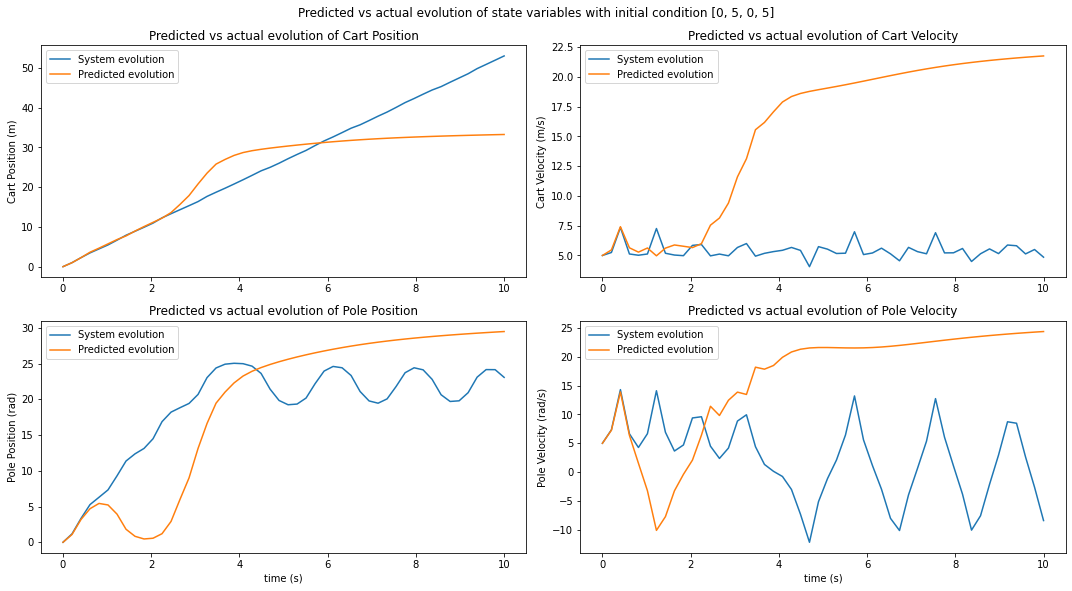

In [508]:
fig, axs = plt.subplots(2, 2)

fig.suptitle(f"Predicted vs actual evolution of state variables with initial condition {init_state}",y=1.02)

axs[0,0].plot(t,x1,label='System evolution')
axs[0,0].plot(t,x1_pred,label='Predicted evolution')
axs[0,0].set_title("Predicted vs actual evolution of Cart Position")
#axs[0,0].set_xlabel("time (s)")
axs[0,0].set_ylabel("Cart Position (m)")
axs[0,0].legend()

axs[0,1].plot(t,x2,label='System evolution')
axs[0,1].plot(t,x2_pred,label='Predicted evolution')
axs[0,1].set_title("Predicted vs actual evolution of Cart Velocity")
#axs[0,1].set_xlabel("time (s)")
axs[0,1].set_ylabel("Cart Velocity (m/s)")
axs[0,1].legend()

axs[1,0].plot(t,x3,label='System evolution')
axs[1,0].plot(t,x3_pred,label='Predicted evolution')
axs[1,0].set_title("Predicted vs actual evolution of Pole Position")
axs[1,0].set_xlabel("time (s)")
axs[1,0].set_ylabel("Pole Position (rad)")
axs[1,0].legend()

axs[1,1].plot(t,x4,label='System evolution')
axs[1,1].plot(t,x4_pred,label='Predicted evolution')
axs[1,1].set_title("Predicted vs actual evolution of Pole Velocity")
axs[1,1].set_xlabel("time (s)")
axs[1,1].set_ylabel("Pole Velocity (rad/s)")
axs[1,1].legend()
fig.tight_layout()
plt.show()

In [49]:
# train_MSE_list1 = []
# test_MSE_list1 = []
# N = 4000
# t = 1000
# for i,m in enumerate([10,20,40,80,160,320,640]):
#     X_train, Y_train, centres = generate_dataset2(N, m)
#     X_test, Y_test, _ = generate_dataset2(t, 0)
#     sigmas = [50, 10, 4, 15]
#     K, Km = get_Knxm(X_train, centres, sigmas)
#     lam = 1e-6
#     A = np.dot(K.T, K) + lam*Km
#     B = np.array([np.dot(K.T, Y_train[:,i]) for i in range(4)])
#     B = B.T
#     alphas,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
#     alphas = alphas.T
#     Y_pred_train = f2(X_train, centres, alphas, sigmas)
#     Y_pred_test = f2(X_test, centres, alphas, sigmas)
#     train_MSE_list1.append(MSE(Y_train, Y_pred_train))
#     test_MSE_list1.append(MSE(Y_test, Y_pred_test))

In [50]:
# train_MSE_list1 = np.array(train_MSE_list1)
# test_MSE_list1 = np.array(test_MSE_list1)
# y1_train_MSE1, y1_test_MSE1 = train_MSE_list1[:,0], test_MSE_list1[:,0]
# y2_train_MSE1, y2_test_MSE1 = train_MSE_list1[:,1], test_MSE_list1[:,1]
# y3_train_MSE1, y3_test_MSE1 = train_MSE_list1[:,2], test_MSE_list1[:,2]
# y4_train_MSE1, y4_test_MSE1 = train_MSE_list1[:,3], test_MSE_list1[:,3]

# m = [10,20,40,80,160,320,640]

# fig, axs = plt.subplots(2,2)

# fig.suptitle("Training and test mean-square errors for state variables, varying basis function set size", y = 1.01)

# axs[0,0].scatter(m, y1_train_MSE1, label='training error')
# axs[0,0].scatter(m, y1_test_MSE1, label='test error', marker = 'x')
# axs[0,0].set_title("$x$")
# axs[0,0].semilogx(basex=2)
# axs[0,0].legend()
# axs[0,1].scatter(m, y2_train_MSE1, label='training error')
# axs[0,1].scatter(m, y2_test_MSE1, label='test error', marker = 'x')
# axs[0,1].set_title("$\dot{x}$")
# axs[0,1].semilogx(basex=2)
# axs[0,1].legend()
# axs[1,0].scatter(m, y3_train_MSE1, label='training error')
# axs[1,0].scatter(m, y3_test_MSE1, label='test error', marker = 'x')
# axs[1,0].set_title(r"$\theta$")
# axs[1,0].set_xlabel("num. basis functions")
# axs[1,0].semilogx(basex=2)
# axs[1,0].legend()
# axs[1,1].scatter(m, y4_train_MSE1, label='training error')
# axs[1,1].scatter(m, y4_test_MSE1, label='test error', marker = 'x')
# axs[1,1].set_title(r"$\dot{\theta}$")
# axs[1,1].set_xlabel("num. basis functions")
# axs[1,1].semilogx(basex=2)
# axs[1,1].legend()
# plt.tight_layout()
# plt.show()

In [51]:
# train_MSE_list = []
# test_MSE_list = []
# for i,N in enumerate([500,1000,2000,4000,8000,16000]):
#     dataset = generate_dataset2(N)
#     train = dataset[:int(0.8*len(dataset))]
#     test = dataset[int(0.8*len(dataset)):]
#     X_train, Y_train = train[:,0,:], train[:,1,:]
#     X_test, Y_test = test[:,0,:], test[:,1,:]
#     sigmas = [50, 10, 4, 15]
#     K, Km, basis_centres = get_Knxm(train, 320, sigmas)
#     lam = 1e-6
#     A = np.dot(K.T, K) + lam*Km
#     B = np.array([np.dot(K.T, Y_train[:,i]) for i in range(4)])
#     B = B.T
#     alphas,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
#     alphas = alphas.T
#     Y_pred_train = f2(X_train, basis_centres, alphas, sigmas)
#     Y_pred_test = f2(X_test, basis_centres, alphas, sigmas)
#     train_MSE_list.append(MSE(Y_train, Y_pred_train))
#     test_MSE_list.append(MSE(Y_test, Y_pred_test))

# print(train_MSE_list)
# print(test_MSE_list)

In [52]:
# train_MSE_list = np.array(train_MSE_list)
# test_MSE_list = np.array(test_MSE_list)

In [53]:
# y1_train_MSE, y1_test_MSE = train_MSE_list[:,0], test_MSE_list[:,0]
# y2_train_MSE, y2_test_MSE = train_MSE_list[:,1], test_MSE_list[:,1]
# y3_train_MSE, y3_test_MSE = train_MSE_list[:,2], test_MSE_list[:,2]
# y4_train_MSE, y4_test_MSE = train_MSE_list[:,3], test_MSE_list[:,3]

In [54]:
# # N = np.log2(np.array([500,1000,2000,4000,8000,16000]))
# N = [500,1000,2000,4000,8000,16000]

# fig, axs = plt.subplots(2,2)

# fig.suptitle("Training and test mean-square errors for state variables")

# axs[0,0].scatter(N, y1_train_MSE, label='training error')
# axs[0,0].scatter(N, y1_test_MSE, label='test error')
# axs[0,0].set_title("$x$")
# axs[0,0].semilogx(basex=2)
# axs[0,0].legend()
# axs[0,1].scatter(N, y2_train_MSE, label='training error')
# axs[0,1].scatter(N, y2_test_MSE, label='test error')
# axs[0,1].set_title("$\dot{x}$")
# axs[0,1].semilogx(basex=2)
# axs[0,1].legend()
# axs[1,0].scatter(N, y3_train_MSE, label='training error')
# axs[1,0].scatter(N, y3_test_MSE, label='test error')
# axs[1,0].set_title(r"$\theta$")
# axs[1,0].set_xlabel("dataset size")
# axs[1,0].semilogx(basex=2)
# axs[1,0].legend()
# axs[1,1].scatter(N, y4_train_MSE, label='training error')
# axs[1,1].scatter(N, y4_test_MSE, label='test error')
# axs[1,1].set_title(r"$\dot{\theta}$")
# axs[1,1].set_xlabel("dataset size")
# axs[1,1].semilogx(basex=2)
# axs[1,1].legend()
# plt.show()

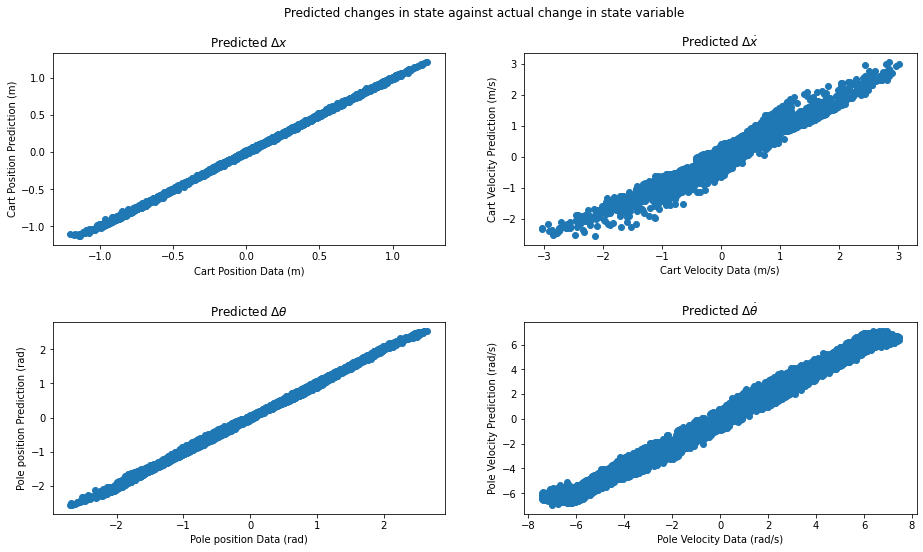

In [55]:
x1,y1 = X[:,0], Y[:,0]
y1_pred = Y_pred[:,0]
x2,y2 = X[:,1], Y[:,1]
y2_pred = Y_pred[:,1]
x3,y3 = X[:,2], Y[:,2]
y3_pred = Y_pred[:,2]
x4,y4 = X[:,3], Y[:,3]
y4_pred = Y_pred[:,3]

# print(type(y1), type(y1_pred))
# print(y1.shape, y1_pred.shape)


fig, axs = plt.subplots(2, 2)


fig.suptitle(f'Predicted changes in state against actual change in state variable')
axs[0,0].scatter(y1,y1_pred)
axs[0,0].set_title(r"Predicted $\Delta x$")
axs[0,0].set_xlabel("Cart Position Data (m)")
axs[0,0].set_ylabel("Cart Position Prediction (m)")
axs[0,1].scatter(y2,y2_pred)
axs[0,1].set_title(r"Predicted $\Delta\dot{x}$")
axs[0,1].set_xlabel("Cart Velocity Data (m/s)")
axs[0,1].set_ylabel("Cart Velocity Prediction (m/s)")
axs[1,0].scatter(y3,y3_pred)
axs[1,0].set_title(r"Predicted $\Delta\theta$")
axs[1,0].set_xlabel("Pole position Data (rad)")
axs[1,0].set_ylabel("Pole position Prediction (rad)")
axs[1,1].scatter(y4,y4_pred)
axs[1,1].set_title(r"Predicted $\Delta\dot{\theta}$")
axs[1,1].set_xlabel("Pole Velocity Data (rad/s)")
axs[1,1].set_ylabel("Pole Velocity Prediction (rad/s)")
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

In [56]:
print(MSE(Y,Y_pred))

[1.16116147e-04 4.44232164e-02 2.25034554e-03 2.25997002e-01]


In [57]:
print(MSE(Y, Y_pred))

[1.16116147e-04 4.44232164e-02 2.25034554e-03 2.25997002e-01]


slices of function against fit

In [523]:
def state_slice21(var1,var2,n,basis_centres,alphas,sigmas):
    ranges = [(-10, 10),(-10, 10),(-p, p),(-15, 15)]
    state = get_init_state(ranges)
    low1 = ranges[var1][0]
    up1 = ranges[var1][1]
    low2 = ranges[var2][0]
    up2 = ranges[var2][1]
    x1 = np.linspace(low1, up1, n)
    x2 = np.linspace(low2, up2, n)
    z = []
    for i in range(n):
        z_j = []
        for j in range(n):
            state[var1] = x1[i]
            state[var2] = x2[j]
            cp.setState(state)
            cp.performAction()
            new_state = cp.getState()
            change = new_state - state
            pred_change = f(state, basis_centres,alphas,sigmas)
            error = pred_change - change
            z_j.append(error)
        z.append(z_j)
    return [x1,x2,np.array(z)]

In [524]:
def plot_contour21(var1,var2,basis_centres,alphas,sigmas,n=30):
    
    labels = ['Cart Position','Cart Velocity','Pole Position','Pole Velocity']
    units = ['m','m/s','rad','rad/s']
    
    label1,label2 = labels[var1],labels[var2]
    unit1,unit2 = units[var1],units[var2]
    
    x1,x2,z = state_slice21(var1,var2,n,basis_centres,alphas,sigmas)
    print(z.shape)
    z1,z2,z3,z4 = z[:,:,0].T,z[:,:,1].T,z[:,:,2].T,z[:,:,3].T
    
    fig, axs = plt.subplots(2, 2)
    
    fig.suptitle(f'Contour plot for {label1} against {label2}, difference between predicted and actual change in state', y=0.97)
    cf1 = axs[0,0].contourf(x1,x2,z1)
    axs[0,0].set_title('Contours for x')
    axs[0,0].set_xlabel(f'{label1} ({unit1})')
    axs[0,0].set_ylabel(f'{label2} ({unit2})')
    fig.colorbar(cf1, ax=axs[0,0])
    cf2 = axs[0,1].contourf(x1,x2,z2)
    axs[0,1].set_title('Contours for $\dot{x}$')
    axs[0,1].set_xlabel(f'{label1} ({unit1})')
    axs[0,1].set_ylabel(f'{label2} ({unit2})')
    fig.colorbar(cf2, ax=axs[0,1])
    cf3 = axs[1,0].contourf(x1,x2,z3)
    axs[1,0].set_title(r'Contours for $\theta$')
    axs[1,0].set_xlabel(f'{label1} ({unit1})')
    axs[1,0].set_ylabel(f'{label2} ({unit2})')
    fig.colorbar(cf3, ax=axs[1,0])
    cf4 = axs[1,1].contourf(x1,x2,z4)
    axs[1,1].set_title(r'Contours for $\dot{\theta}$')
    axs[1,1].set_xlabel(f'{label1} ({unit1})')
    axs[1,1].set_ylabel(f'{label2} ({unit2})')
    fig.colorbar(cf4, ax=axs[1,1])
    
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)
    
    plt.show()

(30, 30, 4)


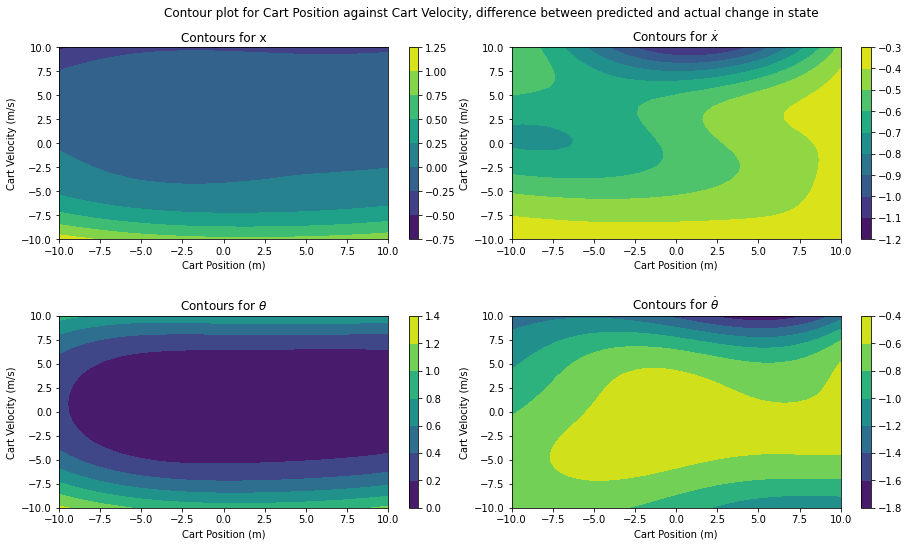

(30, 30, 4)


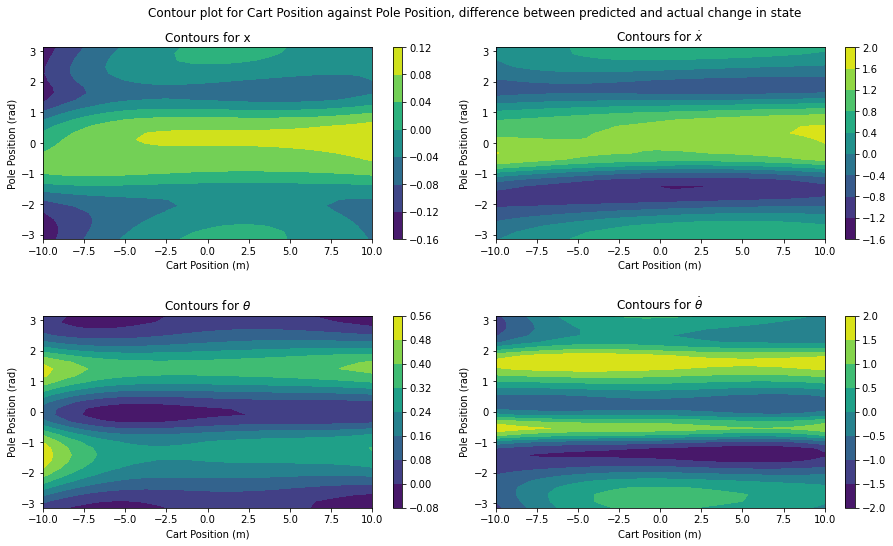

(30, 30, 4)


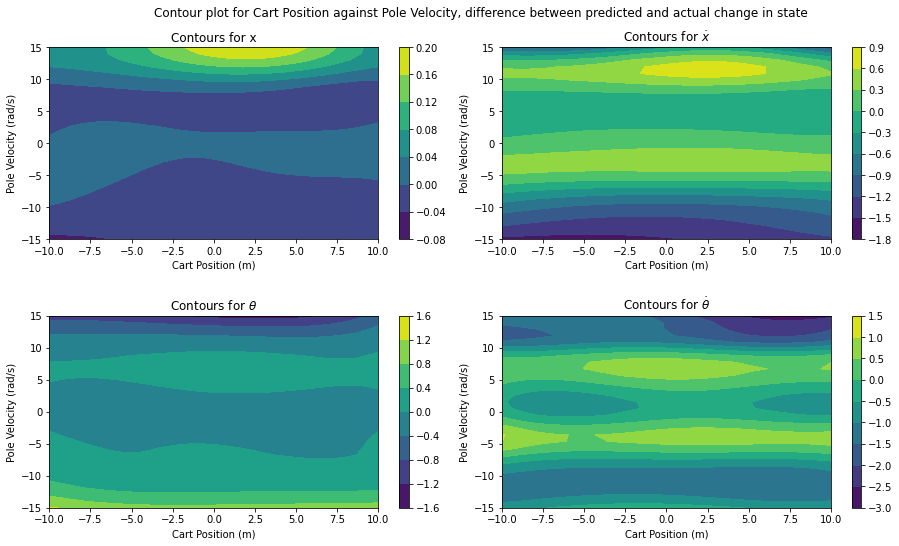

(30, 30, 4)


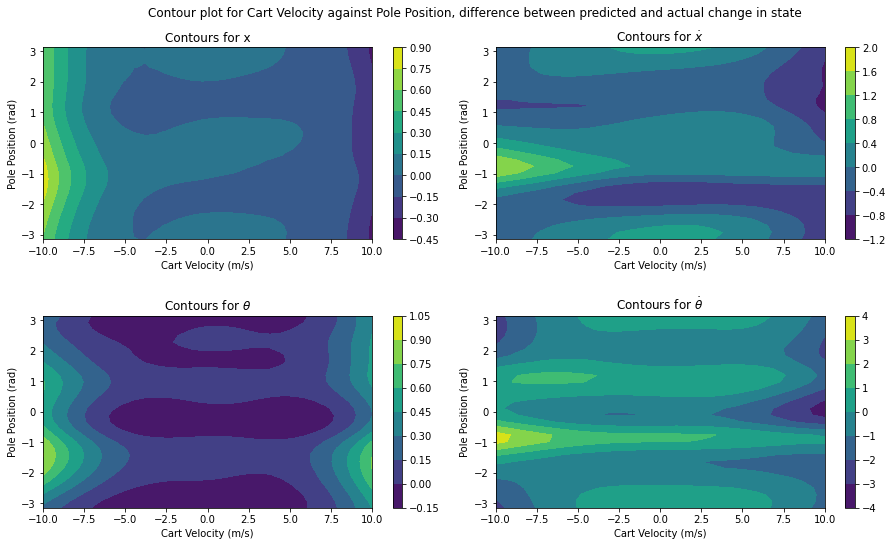

(30, 30, 4)


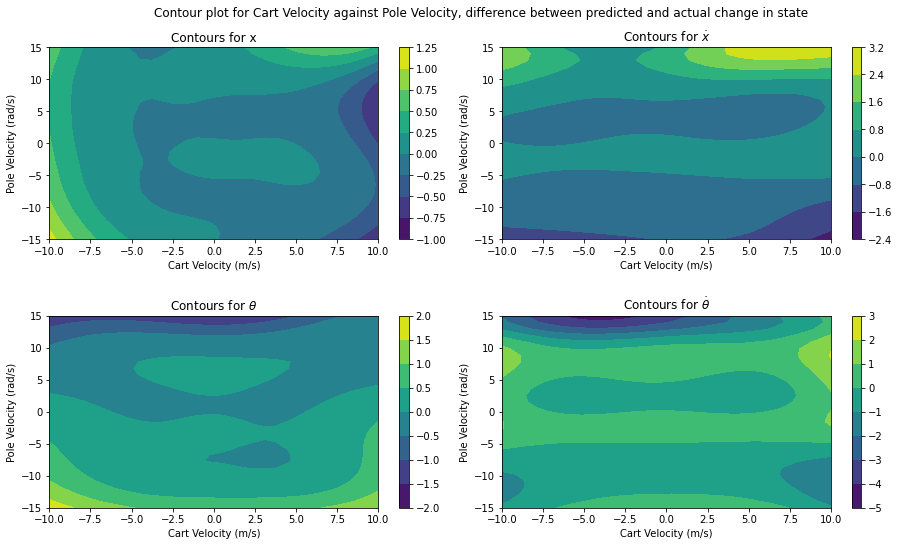

(30, 30, 4)


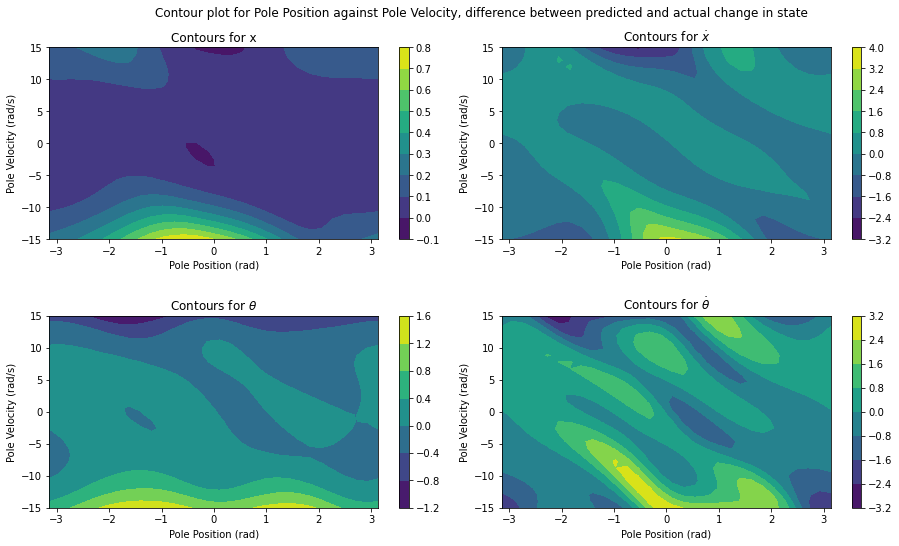

In [525]:
plot_contour21(0,1,basis_centres,alphas,sigmas)
plot_contour21(0,2,basis_centres,alphas,sigmas)
plot_contour21(0,3,basis_centres,alphas,sigmas)
plot_contour21(1,2,basis_centres,alphas,sigmas)
plot_contour21(1,3,basis_centres,alphas,sigmas)
plot_contour21(2,3,basis_centres,alphas,sigmas)

## Control

Having developed a good model for the dynamics, now it is time to control the system. In this exercise we will create a controller
to achieve a desired state by parametrising the actions of the controller, and optimising those parameters through evaluation of
the performance. This is called _reinforcement learning_ in general. Using the interaction of the controller with the system
to improve it is "direct policy search". There are many other, more sophisticated strategies.  

When you call the `performAction` routine, it takes a signed scalar which is interpreted as an external force on the cart. The value is passed through the `tanh` function 
before being interpreted as a force, this prevents the application of excessively large forces (the transformation is controlled
by the `max_force` variable inside the `CartPole` class.) The first thing you will need do is to modify your models (both the linear and nonlinear) to take account of this new state 
variable (i.e. your system now has 5 inputs, including the force F, and 4 outputs after a call to `performAction`). 

#### Task 2.2
Change your code so that the state vector now includes the action taken. Collect new data, again using random initial conditions or quasi-random sequences and one step, but this time include the action. Verify using scatter-plots, 1D and 2D scans and roll-outs that your models can predict the change in the state variables.  

In [676]:
X, Y, basis_centres = generate_dataset2(5000, 400, dim=5)

In [677]:
X_test, Y_test, basis_test = generate_dataset2(1000, 0, dim = 5)

In [678]:
sigmas = [10,7,2,10,20]

In [679]:
K, Km = get_Knxm(X, basis_centres, sigmas)

In [680]:
A = np.dot(K.T, K) + 1e-6*Km
B = np.array([np.dot(K.T, Y[:,i]) for i in range(4)])
B= B.T
alphas,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
alphas = alphas.T

In [681]:
print(alphas.shape)

(4, 400)


In [627]:
Y_pred = f3(X, basis_centres, alphas, sigmas)

In [628]:
model_mse = MSE(Y, Y_pred)
print(model_mse)

[1.79215340e-03 1.61375967e-01 1.56123718e-02 2.22807443e+00]


In [629]:
Y_test_pred = f3(X_test, basis_centres, alphas, sigmas)
print(MSE(Y_test, Y_test_pred))

[2.11911670e-03 1.66964275e-01 2.27861845e-02 2.51998431e+00]


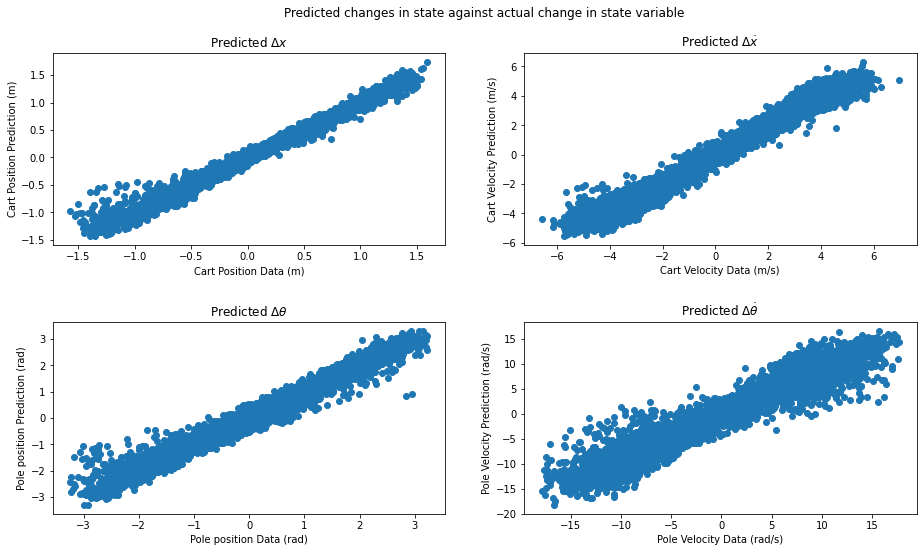

In [568]:
x1,y1 = X[:,0], Y[:,0]
y1_pred = Y_pred[:,0]
x2,y2 = X[:,1], Y[:,1]
y2_pred = Y_pred[:,1]
x3,y3 = X[:,2], Y[:,2]
y3_pred = Y_pred[:,2]
x4,y4 = X[:,3], Y[:,3]
y4_pred = Y_pred[:,3]

# print(type(y1), type(y1_pred))
# print(y1.shape, y1_pred.shape)


fig, axs = plt.subplots(2, 2)


fig.suptitle(f'Predicted changes in state against actual change in state variable')
axs[0,0].scatter(y1,y1_pred)
axs[0,0].set_title(r"Predicted $\Delta x$")
axs[0,0].set_xlabel("Cart Position Data (m)")
axs[0,0].set_ylabel("Cart Position Prediction (m)")
axs[0,1].scatter(y2,y2_pred)
axs[0,1].set_title(r"Predicted $\Delta\dot{x}$")
axs[0,1].set_xlabel("Cart Velocity Data (m/s)")
axs[0,1].set_ylabel("Cart Velocity Prediction (m/s)")
axs[1,0].scatter(y3,y3_pred)
axs[1,0].set_title(r"Predicted $\Delta\theta$")
axs[1,0].set_xlabel("Pole position Data (rad)")
axs[1,0].set_ylabel("Pole position Prediction (rad)")
axs[1,1].scatter(y4,y4_pred)
axs[1,1].set_title(r"Predicted $\Delta\dot{\theta}$")
axs[1,1].set_xlabel("Pole Velocity Data (rad/s)")
axs[1,1].set_ylabel("Pole Velocity Prediction (rad/s)")
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

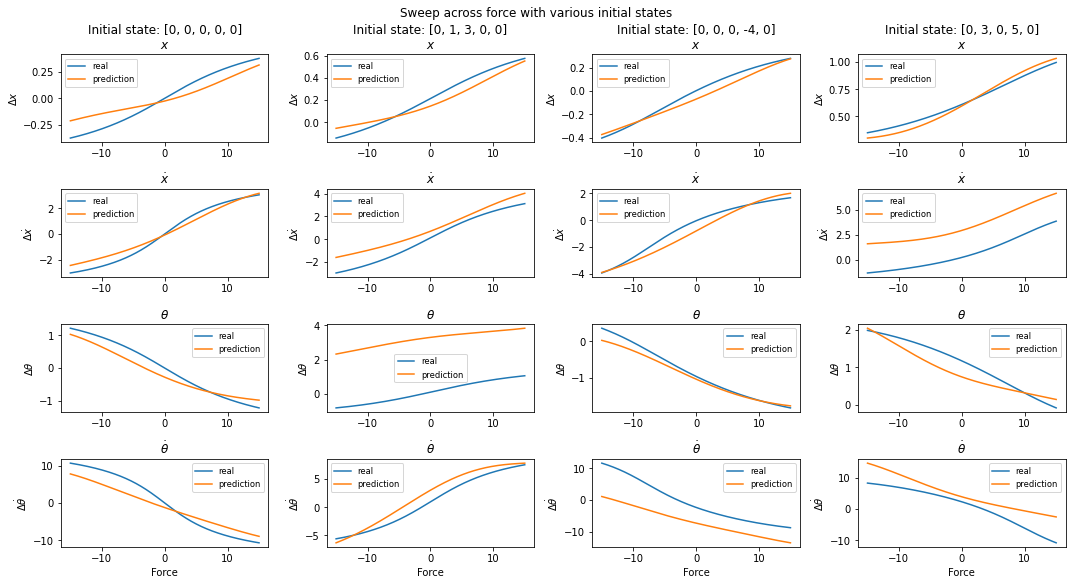

In [536]:
n = 1000
states_t = ((0,0,0,0,0),(0,1,3,0,0),(0,0,0,-4,0),(0,3,0,5,0))
ranges = (-15,15)
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$","force"]
# ylims = [[0.5,1],[0,0.7],[0.3,1.8],[-7,7]]
fig, axs = plt.subplots(4,4)
fig.suptitle(f"Sweep across force with various initial states", y=1.01)
for s, state_t in enumerate(states_t):
    for k in range(4):
        state = list(state_t)
        lower = ranges[0]
        upper = ranges[1]
        x = np.linspace(lower, upper, n)
        y = []
        y_pred = []
        for i in range(len(x)):
            state[4] =  x[i]
            cp.setState(state[:4])
            cp.performAction(state[4])
            new_state = cp.getState()
            y.append(new_state[k] - state[k])
            pred_state = state[:4] + f_5(state,basis_centres,alphas,sigmas)
            y_pred.append(pred_state[k])
        axs[k,s].plot(x,y,label='real')
        axs[k,s].plot(x,y_pred,label='prediction')
        # axs[k,s].set_ylim(ylims[k][0],ylims[k][1])
        if k == 3:
            axs[k,s].set_xlabel("Force")
        axs[k,s].set_ylabel(fr"$\Delta${labels[k]}")
        if k == 0:
            axs[k,s].set_title(f"Initial state: {list(state_t)}\n{labels[k]}")
        else:
            axs[k,s].set_title(f"{labels[k]}")
        axs[k,s].legend(fontsize = "small")
fig.tight_layout()
plt.show()

In [537]:
def state_slice22(var1,var2,n,basis_centres,alphas,sigmas):
    ranges = [(-10, 10),(-10, 10),(-p, p),(-15, 15),(-20,20)]
    state = get_init_state2(ranges)
    low1 = ranges[var1][0]
    up1 = ranges[var1][1]
    low2 = ranges[var2][0]
    up2 = ranges[var2][1]
    x1 = np.linspace(low1, up1, n)
    x2 = np.linspace(low2, up2, n)
    z = []
    for i in range(n):
        z_j = []
        for j in range(n):
            state[var1] = x1[i]
            state[var2] = x2[j]
            cp.setState(state[:4])
            cp.performAction()
            new_state = cp.getState()
            change = new_state - state[:4]
            pred_change = f_5(state, basis_centres,alphas,sigmas)
            error = pred_change - change
            z_j.append(error)
        z.append(z_j)
    return [x1,x2,np.array(z)]

In [544]:
def plot_contour22(var1,var2,basis_centres,alphas,sigmas,n=30):
    
    labels = ['Cart Position','Cart Velocity','Pole Position','Pole Velocity','Force']
    units = ['(m)','(m/s)','(rad)','(rad/s)', '']
    
    label1,label2 = labels[var1],labels[var2]
    unit1,unit2 = units[var1],units[var2]
    
    x1,x2,z = state_slice22(var1,var2,n,basis_centres,alphas,sigmas)
    print(z.shape)
    z1,z2,z3,z4 = z[:,:,0].T,z[:,:,1].T,z[:,:,2].T,z[:,:,3].T
    
    fig, axs = plt.subplots(2, 2)
    
    fig.suptitle(f'Contour plot for {label1} against {label2}, difference between predicted and actual change in state, including forces', y=0.97)
    cf1 = axs[0,0].contourf(x1,x2,z1)
    axs[0,0].set_title('Contours for x')
    axs[0,0].set_xlabel(f'{label1} {unit1}')
    axs[0,0].set_ylabel(f'{label2} {unit2}')
    fig.colorbar(cf1, ax=axs[0,0])
    cf2 = axs[0,1].contourf(x1,x2,z2)
    axs[0,1].set_title('Contours for $\dot{x}$')
    axs[0,1].set_xlabel(f'{label1} {unit1}')
    axs[0,1].set_ylabel(f'{label2} {unit2}')
    fig.colorbar(cf2, ax=axs[0,1])
    cf3 = axs[1,0].contourf(x1,x2,z3)
    axs[1,0].set_title(r'Contours for $\theta$')
    axs[1,0].set_xlabel(f'{label1} {unit1}')
    axs[1,0].set_ylabel(f'{label2} {unit2}')
    fig.colorbar(cf3, ax=axs[1,0])
    cf4 = axs[1,1].contourf(x1,x2,z4)
    axs[1,1].set_title(r'Contours for $\dot{\theta}$')
    axs[1,1].set_xlabel(f'{label1} {unit1}')
    axs[1,1].set_ylabel(f'{label2} {unit2}')
    fig.colorbar(cf4, ax=axs[1,1])
    
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)
    
    plt.show()

(30, 30, 4)


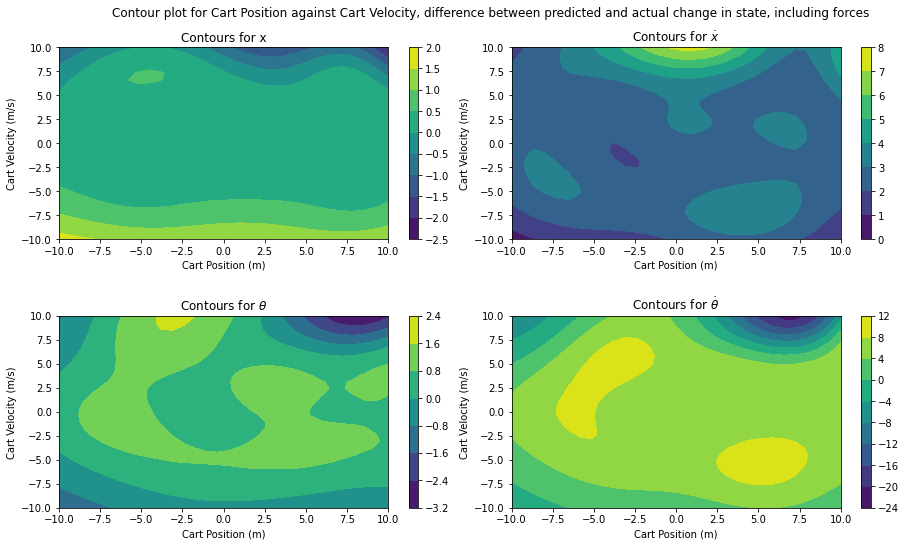

(30, 30, 4)


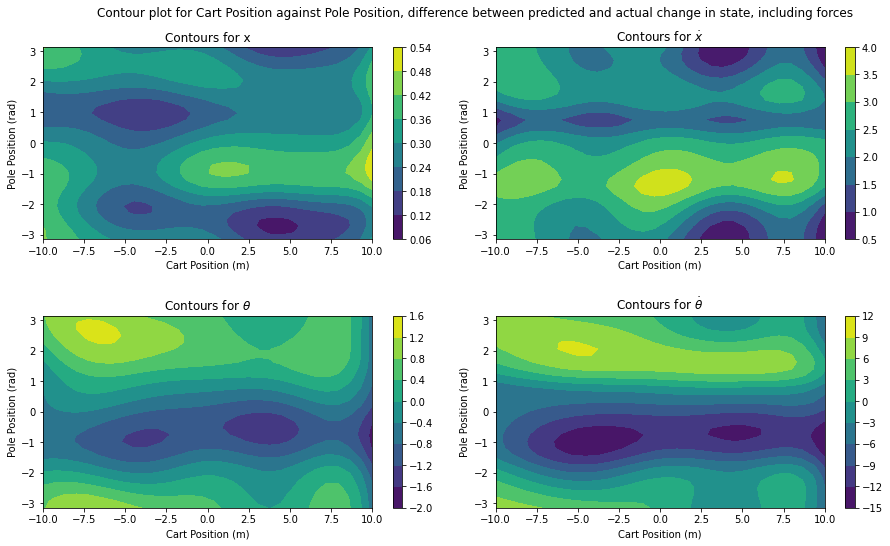

(30, 30, 4)


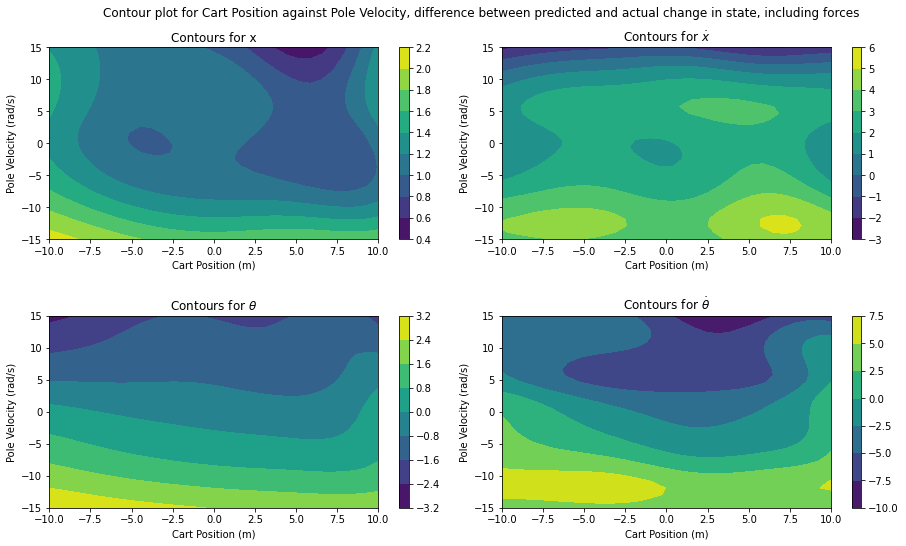

(30, 30, 4)


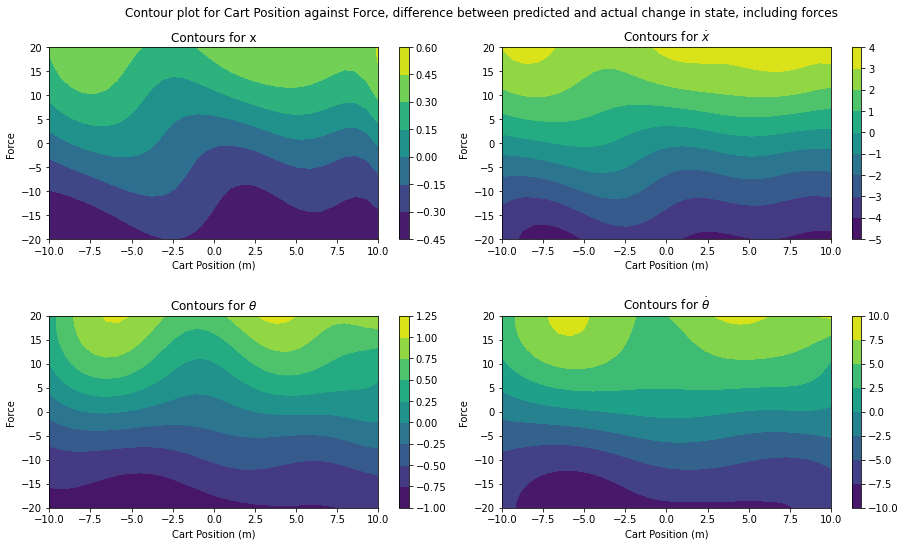

(30, 30, 4)


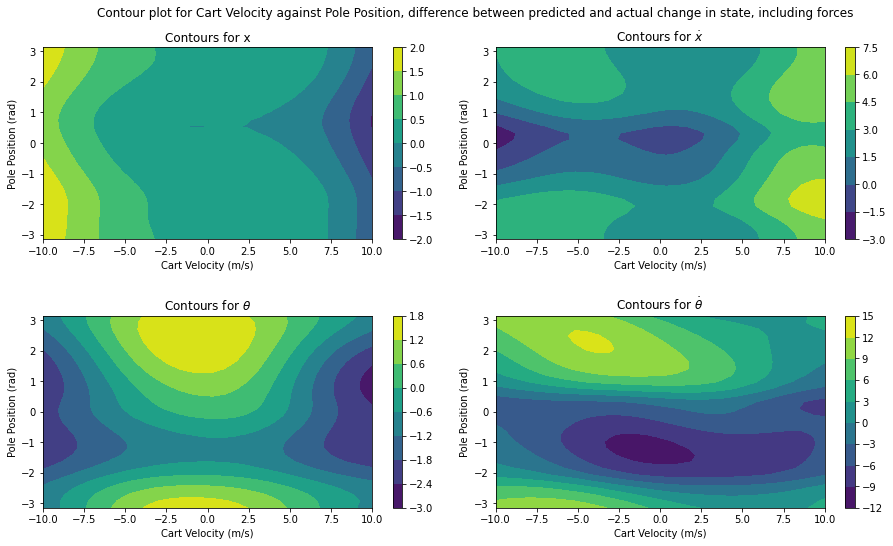

(30, 30, 4)


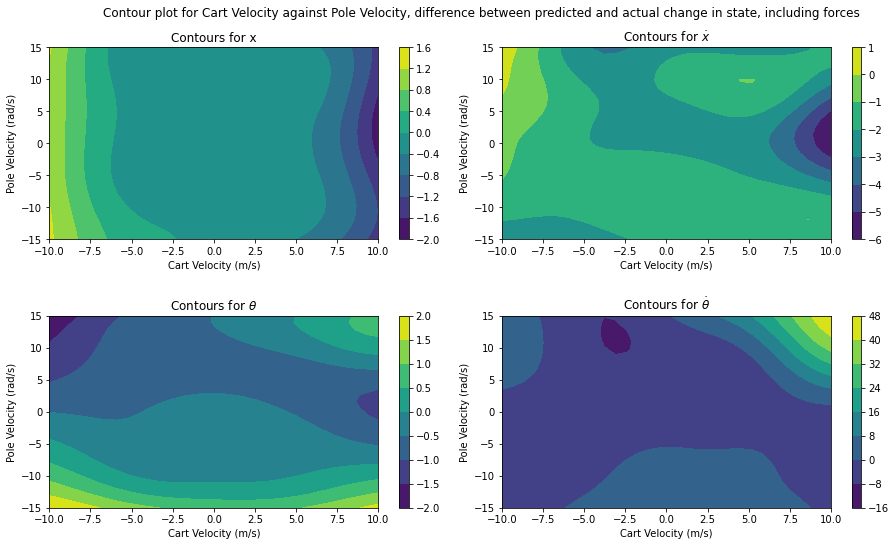

(30, 30, 4)


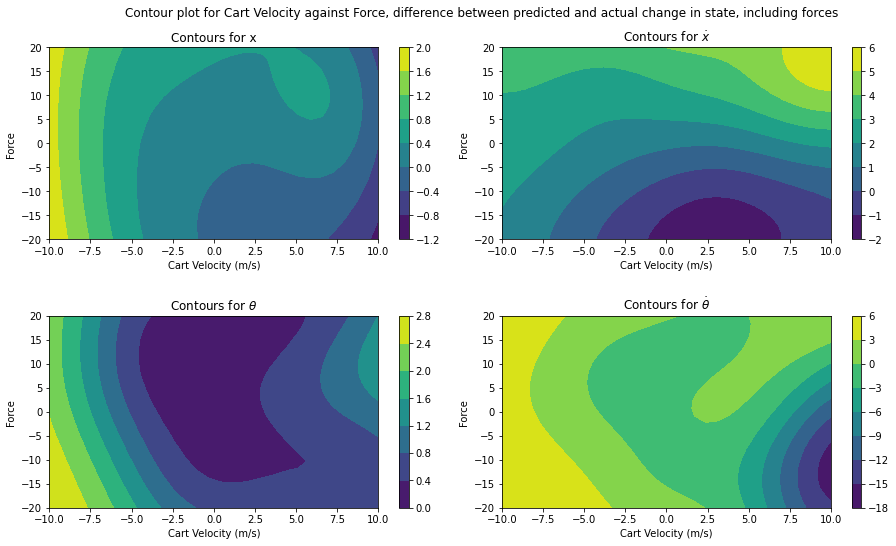

(30, 30, 4)


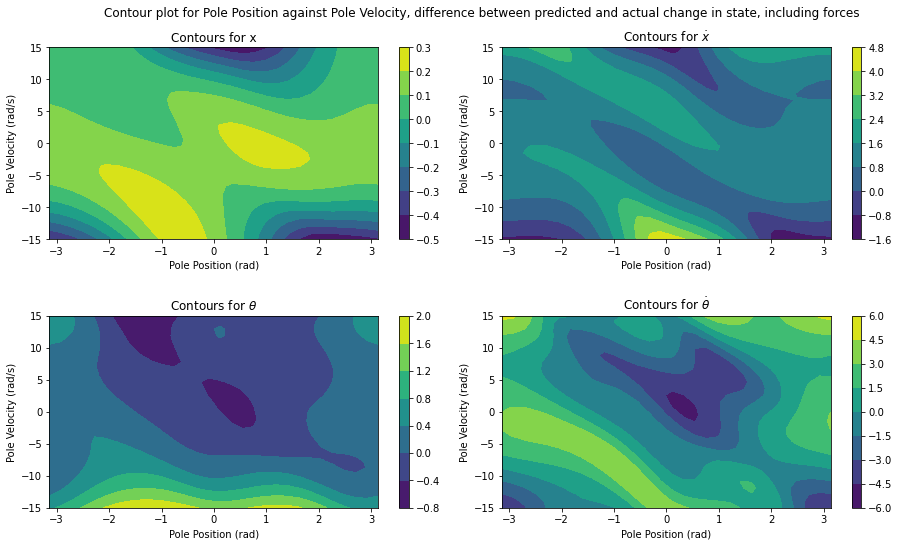

(30, 30, 4)


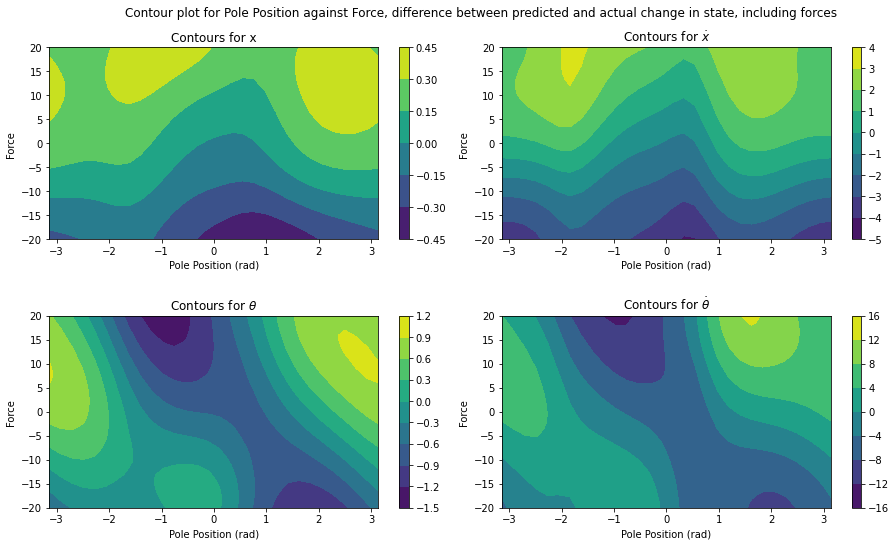

(30, 30, 4)


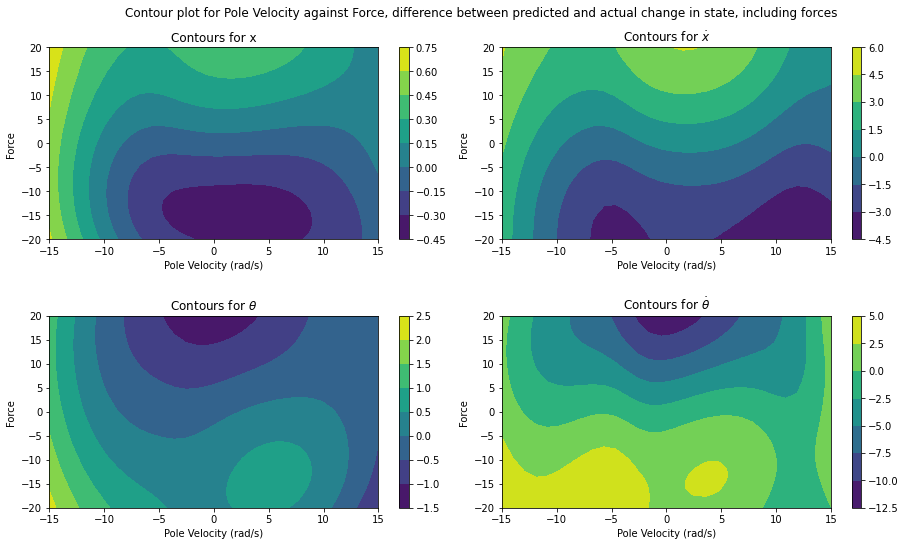

In [545]:
plot_contour22(0,1,basis_centres,alphas,sigmas)
plot_contour22(0,2,basis_centres,alphas,sigmas)
plot_contour22(0,3,basis_centres,alphas,sigmas)
plot_contour22(0,4,basis_centres,alphas,sigmas)
plot_contour22(1,2,basis_centres,alphas,sigmas)
plot_contour22(1,3,basis_centres,alphas,sigmas)
plot_contour22(1,4,basis_centres,alphas,sigmas)
plot_contour22(2,3,basis_centres,alphas,sigmas)
plot_contour22(2,4,basis_centres,alphas,sigmas)
plot_contour22(3,4,basis_centres,alphas,sigmas)

rollouts

In [694]:
num_iterations = 20
force = -3
init_state = [0,10,0,0,force]
dt = cp.delta_time
t = np.linspace(0,dt*num_iterations, num_iterations)
x = [init_state[:4]]
x_pred = [init_state]
cp.setState(init_state[:4])
for i in range(1,num_iterations):
    pred_state = x_pred[-1][:4] + f_5(x_pred[-1],basis_centres,alphas,sigmas)
    x_pred.append(np.append(pred_state,force))
    cp.performAction(force)
    next_state = cp.getState()
    x.append(next_state)
x = np.array(x)
x_pred = np.array(x_pred)
x1, x2, x3, x4 = x[:,0],x[:,1],x[:,2],x[:,3]
x1_pred,x2_pred,x3_pred,x4_pred = x_pred[:,0],x_pred[:,1],x_pred[:,2],x_pred[:,3]

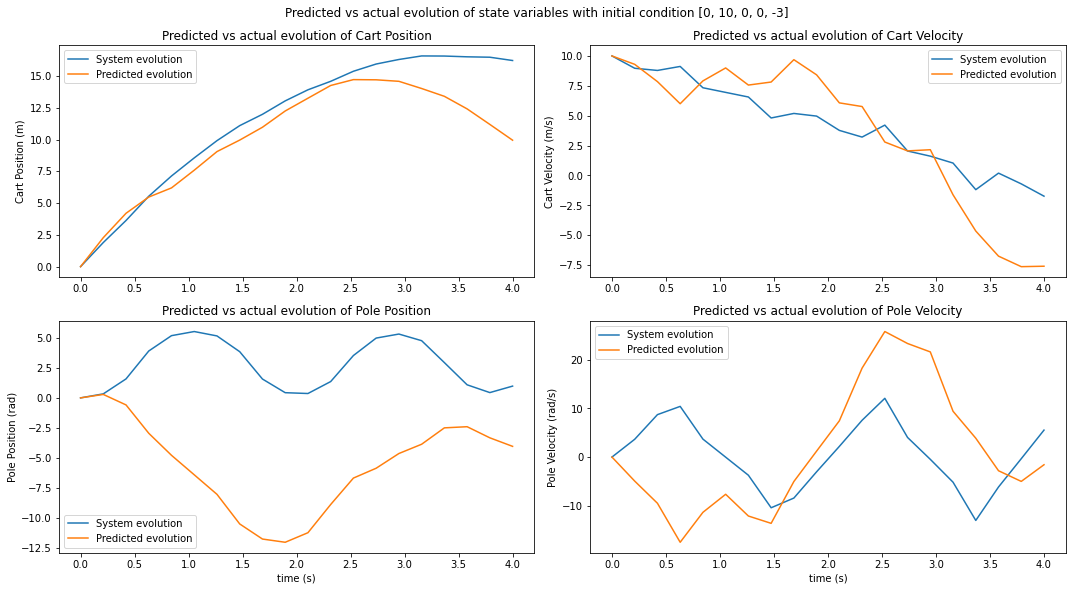

In [695]:
fig, axs = plt.subplots(2, 2)

fig.suptitle(f"Predicted vs actual evolution of state variables with initial condition {init_state}",y=1.02)

axs[0,0].plot(t,x1,label='System evolution')
axs[0,0].plot(t,x1_pred,label='Predicted evolution')
axs[0,0].set_title("Predicted vs actual evolution of Cart Position")
#axs[0,0].set_xlabel("time (s)")
axs[0,0].set_ylabel("Cart Position (m)")
axs[0,0].legend()

axs[0,1].plot(t,x2,label='System evolution')
axs[0,1].plot(t,x2_pred,label='Predicted evolution')
axs[0,1].set_title("Predicted vs actual evolution of Cart Velocity")
#axs[0,1].set_xlabel("time (s)")
axs[0,1].set_ylabel("Cart Velocity (m/s)")
axs[0,1].legend()

axs[1,0].plot(t,x3,label='System evolution')
axs[1,0].plot(t,x3_pred,label='Predicted evolution')
axs[1,0].set_title("Predicted vs actual evolution of Pole Position")
axs[1,0].set_xlabel("time (s)")
axs[1,0].set_ylabel("Pole Position (rad)")
axs[1,0].legend()

axs[1,1].plot(t,x4,label='System evolution')
axs[1,1].plot(t,x4_pred,label='Predicted evolution')
axs[1,1].set_title("Predicted vs actual evolution of Pole Velocity")
axs[1,1].set_xlabel("time (s)")
axs[1,1].set_ylabel("Pole Velocity (rad/s)")
axs[1,1].legend()
fig.tight_layout()
plt.show()

### Policies

A _policy_ is a function $p(X)$ that defines what the action should be given the other state variables. The  goal is 
to find a policy function that when enacted, gives rise to the desired behaviour, in this case the pole being balanced around 
its unstable equilibrium position. 

### Objective

In order to optimize a policy, we need to define, mathematically, what we want to achieve. That is captured in an _objective function_ (also called
_loss function_), a measure of how close we are to the desired behaviour. In the present case, we want the pole to be upright,
so we could use the _loss function_

$$
l(X) = -\cos\theta
$$

But it is better, and more general, to define a _target state_, $X_0$, which we want the system to achieve, and use a loss
function that increases when the distance of the state from the target is larger. The following loss function achieves this, 

$$
l(X) = 1- e^{-|X-X_0|^2/2\sigma_l^2}
$$
where $\sigma_l$ is a scaling factor (you could introduce a separate one for each component of the state variable). The target
state for the cartpole system is $X_0 = [0,0,0,0]$. The advantage
of this form is that for large departures from the target, the loss is independent of the state. This expresses the notion
that if the pole is far away from being upright and stationary, we do not much care what it is doing. The above loss functions
are for a given state. We wish to keep the pole upright continuously, so the total loss of a trajectory should be a time
integral (sum, in practice) of the pointwise loss of the state over some interval,

$$
L = \sum_{i=1}^N l(X_i)
$$

The `CartPole` class contains a function to evaluate the above pointwise loss $l(X)$. 

### Linear control

We start with defining a linear policy, 

$$
p(X) = \bf{p} \cdot X
$$

with unknown coefficent vector ${\bf p}$. 

#### Task 2.3

Write code to evaluate the loss function for the trajectory of a rollout - use a short time horizon, but enough to capture 1-2 
oscillation periods. Before any optimisation, _visualise_ the loss function as you vary some parameters in ${\bf p}$, using 
similar 1D and 2D scans that you did for Task 1, i.e. varying just one or two elements of  ${\bf p}$ and plotting the loss 
as a function of those elements. 

Optimise the unknowns in the policy to minimise the loss function. Since you do not have too many variables, you can do this 
by looking at how the loss changes for small changes in policy variables. Feel free to use off-she-shelf optimizers, e.g. from 
the `scipy.optimize` package. For low dimensional optimization problems without gradients available, you can use the `Nelder-Mead` method. 

Do not expect the loss to be a simple function of the policy parameters, or to have only a few minima - it is likely that you need
to explore a variety of initial conditions. But there is not just one solution! Explore the loss as a function of the
elements of ${\bf p}$.  Find elements of ${\bf p}$ that are able to stabilize the pole when started just slightly displaced 
from the upright unstable position.

How close do you have to start? Plot the time evolution of the variables under the policy to demonstrate that the pole is kept upright. 

In [318]:
from CartPole import loss
from scipy.optimize import minimize

In [325]:
def rolloutf(init_state, num_timesteps, pol):
    traj = np.zeros([num_timesteps,4])
    cp.setState(init_state)
    for i in range(num_timesteps):
        state = cp.getState()
        traj[i] = state
        cp.setState(state)
        force = policy(pol, state)
        cp.performAction(force)
    return traj

In [326]:
def rollout_loss(pol, init_state = [0,0,p,0], num_timesteps = 20):
    traj = rolloutf(init_state, num_timesteps, pol)
    losses = np.zeros(len(traj))
    for i, state in enumerate(traj):
        losses[i] = loss(state)
    return np.sum(losses)

In [327]:
def policy(pol, state):
    return np.dot(pol, state)

In [336]:
def plot_loss(pol = np.array([0,0,0,0]), init_state = get_init_state()):
    pol = tuple(pol)
    p_ranges = [(-10,10),(-10,10),(-10,10),(-10,10)]
    # losses = np.zeros([4,100])
    ax = [[0,0],[0,1],[1,0],[1,1]]
    fig, axs = plt.subplots(2,2)
    fig.suptitle(f"Sweep elements of p with p = {pol} and initial state {init_state}", y=1.01)
    for i in range(4):
        pp = np.array(pol)
        low = pol[i] + p_ranges[i][0]
        high = pol[i] + p_ranges[i][1]
        ps = np.linspace(low, high, 100)
        p_loss = np.zeros(len(ps))
        for j, val in enumerate(ps):
            pp[i] = val
            r_loss = rollout_loss(pp, init_state, 20)
            p_loss[j] = r_loss
        # losses[i] = p_loss
        axs[ax[i][0], ax[i][1]].plot(ps, p_loss)
        axs[ax[i][0], ax[i][1]].set_title(f"Sweep p[{i}] in range ({low}, {high})")
        axs[ax[i][0], ax[i][1]].set_ylabel("Rollout loss")
        axs[ax[i][0], ax[i][1]].set_xlabel(f"p[{i}]")
    fig.tight_layout()
    plt.show()

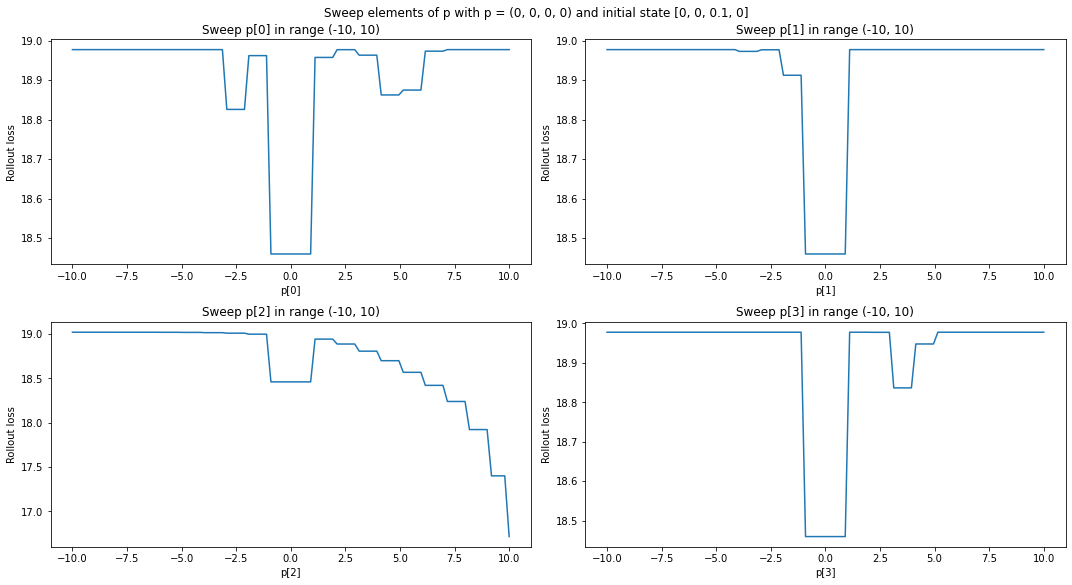

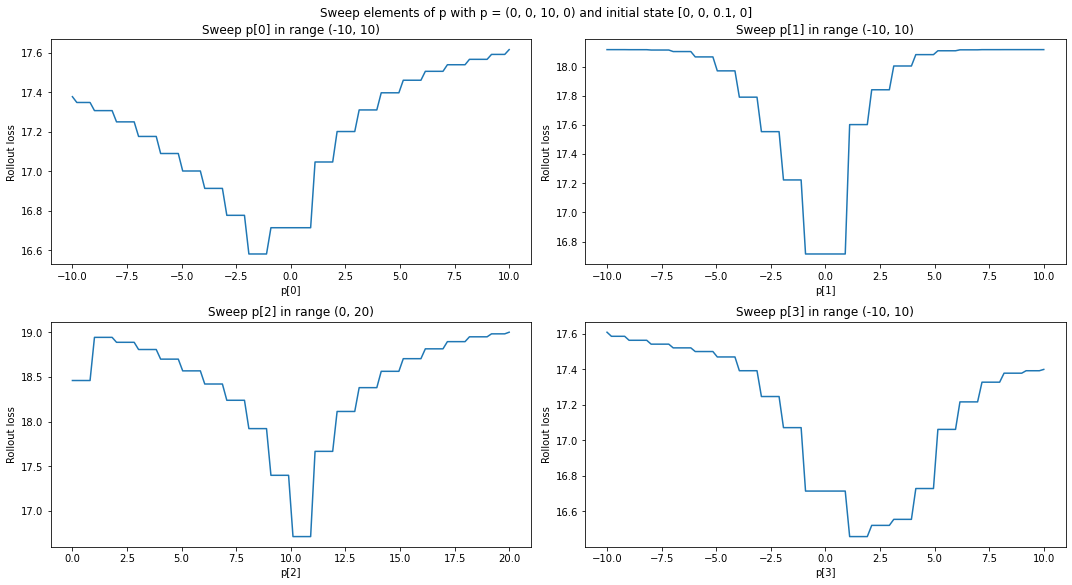

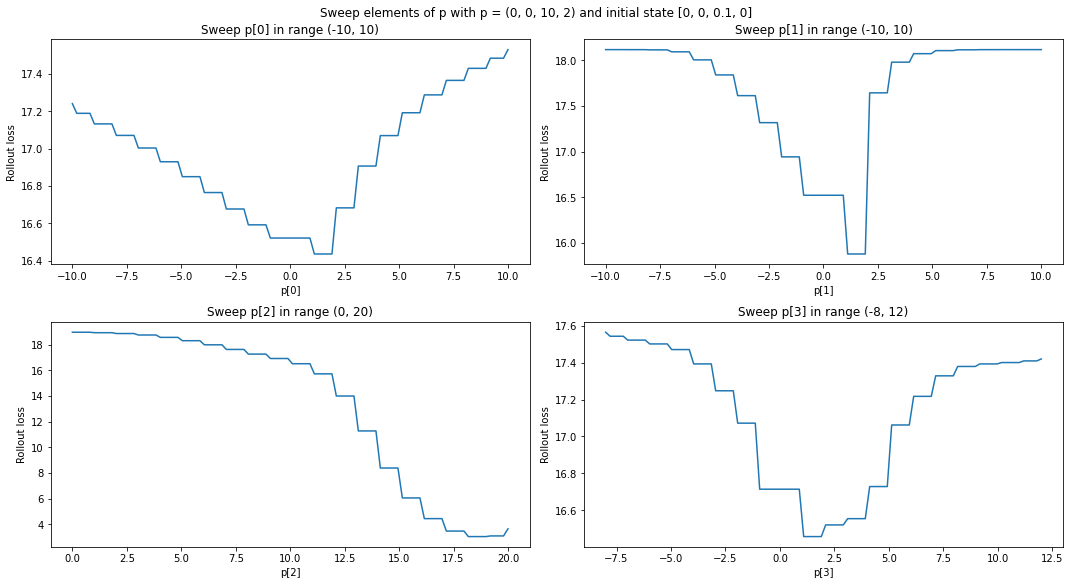

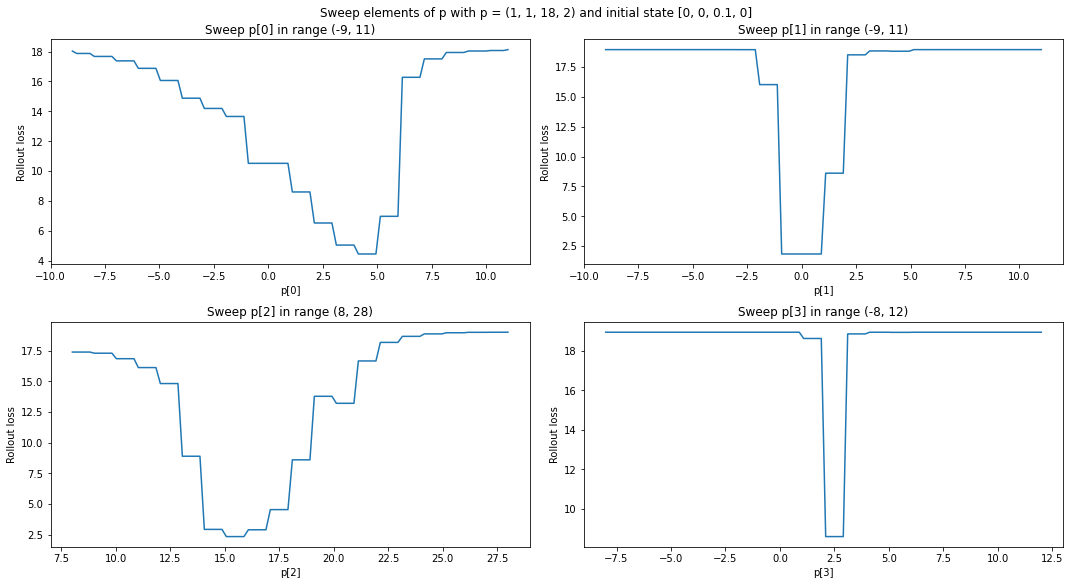

In [696]:
# plot_loss(pol = [0.75606656,1.19603569,16.32977696,2.49565269],init_state=[0,0,0.1,0])
plot_loss(pol = [0,0,0,0],init_state=[0,0,0.1,0])
plot_loss(pol = [0,0,10,0],init_state=[0,0,0.1,0])
plot_loss(pol = [0,0,10,2],init_state=[0,0,0.1,0])
plot_loss(pol = [1,1,18,2],init_state=[0,0,0.1,0])

In [707]:
def plot_contour_pol(pol = np.array([0,0,0,0]), init_state = get_init_state(), n=30):
    # p_ranges = [[[(-10,10),(-10,10)],[(-10,10),(-10,10)],[(-10,10),(-10,10)]],[[],[(-10,10),(-10,10)],[(-10,10),(-10,10)]],[[],[],[(-10,10),(-10,10)]]]
    ax = [[[0,0],[0,1],[0,2]],[[],[1,0],[1,1]],[[],[],[1,2]]]
    pol = tuple(pol)
    # ranges = [[5,12],[0,10],[10,15],[10,15]]
    fig, axs = plt.subplots(2, 3)
    fig.suptitle(f'Contour plot for rollout loss varying p with p = [{pol[0]:.1f}, {pol[1]:.1f}, {pol[2]:.1f}, {pol[3]:.1f}] and initial state {init_state}', y=0.97)
    
    for i,j in [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]:
        pp = np.array(pol)
        # low1, high1 = ranges[i][0], ranges[i][1]
        # low2, high2 = ranges[j][0], ranges[j][1]
        low1, high1 = pp[i] - 10, pp[i] + 10
        low2, high2 = pp[j] - 10, pp[j] + 10
        ps1 = np.linspace(low1, high1, n)
        ps2 = np.linspace(low2, high2, n)
        p_loss = np.zeros([len(ps1), len(ps2)])
        for k, val1 in enumerate(ps1):
            for l, val2 in enumerate(ps2):
                pp[i], pp[j] = val1, val2
                r_loss = rollout_loss(pp, init_state, 20)
                p_loss[k,l] = r_loss
        cf = axs[ax[i][j-1][0], ax[i][j-1][1]].contourf(ps1,ps2,p_loss.T)
        axs[ax[i][j-1][0], ax[i][j-1][1]].set_title(f'Contours varying p [{i}] and p [{j}]', y = 1.04)
        axs[ax[i][j-1][0], ax[i][j-1][1]].set_xlabel(f'p [{i}]')
        axs[ax[i][j-1][0], ax[i][j-1][1]].set_ylabel(f'p [{j}]')
        fig.colorbar(cf, ax=axs[ax[i][j-1][0], ax[i][j-1][1]])
    
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
    
    plt.show()

In [470]:
theta = 0.1
x0 = np.array([1, 1, 10, 1])
res = minimize(rollout_loss, x0, args=([0,0,theta,0], 20),method='nelder-mead')

In [471]:
print(res.x)
print(res.fun)

[ 0.75606656  1.19603569 16.32977696  2.49565269]
1.0696081678479001


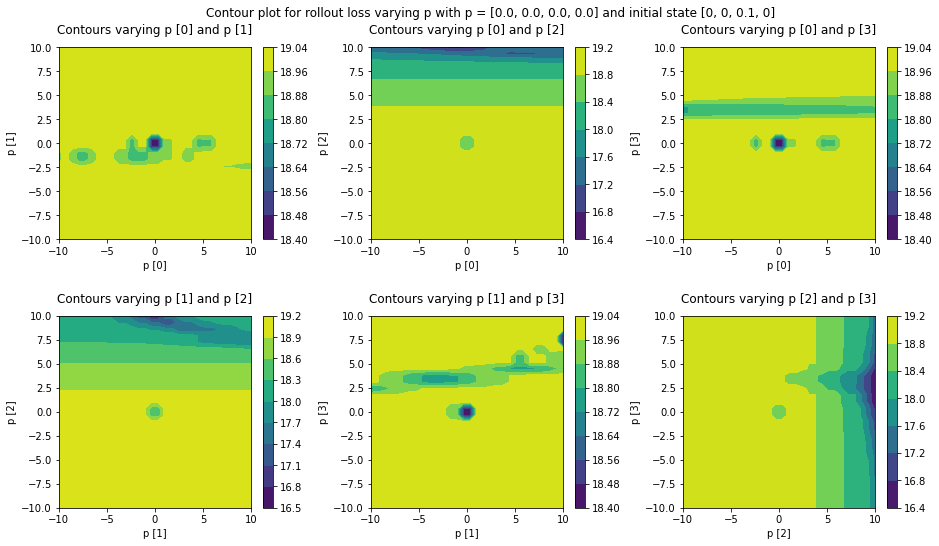

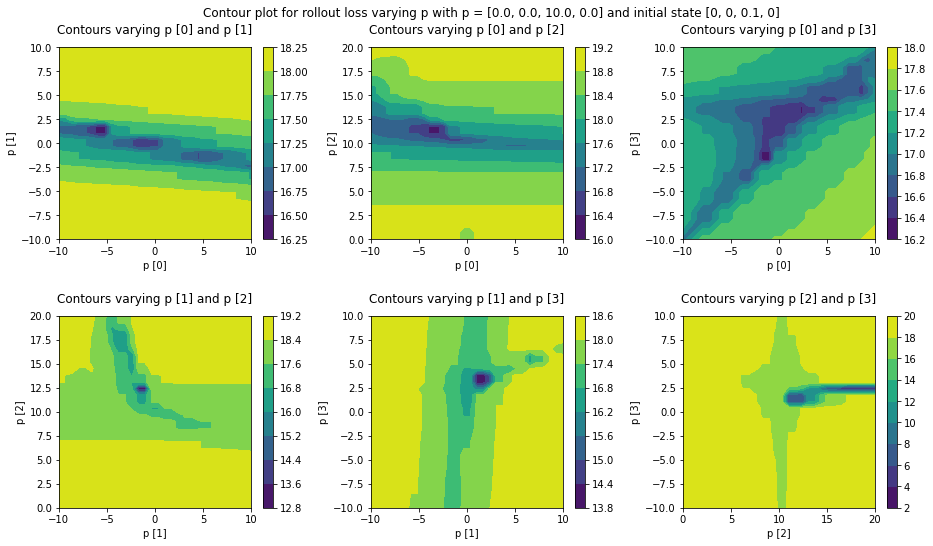

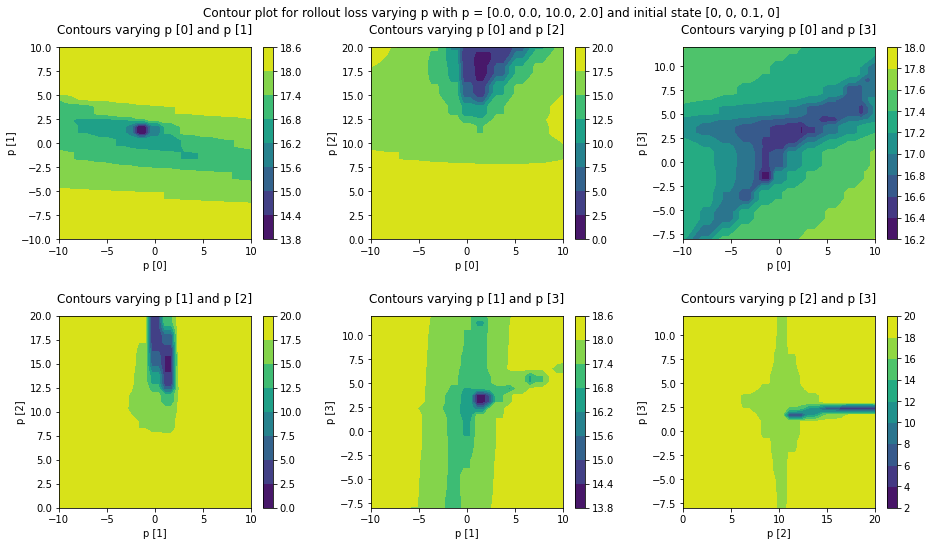

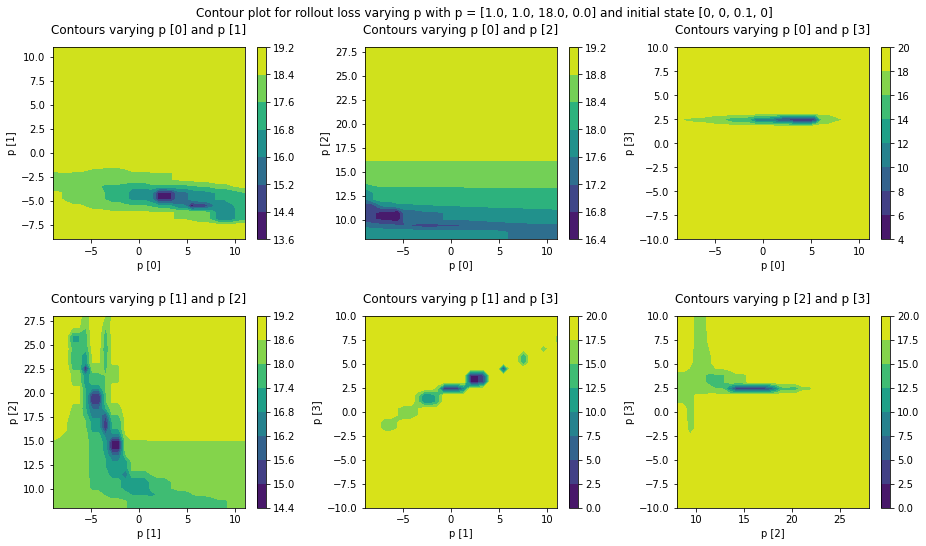

In [708]:
plot_contour_pol(pol = [0,0,0,0], init_state=[0,0,0.1,0],n=30)
plot_contour_pol(pol = [0,0,10,0], init_state=[0,0,0.1,0],n=30)
plot_contour_pol(pol = [0,0,10,2], init_state=[0,0,0.1,0],n=30)
plot_contour_pol(pol = [1,1,18,0], init_state=[0,0,0.1,0],n=30)

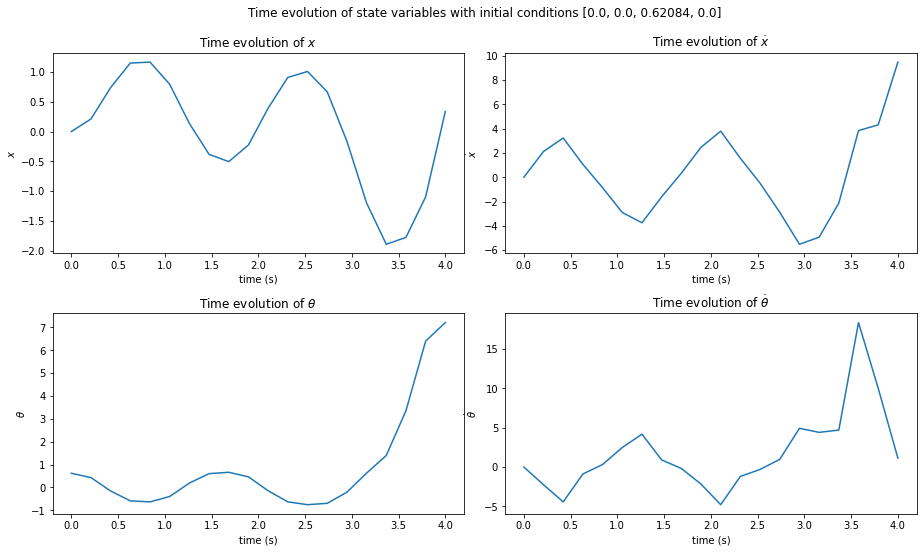

In [703]:
num_timesteps = 20
init_state = np.array([0,0,0.62084,0])
traj = np.array(rolloutf(init_state, num_timesteps, res.x))
t = np.linspace(0,0.2*num_timesteps,num_timesteps)
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Time evolution of state variables with initial conditions {list(init_state)}")
for i in range(4):
    axs[ax[i][0],ax[i][1]].plot(t, traj[:,i])
    axs[ax[i][0],ax[i][1]].set_title(f"Time evolution of {labels[i]}")
    axs[ax[i][0],ax[i][1]].set_xlabel("time (s)")
    axs[ax[i][0],ax[i][1]].set_ylabel(labels[i])
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.3)
plt.show()
    

In [343]:
def rollout_loss_mult(pol, init_states = [[0,0,p,0]], num_timesteps = 40):
    summ = 0
    for state in init_states:
        traj = rolloutf(state, num_timesteps, pol)
        losses = np.zeros(len(traj))
        for i, state in enumerate(traj):
            losses[i] = loss(state)
        summ += np.sum(losses)
    return summ

In [348]:
init_states = [[0,0,0.1,0],[0,0,0,0],[0,0,-0.1,0]]

In [349]:
x0 = np.array([0.75606656,1.19603569,16.32977696,2.49565269])
res232 = minimize(rollout_loss_mult, x0, args=(init_states, 40),method='nelder-mead')

In [350]:
print(res232.x)
print(res232.fun)

[ 0.76190785  1.19126712 16.33104546  2.49340473]
2.1394420497369864


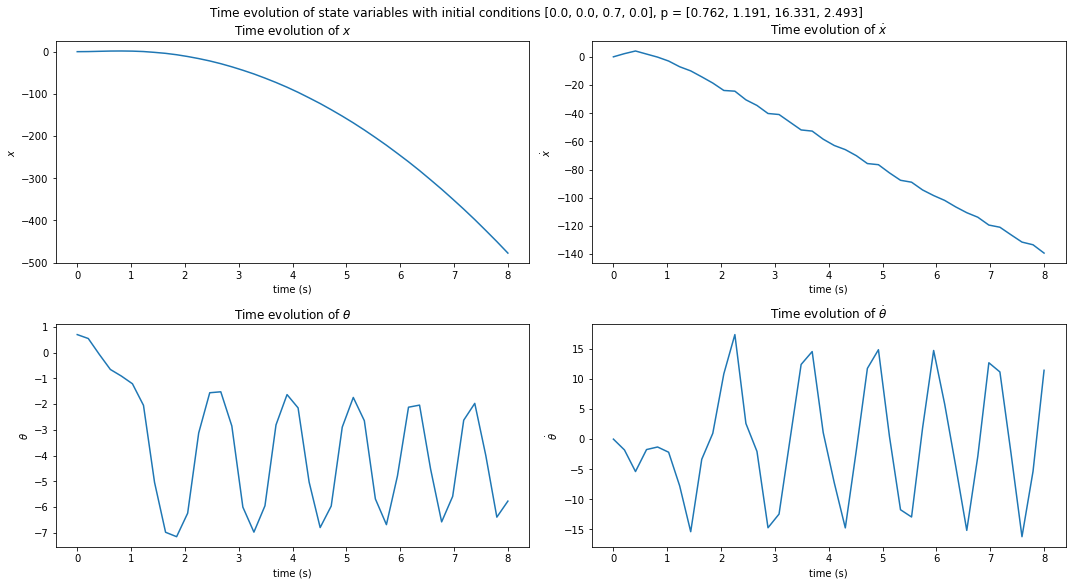

In [706]:
num_timesteps = 40
init_state = np.array([0,0,0.7,0])
traj = np.array(rolloutf(init_state, num_timesteps, res232.x))
t = np.linspace(0,0.2*num_timesteps,num_timesteps)
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Time evolution of state variables with initial conditions {list(init_state)}, p = [{res232.x[0]:.3f}, {res232.x[1]:.3f}, {res232.x[2]:.3f}, {res232.x[3]:.3f}]", y=1.01)
for i in range(4):
    axs[ax[i][0],ax[i][1]].plot(t, traj[:,i])
    axs[ax[i][0],ax[i][1]].set_title(f"Time evolution of {labels[i]}")
    axs[ax[i][0],ax[i][1]].set_xlabel("time (s)")
    axs[ax[i][0],ax[i][1]].set_ylabel(labels[i])
plt.tight_layout()
plt.show()
    

#### Task 2.4

In the previous task you used the real dynamics to evaluate a policy. But we have a good _model_ of the dynamics (the nonlinear
one from Task 2.1). Try to optimise the policy parameters by testing them on model-rollouts. 
You need to limit the time horizon (number of steps) to where you think your model is still 
accurate. (Using models to optimise policy is called _model predictive control_)



In [630]:
def rolloutf_model(init_state, num_timesteps, pol, basis_centres, alphas, sigmas):
    traj = np.zeros([num_timesteps,5])
    new_state = np.array(init_state[:4])
    new_state = np.append(new_state, policy(pol, new_state))
    for i in range(num_timesteps):
        state = new_state
        traj[i] = state
        new_state = traj[i,:4] + f_5(state,basis_centres,alphas,sigmas)
        force = policy(pol, new_state)
        new_state = np.append(new_state, force)
    return traj

def rollout_loss_model(pol, init_state, basis_centres, alphas, sigmas, num_timesteps = 10):
    traj = rolloutf_model(init_state, num_timesteps, pol, basis_centres, alphas, sigmas)
    losses = np.zeros(len(traj))
    for i, state in enumerate(traj):
        losses[i] = loss(state)
    return np.sum(losses)

def policy(pol, state):
    return np.dot(pol, state)


In [631]:
theta = 0.1
x0 = np.array([0.75606656,1.19603569,16.32977696,2.49565269])
res24 = minimize(rollout_loss_model, x0, args=([0,0,theta,0],basis_centres,alphas,sigmas, 10),method='nelder-mead')

In [632]:
print(res24.x)
print(res24.fun)

[23.59156124  7.65214291 38.20115191  4.6511022 ]
6.07134469022667


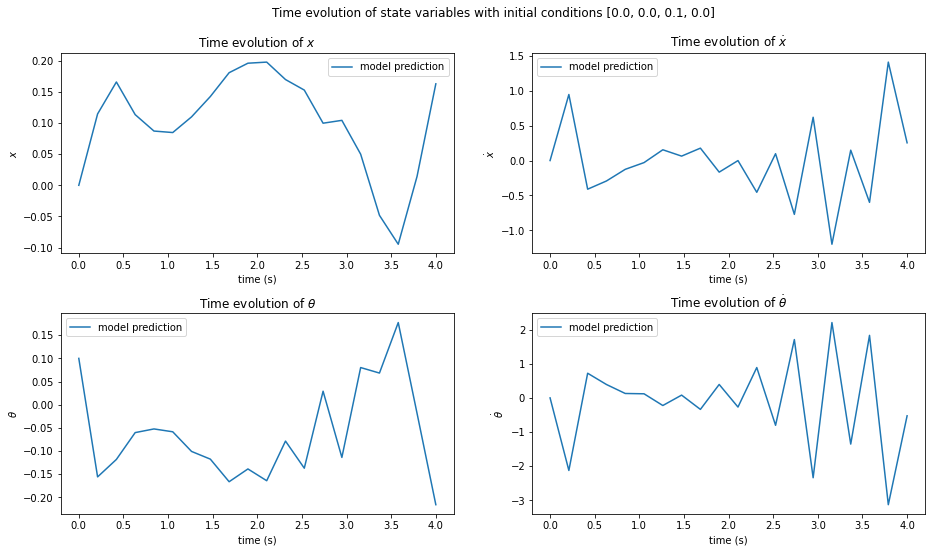

In [650]:
num_timesteps = 20
init_state = np.array([0,0,0.1,0])
traj = np.array(rolloutf_model(init_state, num_timesteps, res24.x, basis_centres, alphas, sigmas))
traj_real = np.array(rolloutf(init_state, num_timesteps, res24.x))
t = np.linspace(0,0.2*num_timesteps,num_timesteps)
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Time evolution of state variables with initial conditions {list(init_state)}")
for i in range(4):
    axs[ax[i][0],ax[i][1]].plot(t, traj[:,i],label='model prediction')
    # axs[ax[i][0],ax[i][1]].plot(t, traj_real[:,i],label='real evolution')
    axs[ax[i][0],ax[i][1]].set_title(f"Time evolution of {labels[i]}")
    axs[ax[i][0],ax[i][1]].set_xlabel("time (s)")
    axs[ax[i][0],ax[i][1]].set_ylabel(labels[i])
    axs[ax[i][0],ax[i][1]].legend()
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

In [634]:
def rollout_loss_mult_model(pol, init_states, basis_centres, alphas, sigmas, num_timesteps = 10):
    summ = 0
    for state in init_states:
        traj = rolloutf_model(init_state, num_timesteps, pol, basis_centres, alphas, sigmas)
        losses = np.zeros(len(traj))
        for i, state in enumerate(traj):
            losses[i] = loss(state)
        summ += np.sum(losses)
    return summ

In [642]:
theta = 0.05
init_states = [[0,0,theta,0],[0,0,0,0],[0,0,-theta,0]]

In [643]:
x0 = np.array([1,1,10,1])
res242 = minimize(rollout_loss_mult_model, x0, args=(init_states,basis_centres,alphas,sigmas, 10),method='nelder-mead')

In [644]:
print(res242.x)
print(res242.fun)

[ 0.41068052  0.2420114  11.55538496  1.55218629]
20.681279280524052


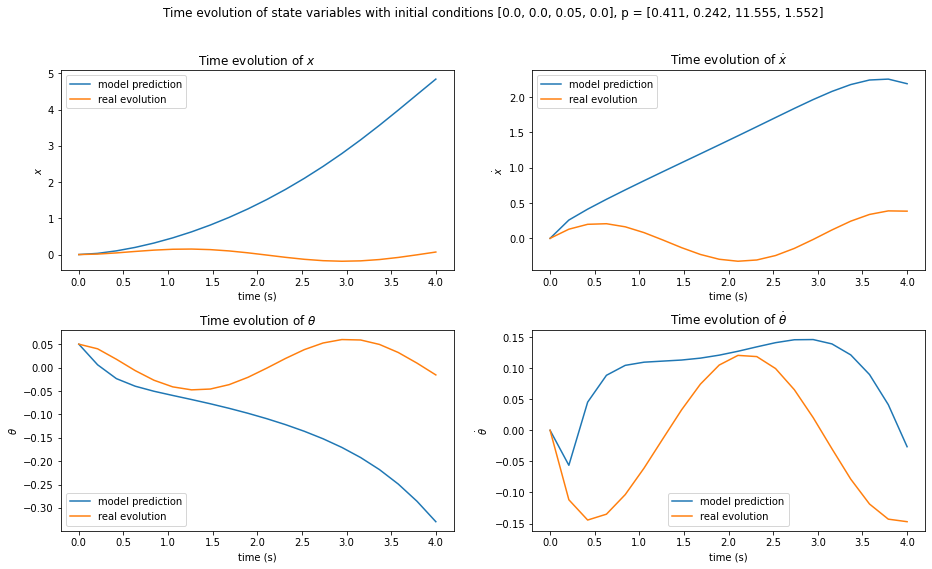

In [645]:
num_timesteps = 20
init_state = np.array([0,0,theta,0])
traj = np.array(rolloutf_model(init_state, num_timesteps, res242.x, basis_centres, alphas, sigmas))
traj_real = np.array(rolloutf(init_state, num_timesteps, res242.x))
t = np.linspace(0,0.2*num_timesteps,num_timesteps)
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Time evolution of state variables with initial conditions {list(init_state)}, p = [{res242.x[0]:.3f}, {res242.x[1]:.3f}, {res242.x[2]:.3f}, {res242.x[3]:.3f}]", y=1.01)
for i in range(4):
    axs[ax[i][0],ax[i][1]].plot(t, traj[:,i],label='model prediction')
    axs[ax[i][0],ax[i][1]].plot(t, traj_real[:,i],label='real evolution')
    axs[ax[i][0],ax[i][1]].set_title(f"Time evolution of {labels[i]}")
    axs[ax[i][0],ax[i][1]].set_xlabel("time (s)")
    axs[ax[i][0],ax[i][1]].set_ylabel(labels[i])
    axs[ax[i][0],ax[i][1]].legend()
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

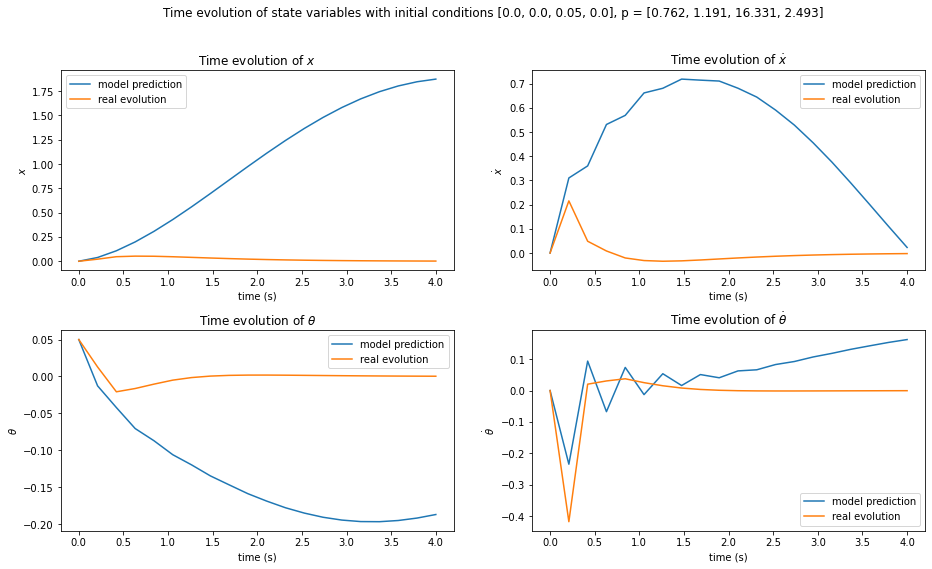

In [639]:
num_timesteps = 20
init_state = np.array([0,0,theta,0])
traj = np.array(rolloutf_model(init_state, num_timesteps, res232.x, basis_centres, alphas, sigmas))
traj_real = np.array(rolloutf(init_state, num_timesteps, res232.x))
t = np.linspace(0,0.2*num_timesteps,num_timesteps)
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Time evolution of state variables with initial conditions {list(init_state)}, p = [{res232.x[0]:.3f}, {res232.x[1]:.3f}, {res232.x[2]:.3f}, {res232.x[3]:.3f}]", y=1.01)
for i in range(4):
    axs[ax[i][0],ax[i][1]].plot(t, traj[:,i],label='model prediction')
    axs[ax[i][0],ax[i][1]].plot(t, traj_real[:,i],label='real evolution')
    axs[ax[i][0],ax[i][1]].set_title(f"Time evolution of {labels[i]}")
    axs[ax[i][0],ax[i][1]].set_xlabel("time (s)")
    axs[ax[i][0],ax[i][1]].set_ylabel(labels[i])
    axs[ax[i][0],ax[i][1]].legend()
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

In [607]:
print(traj[:,4])

[  0.81648885  -6.77381555  -7.09143975   1.71584531  12.6399326
  15.92853872  17.12652547   6.24167663  33.9501914   85.49915845
  91.0792086   93.75145746  95.54321633  96.88860813  97.96237281
  98.85323499  99.61258945 100.27290554 100.8560089  101.3772732 ]


## Week 3: Sensitivity and stability

We go back to the beginning of the project, and modify the problem, introducing noise in various forms, and observe its effect. 

#### Task 3.1

Introduce noise in the _observed_ dynamics (but not in the real dynamics of the system). Refit the models (linear and nonlinear), 
and characterise the degradation in the prediction accuracy. Reoptimise the linear policy, and check its stability, contrasting it with the noise-free case.

#### Task 3.2

Introduce noise in the actual dynamics of the cartpole system, and repeat the tests of the previous task. 


In [266]:
def generate_dataset_noise(num_datapoints, m, ranges=[(-10,10), (-5,5),(-p,p),(-10,10),(-30,30)], dim=4, scales = [0.01]):
    centres = get_basis_centres(m, dim, 30)
    X = np.zeros([num_datapoints,dim])
    Y_noise = np.zeros([len(scales),num_datapoints,4])
    for i, centre in enumerate(centres):
        state = centre
        cp.setState(state[:4])
        if dim == 4:
            cp.performAction()
        elif dim == 5:
            cp.performAction(state[4])
        new_state = cp.getState()
        change = new_state - state[:4]
        for k, scale in enumerate(scales):
            noise = np.random.default_rng().normal(scale = scale, size = 4)
            Y_noise[k][i] = change + noise
        X[i] = state
    for i in range(m, num_datapoints):
        if dim == 4:
            state = get_init_state(ranges[:4])
        elif dim == 5:
            state = get_init_state2(ranges)
        cp.setState(state[:4])
        if dim == 4:
            cp.performAction()
        elif dim == 5:
            cp.performAction(state[4])
        new_state = cp.getState()
        change = new_state - state[:4]
        for k, scale in enumerate(scales):
            noise = np.random.default_rng().normal(scale = scale, size = 4)
            Y_noise[k][i] = change + noise
        noise = np.random.default_rng().normal(scale = scale, size = 4)
        X[i] = state
    return X, Y_noise, centres


In [709]:
scales = [0,0.01,0.1,1,10]

In [710]:
X, Y_noise, centres31  = generate_dataset_noise(5000, 400, scales=scales)

Linear model with noise

In [711]:
C,_,_,_ = np.array(np.linalg.lstsq(X, Y_noise[0], rcond = None))
C_001,_,_,_ = np.array(np.linalg.lstsq(X, Y_noise[1], rcond = None))
C_01,_,_,_ = np.array(np.linalg.lstsq(X, Y_noise[2], rcond = None))
C_1,_,_,_ = np.array(np.linalg.lstsq(X, Y_noise[3], rcond = None))
C_10,_,_,_ = np.array(np.linalg.lstsq(X, Y_noise[4], rcond = None))

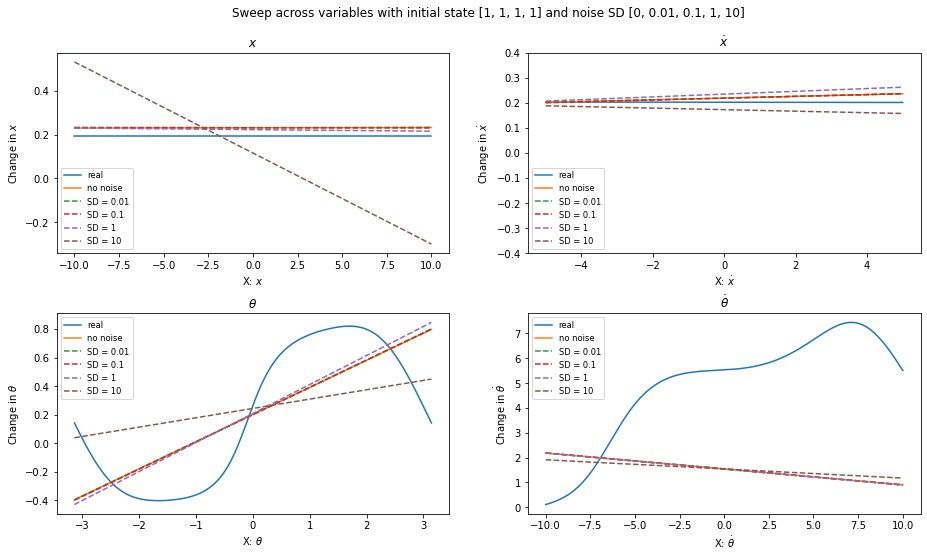

In [718]:
n = 1000
state_t = (1,1,1,1)
ranges = [(-10, 10),(-5, 5),(-p, p),(-10, 10)]
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
# ylims = [[0.5,1],[0,0.7],[0.3,1.8],[-7,7]]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Sweep across variables with initial state {list(state_t)} and noise SD {scales}")
for k in range(4):
    state = list(state_t)
    lower = ranges[k][0]
    upper = ranges[k][1]
    x = np.linspace(lower, upper, n)
    y = []
    y_pred = []
    y_pred_001 = []
    y_pred_01 = []
    y_pred_1 = []
    y_pred_10 = []
    for i in range(len(x)):
        state[k] =  x[i]
        cp.setState(state)
        cp.performAction()
        new_state = cp.getState()
        y.append(new_state[k] - state[k])
        pred_state = np.dot(C.T, state)
        pred_state_001 = np.dot(C_001.T, state)
        pred_state_01 = np.dot(C_01.T, state)
        pred_state_1 = np.dot(C_1.T, state)
        pred_state_10 = np.dot(C_10.T, state)
        y_pred.append(pred_state[k])
        y_pred_001.append(pred_state_001[k])
        y_pred_01.append(pred_state_01[k])
        y_pred_1.append(pred_state_1[k])
        y_pred_10.append(pred_state_10[k])
    axs[ax[k][0],ax[k][1]].plot(x,y,label='real')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred,label='no noise')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred_001,label='SD = 0.01',linestyle = 'dashed')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred_01,label='SD = 0.1',linestyle = 'dashed')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred_1,label='SD = 1',linestyle = 'dashed')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred_10,label='SD = 10',linestyle = 'dashed')
    if k == 1:    
        axs[ax[k][0],ax[k][1]].set_ylim(-0.4,0.4)
    axs[ax[k][0],ax[k][1]].set_xlabel(f"X: {labels[k]}")
    axs[ax[k][0],ax[k][1]].set_ylabel(f"Change in {labels[k]}")
    axs[ax[k][0],ax[k][1]].set_title(f"{labels[k]}")
    axs[ax[k][0],ax[k][1]].legend(fontsize = "small")
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

Non-linear model with noise

In [89]:
scales = [0,0.01,0.03,0.1,0.3,1,3]

In [90]:
X, Y_noise, centres31  = generate_dataset_noise(5000, 400, scales=scales)
X_test,Y_noise_test,_ = generate_dataset_noise(1000,0,scales=scales)

In [91]:
train_MSE_list2 = []
test_MSE_list2 = []
sigmas = [50, 10, 4, 15]
for i, scale in enumerate(scales):
    K, Km = get_Knxm(X, centres31, sigmas)
    lam = scale**2
    A = np.dot(K.T, K) + lam*Km
    B = np.array([np.dot(K.T, Y_noise[i,:,k]) for k in range(4)])
    B = B.T
    alphas,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
    alphas = alphas.T
    Y_pred = f2(X, centres31, alphas, sigmas)
    Y_pred_test = f2(X_test, centres31, alphas, sigmas)
    train_MSE_list2.append(MSE(Y_noise[0], Y_pred))
    test_MSE_list2.append(MSE(Y_noise_test[0], Y_pred_test))

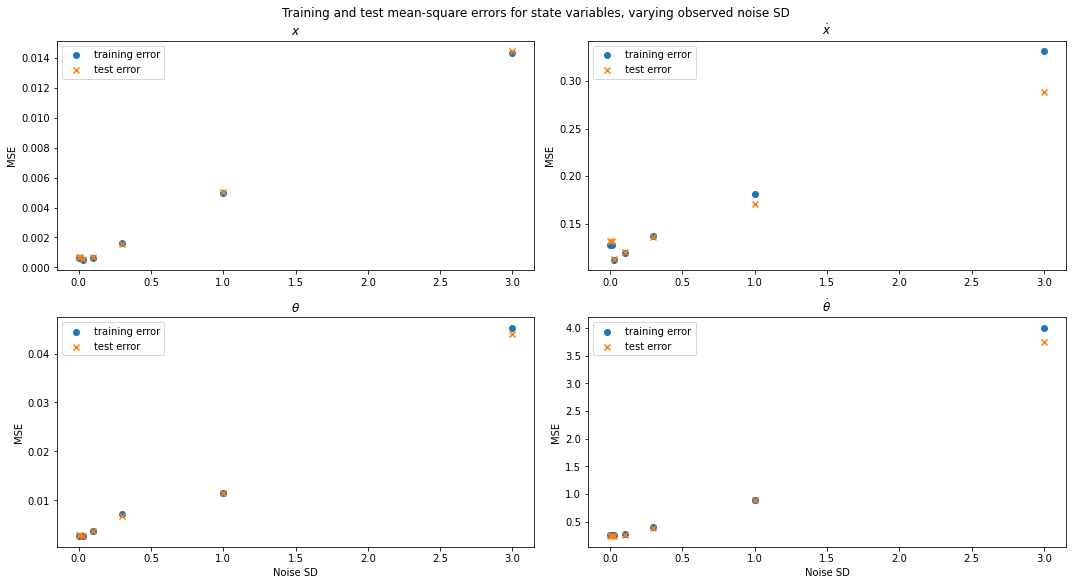

In [92]:
train_MSE_list2 = np.array(train_MSE_list2)
test_MSE_list2 = np.array(test_MSE_list2)
y1_train_MSE2, y1_test_MSE2 = train_MSE_list2[:,0], test_MSE_list2[:,0]
y2_train_MSE2, y2_test_MSE2 = train_MSE_list2[:,1], test_MSE_list2[:,1]
y3_train_MSE2, y3_test_MSE2 = train_MSE_list2[:,2], test_MSE_list2[:,2]
y4_train_MSE2, y4_test_MSE2 = train_MSE_list2[:,3], test_MSE_list2[:,3]

fig, axs = plt.subplots(2,2)

fig.suptitle("Training and test mean-square errors for state variables, varying observed noise SD", y = 1.01)

axs[0,0].scatter(scales, y1_train_MSE2, label='training error')
axs[0,0].scatter(scales, y1_test_MSE2, label='test error', marker = 'x')
axs[0,0].set_title("$x$")
axs[0,0].set_ylabel("MSE")
# axs[0,0].semilogx(basex=2)
axs[0,0].legend()
axs[0,1].scatter(scales, y2_train_MSE2, label='training error')
axs[0,1].scatter(scales, y2_test_MSE2, label='test error', marker = 'x')
axs[0,1].set_title("$\dot{x}$")
axs[0,1].set_ylabel("MSE")
# axs[0,1].semilogx(basex=2)
axs[0,1].legend()
axs[1,0].scatter(scales, y3_train_MSE2, label='training error')
axs[1,0].scatter(scales, y3_test_MSE2, label='test error', marker = 'x')
axs[1,0].set_title(r"$\theta$")
axs[1,0].set_xlabel("Noise SD")
axs[1,0].set_ylabel("MSE")
# axs[1,0].semilogx(basex=2)
axs[1,0].legend()
axs[1,1].scatter(scales, y4_train_MSE2, label='training error')
axs[1,1].scatter(scales, y4_test_MSE2, label='test error', marker = 'x')
axs[1,1].set_title(r"$\dot{\theta}$")
axs[1,1].set_xlabel("Noise SD")
axs[1,1].set_ylabel("MSE")
# axs[1,1].semilogx(basex=2)
axs[1,1].legend()
plt.tight_layout()
plt.show()

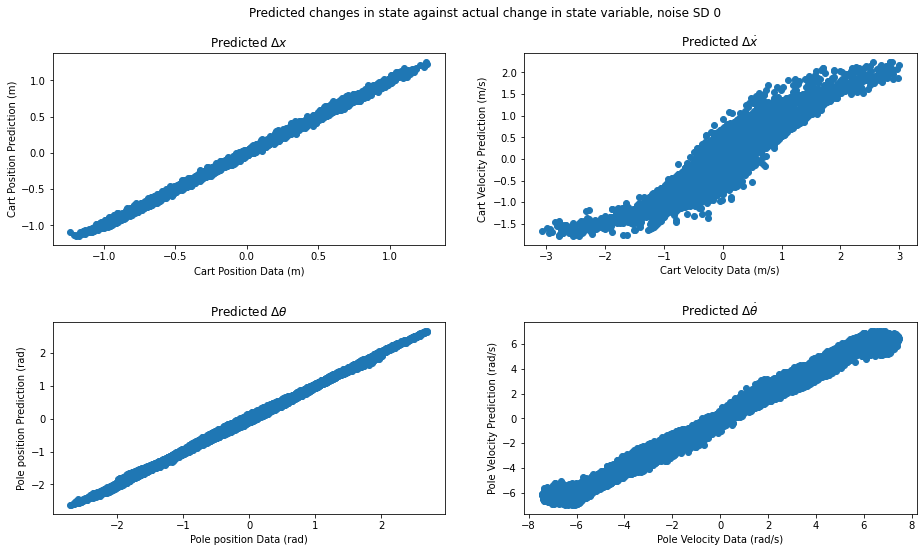

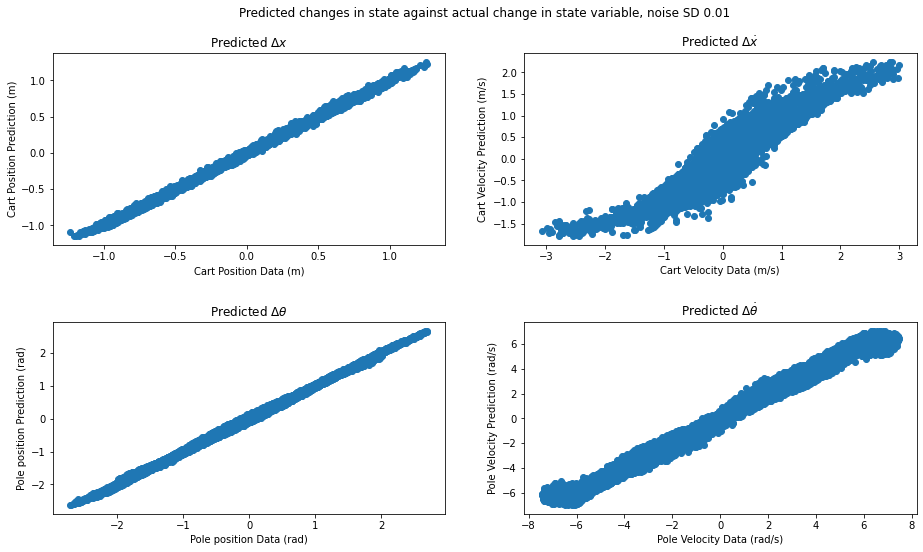

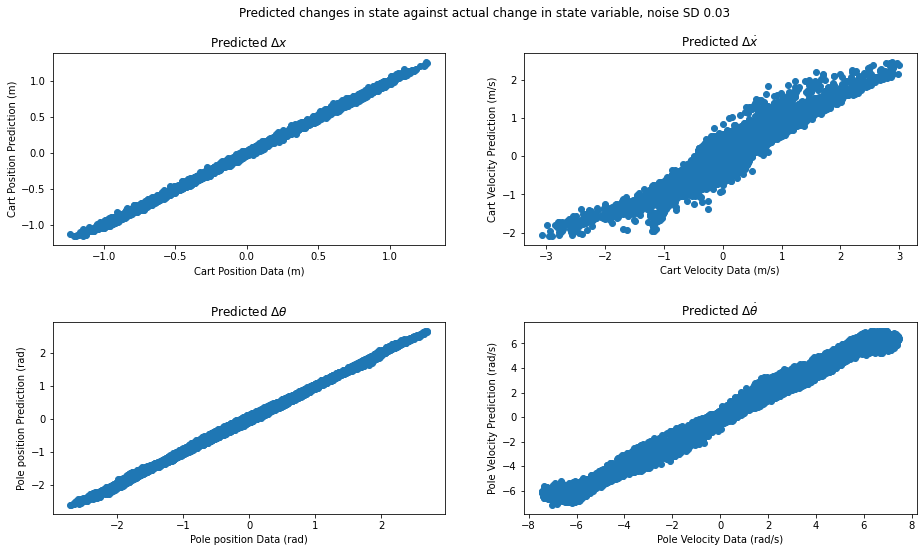

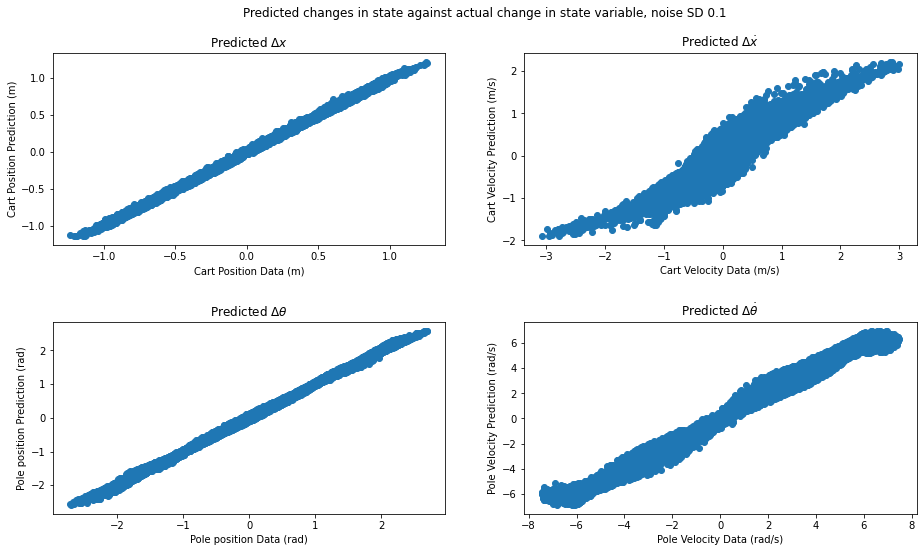

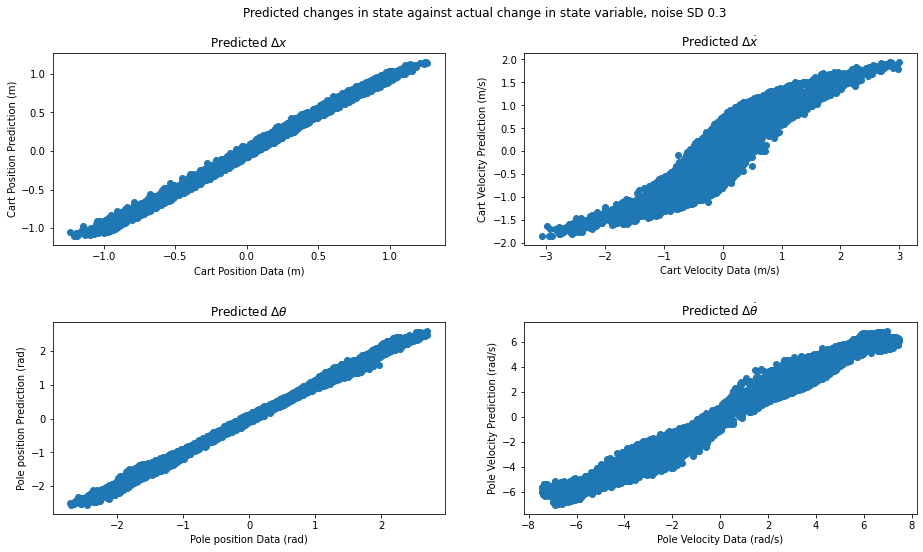

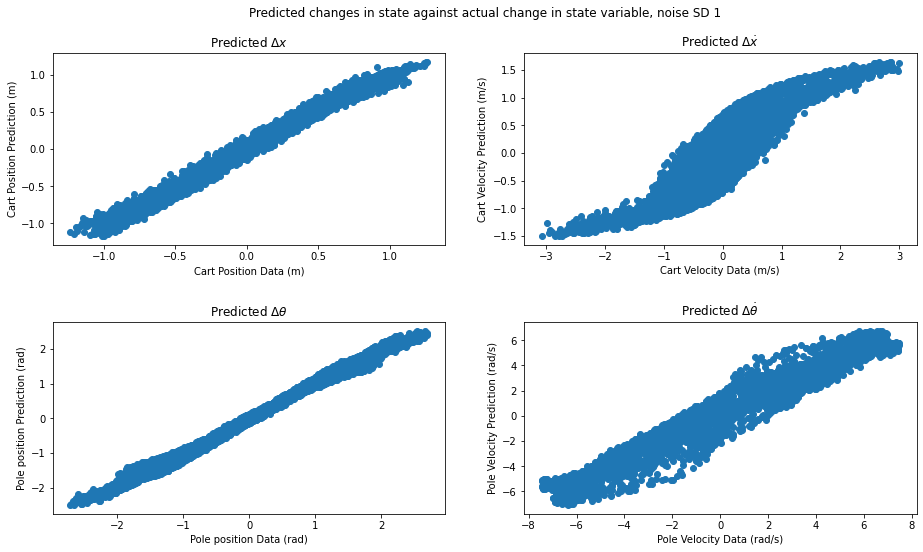

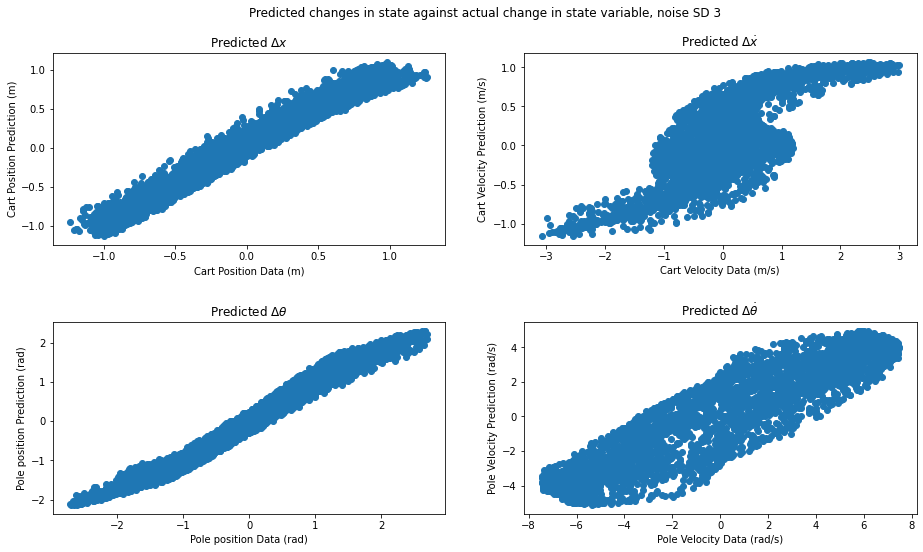

In [151]:
sigmas = [50, 10, 4, 15]
for i, scale in enumerate(scales):
    K, Km = get_Knxm(X, centres31, sigmas)
    lam = scale**2
    A = np.dot(K.T, K) + lam*Km
    B = np.array([np.dot(K.T, Y_noise[i,:,k]) for k in range(4)])
    B = B.T
    alphas,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
    alphas = alphas.T
    Y_pred = f2(X, centres31, alphas, sigmas)
    # Y_pred_test = f2(X_test, centres31, alphas, sigmas)
    # train_MSE_list2.append(MSE(Y_noise[0], Y_pred))
    # test_MSE_list2.append(MSE(Y_noise_test[0], Y_pred_test))
    x1,y1 = X[:,0], Y_noise[0,:,0]
    y1_pred = Y_pred[:,0]
    x2,y2 = X[:,1], Y_noise[0,:,1]
    y2_pred = Y_pred[:,1]
    x3,y3 = X[:,2], Y_noise[0,:,2]
    y3_pred = Y_pred[:,2]
    x4,y4 = X[:,3], Y_noise[0,:,3]
    y4_pred = Y_pred[:,3]
    
    fig, axs = plt.subplots(2, 2)

    fig.suptitle(f'Predicted changes in state against actual change in state variable, noise SD {scale}')
    axs[0,0].scatter(y1,y1_pred)
    axs[0,0].set_title(r"Predicted $\Delta x$")
    axs[0,0].set_xlabel("Cart Position Data (m)")
    axs[0,0].set_ylabel("Cart Position Prediction (m)")
    axs[0,1].scatter(y2,y2_pred)
    axs[0,1].set_title(r"Predicted $\Delta\dot{x}$")
    axs[0,1].set_xlabel("Cart Velocity Data (m/s)")
    axs[0,1].set_ylabel("Cart Velocity Prediction (m/s)")
    axs[1,0].scatter(y3,y3_pred)
    axs[1,0].set_title(r"Predicted $\Delta\theta$")
    axs[1,0].set_xlabel("Pole position Data (rad)")
    axs[1,0].set_ylabel("Pole position Prediction (rad)")
    axs[1,1].scatter(y4,y4_pred)
    axs[1,1].set_title(r"Predicted $\Delta\dot{\theta}$")
    axs[1,1].set_xlabel("Pole Velocity Data (rad/s)")
    axs[1,1].set_ylabel("Pole Velocity Prediction (rad/s)")
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
    plt.show()

In [658]:
scales=[0,3]

In [659]:
X_312, Y_312, centres312 = generate_dataset_noise(5000,400,dim=5, scales=scales)

In [660]:
sigmas = [10,7,2,10,20]
K, Km = get_Knxm(X_312, centres312, sigmas)
lam = scale**2
A = np.dot(K.T, K) + lam*Km
B = np.array([np.dot(K.T, Y_312[1,:,k]) for k in range(4)])
B = B.T
alphas312,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
alphas312 = alphas312.T

In [661]:
theta = 0.1
init_states = [[0,0,theta,0],[0,0,0,0],[0,0,-theta,0]]
x0 = res24.x
res31 = minimize(rollout_loss_mult_model, x0, args=(init_states,centres312,alphas312,sigmas, 10),method='nelder-mead')

In [662]:
print(res31.x)
print(res31.fun)

[35.84287191  9.07322971  1.75423969  5.19930992]
25.287562071031736


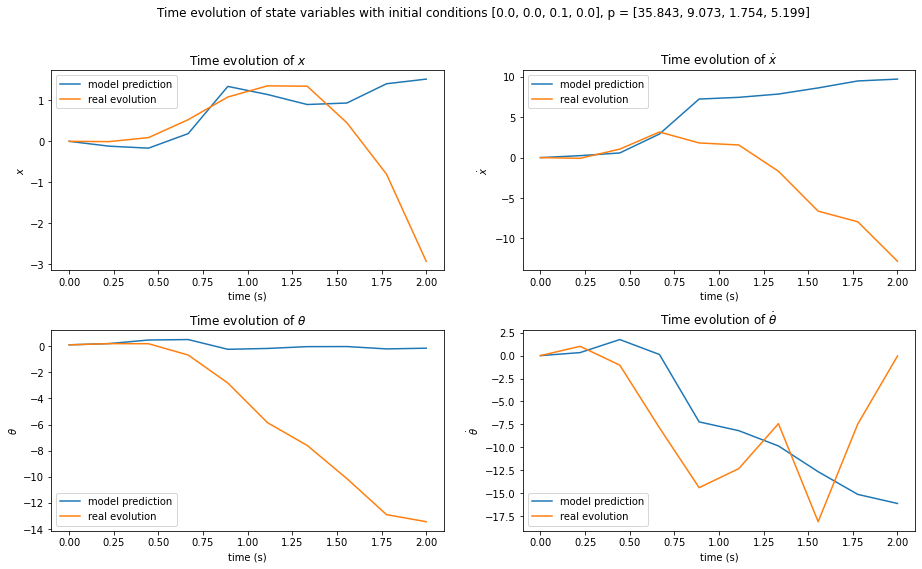

In [663]:
num_timesteps = 10
init_state = np.array([0,0,theta,0])
traj = np.array(rolloutf_model(init_state, num_timesteps, res31.x, centres312, alphas312, sigmas))
traj_real = np.array(rolloutf(init_state, num_timesteps, res31.x))
t = np.linspace(0,0.2*num_timesteps,num_timesteps)
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Time evolution of state variables with initial conditions {list(init_state)}, p = [{res31.x[0]:.3f}, {res31.x[1]:.3f}, {res31.x[2]:.3f}, {res31.x[3]:.3f}]", y=1.01)
for i in range(4):
    axs[ax[i][0],ax[i][1]].plot(t, traj[:,i],label='model prediction')
    axs[ax[i][0],ax[i][1]].plot(t, traj_real[:,i],label='real evolution')
    axs[ax[i][0],ax[i][1]].set_title(f"Time evolution of {labels[i]}")
    axs[ax[i][0],ax[i][1]].set_xlabel("time (s)")
    axs[ax[i][0],ax[i][1]].set_ylabel(labels[i])
    axs[ax[i][0],ax[i][1]].legend()
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

3.2

In [308]:
def generate_dataset_noise2(num_datapoints, m, ranges=[(-10,10), (-5,5),(-p,p),(-10,10),(-20,20)], dim=4, scales = [0.01]):
    centres = get_basis_centres(m, dim, 20)
    X_noise2 = np.zeros([num_datapoints,dim])
    Y_noise2 = np.zeros([len(scales),num_datapoints,4])
    for i, centre in enumerate(centres):
        state = centre
        for k, scale in enumerate(scales):
            noise = np.random.default_rng().normal(scale = scale)
            cp.setState(state[:4])
            if dim == 4:
                cp.performAction(noise)
            elif dim == 5:
                cp.performAction(state[4]+noise)
            new_state = cp.getState()
            change = new_state - state[:4]
            Y_noise2[k][i] = change
        X_noise2[i] = state
    for i in range(m, num_datapoints):
        if dim == 4:
            state = get_init_state(ranges[:4])
        elif dim == 5:
            state = get_init_state2(ranges)
        for k, scale in enumerate(scales):
            noise = np.random.default_rng().normal(scale = scale)
            cp.setState(state[:4])
            if dim == 4:
                cp.performAction(noise)
            elif dim == 5:
                cp.performAction(state[4]+noise)
            new_state = cp.getState()
            change = new_state - state[:4]
            Y_noise2[k][i] = change
        X_noise2[i] = state
    return X_noise2, Y_noise2, centres

In [719]:
scales = [0,0.01,0.1,1,10]

In [720]:
X_32, Y_32, centres32  = generate_dataset_noise2(5000, 400, scales=scales)

In [721]:
C2,_,_,_ = np.array(np.linalg.lstsq(X_32, Y_32[0], rcond = None))
C_0012,_,_,_ = np.array(np.linalg.lstsq(X_32, Y_32[1], rcond = None))
C_012,_,_,_ = np.array(np.linalg.lstsq(X_32, Y_32[2], rcond = None))
C_12,_,_,_ = np.array(np.linalg.lstsq(X_32, Y_32[3], rcond = None))
C_102,_,_,_ = np.array(np.linalg.lstsq(X_32, Y_32[4], rcond = None))

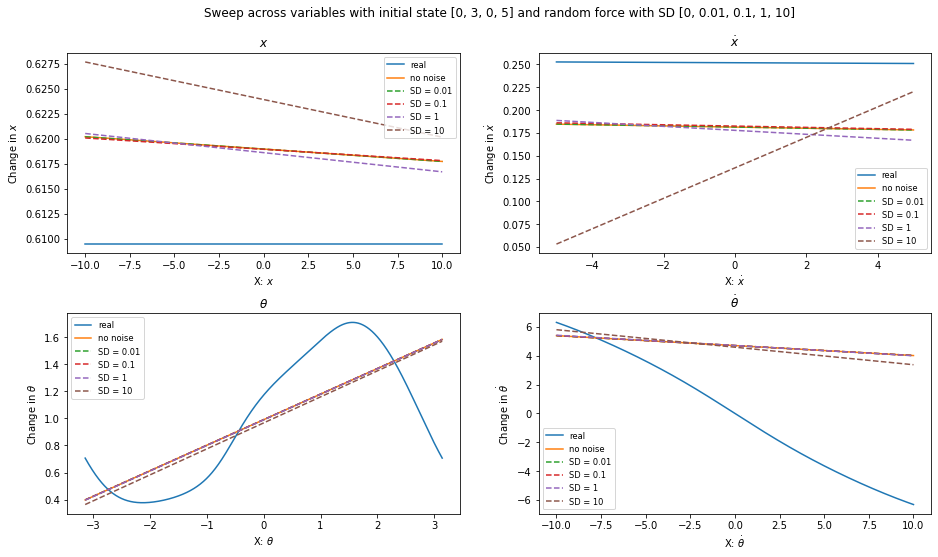

In [724]:
n = 1000
state = [0,3,0,5]
ranges = [(-10, 10),(-5, 5),(-p, p),(-10, 10)]
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
# ylims = [[0.5,1],[0,0.7],[0.3,1.8],[-7,7]]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Sweep across variables with initial state {list(state)} and random force with SD {scales}")
for k in range(4):
    lower = ranges[k][0]
    upper = ranges[k][1]
    x = np.linspace(lower, upper, n)
    y = []
    y_pred = []
    y_pred_001 = []
    y_pred_01 = []
    y_pred_1 = []
    y_pred_10 = []
    for i in range(len(x)):
        state[k] =  x[i]
        cp.setState(state)
        cp.performAction()
        new_state = cp.getState()
        y.append(new_state[k] - state[k])
        pred_state = np.dot(C2.T, state)
        pred_state_001 = np.dot(C_0012.T, state)
        pred_state_01 = np.dot(C_012.T, state)
        pred_state_1 = np.dot(C_12.T, state)
        pred_state_10 = np.dot(C_102.T, state)
        y_pred.append(pred_state[k])
        y_pred_001.append(pred_state_001[k])
        y_pred_01.append(pred_state_01[k])
        y_pred_1.append(pred_state_1[k])
        y_pred_10.append(pred_state_10[k])
    axs[ax[k][0],ax[k][1]].plot(x,y,label='real')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred,label='no noise')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred_001,label='SD = 0.01',linestyle = 'dashed')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred_01,label='SD = 0.1',linestyle = 'dashed')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred_1,label='SD = 1',linestyle = 'dashed')
    axs[ax[k][0],ax[k][1]].plot(x,y_pred_10,label='SD = 10',linestyle = 'dashed')
    # axs[ax[k][0],ax[k][1]].set_ylim(ylims[k][0],ylims[k][1])
    axs[ax[k][0],ax[k][1]].set_xlabel(f"X: {labels[k]}")
    axs[ax[k][0],ax[k][1]].set_ylabel(f"Change in {labels[k]}")
    axs[ax[k][0],ax[k][1]].set_title(f"{labels[k]}")
    axs[ax[k][0],ax[k][1]].legend(fontsize = "small")
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

non-linear noise

In [473]:
scales = [0,0.01,0.03,0.1,0.3,1,3,10]

In [474]:
X_322, Y_322, centres322  = generate_dataset_noise2(5000, 400, scales=scales)
X_test322,Y_noise_test322,_ = generate_dataset_noise2(1000,0,scales=scales)

In [478]:
train_MSE_list3 = []
test_MSE_list3 = []
sigmas = [50, 10, 4, 15]
for i, scale in enumerate(scales):
    K, Km = get_Knxm(X_322, centres322, sigmas)
    lam = scale**2
    A = np.dot(K.T, K) + lam*Km
    B = np.array([np.dot(K.T, Y_322[i,:,k]) for k in range(4)])
    B = B.T
    alphas,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
    alphas = alphas.T
    Y_pred = f2(X_322, centres322, alphas, sigmas)
    Y_pred_test = f2(X_test322, centres322, alphas, sigmas)
    train_MSE_list3.append(MSE(Y_322[0], Y_pred))
    test_MSE_list3.append(MSE(Y_noise_test322[0], Y_pred_test))

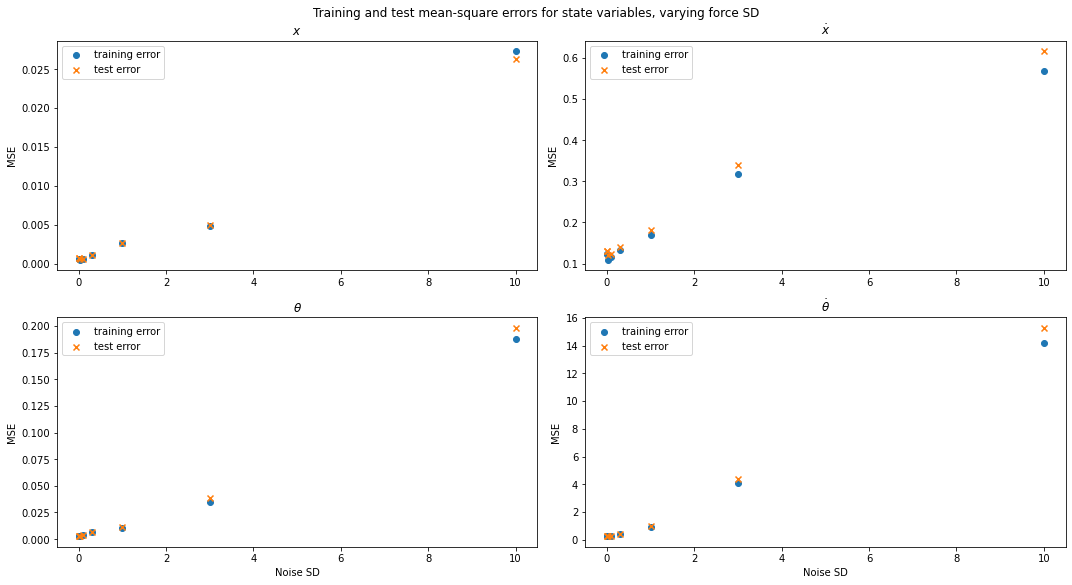

In [479]:
train_MSE_list3 = np.array(train_MSE_list3)
test_MSE_list3 = np.array(test_MSE_list3)
y1_train_MSE3, y1_test_MSE3 = train_MSE_list3[:,0], test_MSE_list3[:,0]
y2_train_MSE3, y2_test_MSE3 = train_MSE_list3[:,1], test_MSE_list3[:,1]
y3_train_MSE3, y3_test_MSE3 = train_MSE_list3[:,2], test_MSE_list3[:,2]
y4_train_MSE3, y4_test_MSE3 = train_MSE_list3[:,3], test_MSE_list3[:,3]

fig, axs = plt.subplots(2,2)

fig.suptitle("Training and test mean-square errors for state variables, varying force SD", y = 1.01)

axs[0,0].scatter(scales, y1_train_MSE3, label='training error')
axs[0,0].scatter(scales, y1_test_MSE3, label='test error', marker = 'x')
axs[0,0].set_title("$x$")
axs[0,0].set_ylabel("MSE")
# axs[0,0].semilogx(basex=2)
axs[0,0].legend()
axs[0,1].scatter(scales, y2_train_MSE3, label='training error')
axs[0,1].scatter(scales, y2_test_MSE3, label='test error', marker = 'x')
axs[0,1].set_title("$\dot{x}$")
axs[0,1].set_ylabel("MSE")
# axs[0,1].semilogx(basex=2)
axs[0,1].legend()
axs[1,0].scatter(scales, y3_train_MSE3, label='training error')
axs[1,0].scatter(scales, y3_test_MSE3, label='test error', marker = 'x')
axs[1,0].set_title(r"$\theta$")
axs[1,0].set_xlabel("Noise SD")
axs[1,0].set_ylabel("MSE")
# axs[1,0].semilogx(basex=2)
axs[1,0].legend()
axs[1,1].scatter(scales, y4_train_MSE3, label='training error')
axs[1,1].scatter(scales, y4_test_MSE3, label='test error', marker = 'x')
axs[1,1].set_title(r"$\dot{\theta}$")
axs[1,1].set_xlabel("Noise SD")
axs[1,1].set_ylabel("MSE")
# axs[1,1].semilogx(basex=2)
axs[1,1].legend()
plt.tight_layout()
plt.show()

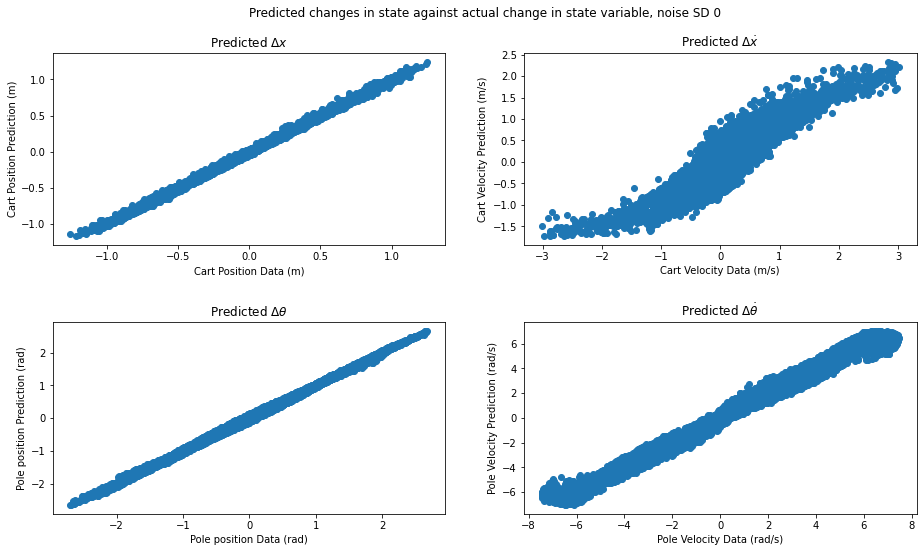

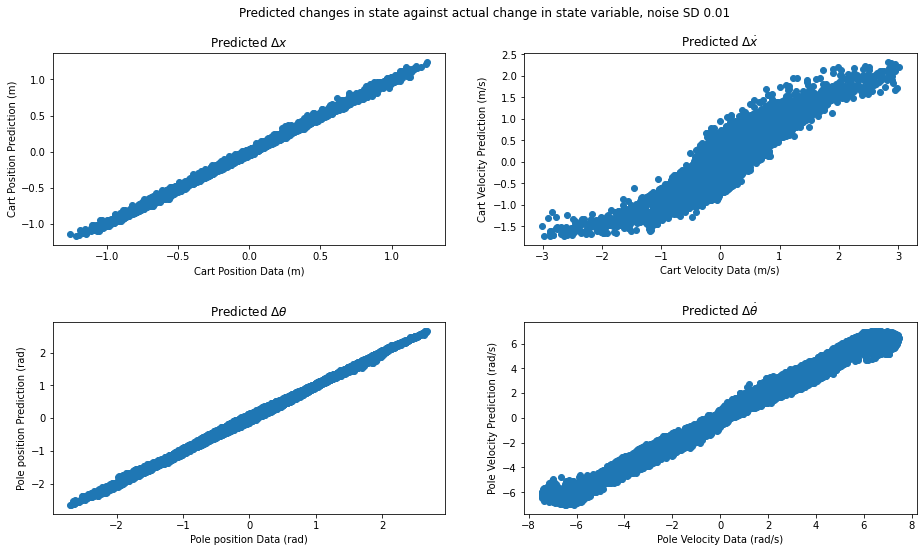

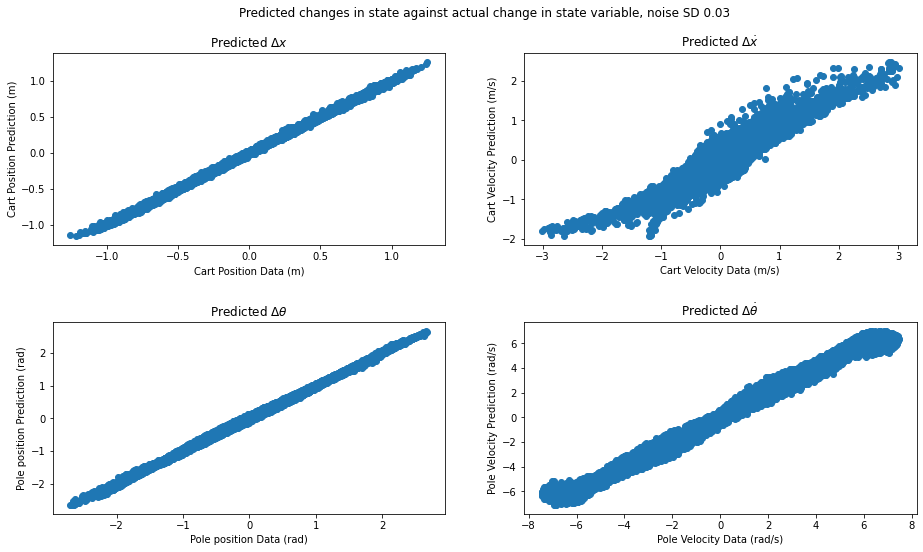

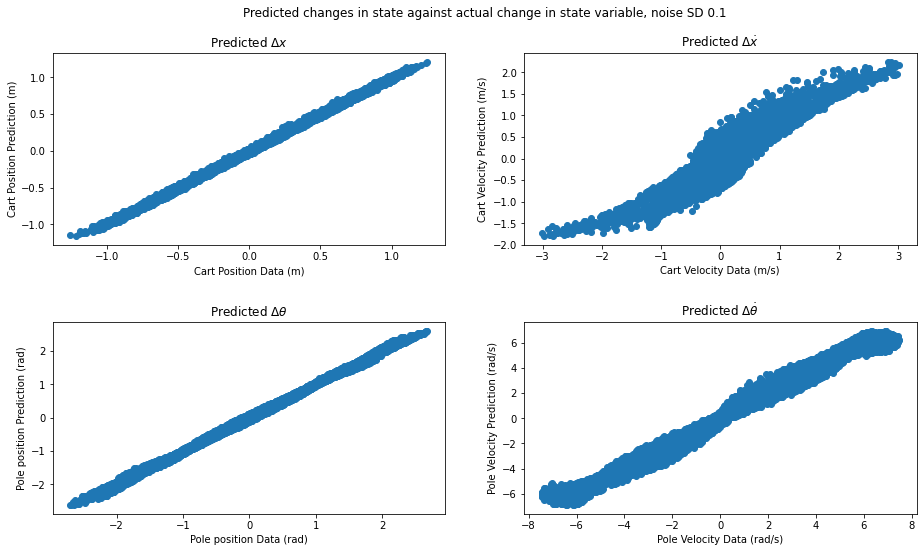

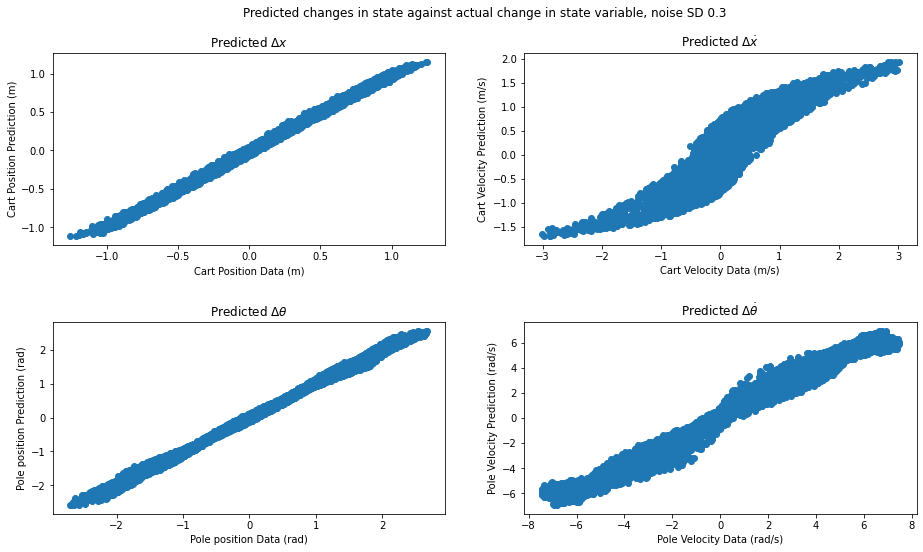

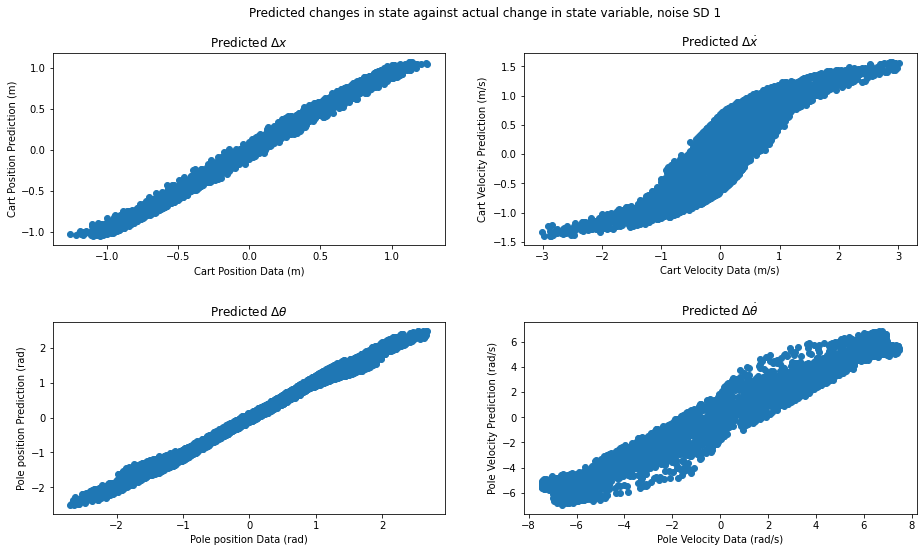

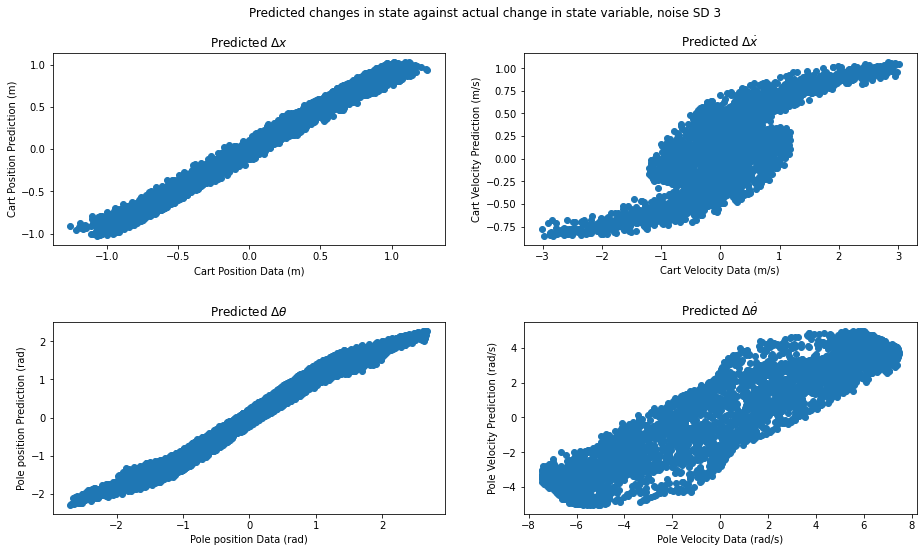

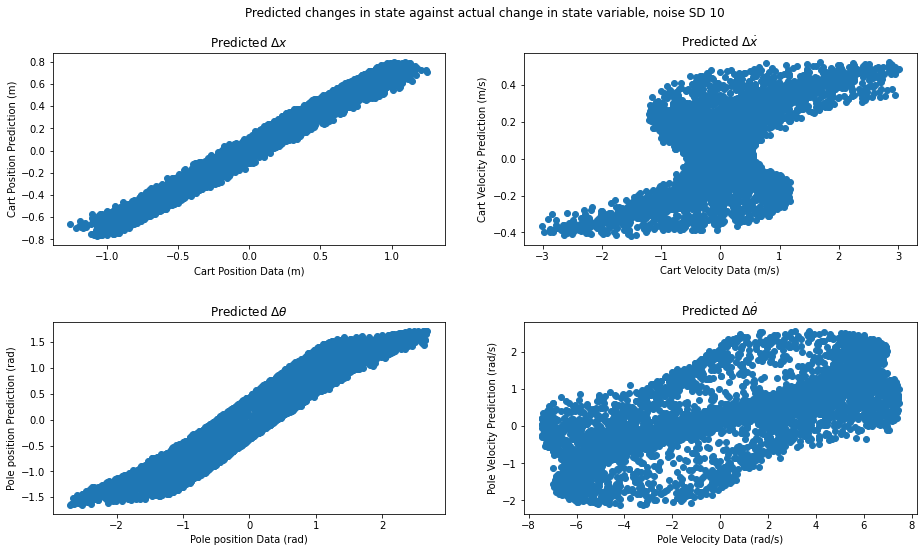

In [480]:
sigmas = [50, 10, 4, 15]
for i, scale in enumerate(scales):
    K, Km = get_Knxm(X_322, centres322, sigmas)
    lam = scale**2
    A = np.dot(K.T, K) + lam*Km
    B = np.array([np.dot(K.T, Y_322[i,:,k]) for k in range(4)])
    B = B.T
    alphas,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
    alphas = alphas.T
    Y_pred = f2(X_322, centres322, alphas, sigmas)
    # Y_pred_test = f2(X_test, centres31, alphas, sigmas)
    # train_MSE_list2.append(MSE(Y_noise[0], Y_pred))
    # test_MSE_list2.append(MSE(Y_noise_test[0], Y_pred_test))
    x1,y1 = X_322[:,0], Y_322[0,:,0]
    y1_pred = Y_pred[:,0]
    x2,y2 = X_322[:,1], Y_322[0,:,1]
    y2_pred = Y_pred[:,1]
    x3,y3 = X_322[:,2], Y_322[0,:,2]
    y3_pred = Y_pred[:,2]
    x4,y4 = X_322[:,3], Y_322[0,:,3]
    y4_pred = Y_pred[:,3]
    
    fig, axs = plt.subplots(2, 2)

    fig.suptitle(f'Predicted changes in state against actual change in state variable, force SD {scale}')
    axs[0,0].scatter(y1,y1_pred)
    axs[0,0].set_title(r"Predicted $\Delta x$")
    axs[0,0].set_xlabel("Cart Position Data (m)")
    axs[0,0].set_ylabel("Cart Position Prediction (m)")
    axs[0,1].scatter(y2,y2_pred)
    axs[0,1].set_title(r"Predicted $\Delta\dot{x}$")
    axs[0,1].set_xlabel("Cart Velocity Data (m/s)")
    axs[0,1].set_ylabel("Cart Velocity Prediction (m/s)")
    axs[1,0].scatter(y3,y3_pred)
    axs[1,0].set_title(r"Predicted $\Delta\theta$")
    axs[1,0].set_xlabel("Pole position Data (rad)")
    axs[1,0].set_ylabel("Pole position Prediction (rad)")
    axs[1,1].scatter(y4,y4_pred)
    axs[1,1].set_title(r"Predicted $\Delta\dot{\theta}$")
    axs[1,1].set_xlabel("Pole Velocity Data (rad/s)")
    axs[1,1].set_ylabel("Pole Velocity Prediction (rad/s)")
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
    plt.show()

In [664]:
scales=[0,3]

In [665]:
X_322, Y_322, centres322 = generate_dataset_noise(5000,400,dim=5, scales=scales)

In [666]:
sigmas = [10,7,2,10,20]
K, Km = get_Knxm(X_322, centres322, sigmas)
lam = scale**2
A = np.dot(K.T, K) + lam*Km
B = np.array([np.dot(K.T, Y_322[1,:,k]) for k in range(4)])
B = B.T
alphas322,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
alphas322 = alphas322.T

In [671]:
theta = 0.1
init_states = [[0,0,theta,0],[0,0,0,0],[0,0,-theta,0]]
x0 = [1,1,10,1]
res32 = minimize(rollout_loss_mult_model, x0, args=(init_states,centres322,alphas322,sigmas, 20),method='nelder-mead')

In [672]:
print(res32.x)
print(res32.fun)

[ 1.87216624  3.01321256  1.30672967 -0.23932471]
56.53887667442086


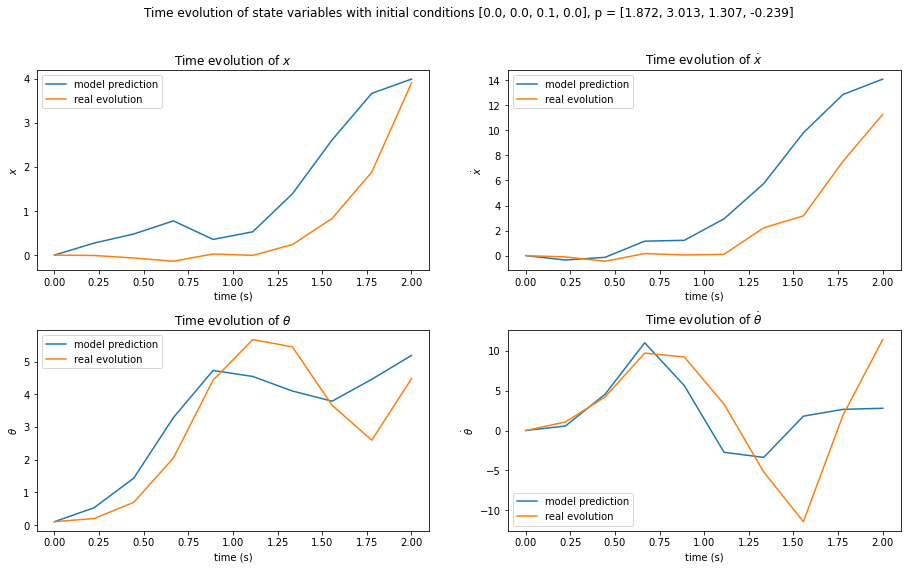

In [673]:
num_timesteps = 10
init_state = np.array([0,0,theta,0])
traj = np.array(rolloutf_model(init_state, num_timesteps, res32.x, centres322, alphas322, sigmas))
traj_real = np.array(rolloutf(init_state, num_timesteps, res32.x))
t = np.linspace(0,0.2*num_timesteps,num_timesteps)
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Time evolution of state variables with initial conditions {list(init_state)}, p = [{res32.x[0]:.3f}, {res32.x[1]:.3f}, {res32.x[2]:.3f}, {res32.x[3]:.3f}]", y=1.01)
for i in range(4):
    axs[ax[i][0],ax[i][1]].plot(t, traj[:,i],label='model prediction')
    axs[ax[i][0],ax[i][1]].plot(t, traj_real[:,i],label='real evolution')
    axs[ax[i][0],ax[i][1]].set_title(f"Time evolution of {labels[i]}")
    axs[ax[i][0],ax[i][1]].set_xlabel("time (s)")
    axs[ax[i][0],ax[i][1]].set_ylabel(labels[i])
    axs[ax[i][0],ax[i][1]].legend()
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

## Week 4: Nonlinear control


#### Task 4.1

Define a _nonlinear_ policy, using a similar construction that we used for modelling the system, but this time we are modelling 
the `force` action as a function of the system state variables (i.e. the policy). The policy function is thus

$$
p(X) = \sum_i w_i e^{-0.5 (X-X_i)^T W (X-X_i)}
$$

where the locations $X_i$, the weights $w_i$ and the elements of the $4 \times 4$ symmetrix matrix $W$ are free parameters to be optimised (how do you make sure W is symmetric?). 
Use between 5-20  basis functions. Optimise the parameters, and try to obtain a policy that can keep the pole upright starting 
from the stable equilibrium (down) position. Feel free to use special initial conditions that seem reasonable. I suggest you experiment with the noise-free version of the problem.

_Note that this task is **hard**, and you may not achieve good control. Do not invest an inordinate amount of effort, but
move onto writing your final report if you do not succeed. You do not necessarily need to have found a good nonlinear controller to 
achieve a good grade in this project_, but I will be looking for good effort and evidence that you tried a variety of ideas. 

In [246]:
def nl_loss(state, sigs=np.array([4,2,1.1,2])):
    return 1-np.exp(-np.dot(state/sigs,state/sigs)/(2.0))

In [111]:
cp.delta_time = 0.2

In [243]:
cp.setState([0,0,p,0])
cp.performAction(3)
print(cp.getState())
cp.performAction(3)
print(cp.getState())
cp.performAction(-3)
print(cp.getState())
cp.performAction(-3)
print(cp.getState())
cp.performAction(-3)
print(cp.getState())
cp.performAction(-3)
print(cp.getState())
cp.performAction(3)
print(cp.getState())
cp.performAction(3)
print(cp.getState())
cp.performAction(3)
print(cp.getState())
cp.performAction(3)
print(cp.getState())
cp.performAction(-3)
print(cp.getState())
cp.performAction(-3)
print(cp.getState())
cp.performAction(-3)
print(cp.getState())
cp.performAction(-3)
print(cp.getState())
cp.performAction(3)
print(cp.getState())
cp.performAction(3)
print(cp.getState())
cp.performAction(3)
print(cp.getState())
cp.performAction(3)
print(cp.getState())

[0.09107578 0.83656926 3.38668754 1.98565656]
[0.30726736 1.27231631 3.70459812 0.77333886]
[ 0.42789187 -0.05144154  3.22037367 -5.20820289]
[ 0.37728938 -0.25167807  2.21958959 -3.36532492]
[ 0.30601808 -0.5036106   2.04078828  1.51396926]
[ 0.19695424 -0.53375259  2.80322447  5.58063681]
[ 0.16191476 -0.23279849  4.08058011  4.88725907]
[ 0.1238367  -0.02109382  4.51104339 -0.51885431]
[ 0.143328    0.0547709   3.86011958 -5.79420899]
[ 0.17852528  0.73628378  2.61743094 -4.20940261]
[ 0.31534739  0.58540932  2.15681181 -0.23105441]
[0.40873916 0.40064682 2.54644354 3.86090717]
[ 0.44777501 -0.23674355  3.37747848  2.93074257]
[ 0.27096301 -1.50431135  3.39971186 -2.61318756]
[ 0.05131065 -0.62645001  3.05573903 -0.26684388]
[0.02791986 0.31193632 3.33303396 2.52000769]
[0.1382907  0.72133021 3.76502352 1.22084072]
[ 0.3135382   1.02549718  3.71752042 -1.59852456]


In [290]:
cp.setState([0,0,p,0])
cp.performAction(12)
print(cp.getState())
cp.performAction(12)
print(cp.getState())
cp.performAction(-12)
print(cp.getState())
cp.performAction(-8)
print(cp.getState())
cp.performAction(-8)
print(cp.getState())
cp.performAction(-6)
print(cp.getState())
cp.performAction(1.5)
print(cp.getState())
cp.performAction(0.7)
print(cp.getState())
# cp.performAction(-1.5)
# print(cp.getState())


[0.31045536 2.65790553 3.95918867 5.87105548]
[0.992337   4.28032768 4.7647256  1.51254457]
[ 1.62872474  2.04086512  4.50710057 -4.24939277]
[  1.72519495  -0.8427223    2.6631615  -13.24379174]
[ 1.67775111 -0.22980731  0.7202122  -6.63201393]
[ 1.46063652 -2.0332405   0.0982018   0.21561676]
[ 1.09025434 -1.67746068  0.09563594 -0.23424953]
[ 0.76769092 -1.54408793  0.05992402 -0.17834251]


In [247]:
def nl_policy(state, weights, W_half, basis):
    W = np.matmul(W_half.T, W_half)
    state = state[:4]
    exponent = [-0.5*np.dot((state-b), np.dot(W, (state-b))) for b in basis]
    # exponent = [0.05*np.dot((state-b), np.dot(W, (state-b))) for b in basis]
    sumlist = weights*np.exp(exponent)
    return np.sum(sumlist)

def rolloutf_nl(init_state, num_timesteps, basis, weights, W_half):
    traj = np.zeros([num_timesteps,4])
    forces = np.zeros(num_timesteps)
    cp.setState(init_state)
    for i in range(num_timesteps):
        state = cp.getState()
        traj[i] = state
        cp.setState(state)
        force = nl_policy(state, weights, W_half, basis)
        cp.performAction(force)
        forces[i] = force
    return traj, forces

def rollout_loss_nl(nl_pol, basis_length, init_state, num_timesteps):
    weights = np.append(np.array(nl_pol[:basis_length]),-np.array(nl_pol[:basis_length]))
    W_half = np.array([nl_pol[basis_length:basis_length+4],
                       nl_pol[basis_length+4:basis_length+8],
                       nl_pol[basis_length+8:basis_length+12],
                       nl_pol[basis_length+12:basis_length+16]])
    basis = np.zeros([2*basis_length,4])
    n = basis_length + 16
    for i in range(basis_length):
        basis[i] = np.array(nl_pol[n:n+4])
        n += 4
    n = basis_length + 16
    for i in range(basis_length, 2*basis_length):
        basis[i] = -np.array(nl_pol[n:n+4])
        n += 4
    init_state = np.array(init_state)
    traj1, _ = rolloutf_nl(init_state, num_timesteps, basis, weights, W_half)
    losses1 = np.zeros(len(traj1))
    for i, state in enumerate(traj1):
        losses1[i] = nl_loss(state)
    traj2, _ = rolloutf_nl(-init_state, num_timesteps, basis, weights, W_half)
    losses2 = np.zeros(len(traj2))
    for i, state in enumerate(traj2):
        losses2[i] = nl_loss(state)
    return np.sum(losses1) + np.sum(losses2) 

In [114]:
# x0 = np.array([0.35,0.35,0.3,0.3,0.25,0.25,0.2,0.2,0.15,0.15,0.1,0.1])
# W_half = np.array([[1,0.1,0.1,0.1],[0.1,0.8,0.1,0.1],[0.1,0.1,0.4,0.1],[0.1,0.1,0.1,0.4]])
# basis=np.array([[-1,-1,1.2*p,1],[1,1,-1.2*p,-1],[0,0,p,0],[0,0,-p,0],[-0.5,-2,0.8*p,1],[-0.8,-1,0.6*p,4],[-0.5,-0.5,0.4*p,4],[-0.1,-0.2,0.2*p,1],[0.5,2,-0.8*p,-1],[0.8,1,-0.6*p,-4],[0.5,0.5,-0.4*p,-4],[0.1,0.2,-0.2*p,-1]])
# init_state = [0,0,0.1,0]
# num_timesteps = 20
# # basis = [[0,0,p,0],[0.1,0.5,-5/6*p,-1],[-0.1,-0.5,5/6*p,1],[],[],[],[],[],[],[],[],[0,0,0,0]]
# print(np.matmul(W_half.T, W_half))

In [222]:
# init_state = [1.09025434,-1.67746068,0.09563594,-0.23424953]
# # init_state = [0,0,p,0]
# num_timesteps = 40
# basis_length = 12
# x0 = [10,-10,8,-8,-6,6,-4,4,-2,2,-1,1,
#         0.1,0.05,-0.05,0.05,
#         0.05,0.2,0.05,0.05,
#         0.05,0.05,0.4,0.05,
#         0.05,0.05,0.05,0.2,
#         1,1,1.2*p,1,
#         -1,-1,-1.2*p,-1,
#         -1,-1,p,1,
#         1,1,-p,-1,
#         -1,-1,0.7*p,1,
#         1,1,-0.7*p,-1,
#         -1,-1,0.4*p,1,
#         1,1,-0.4*p,-1,
#         -1,-1,0.2*p,1,
#         1,1,-0.2*p,-1,
#         -1,-1,0.1*p,1,
#         1,1,-0.1*p,-1]

In [294]:
# init_state = [1.09025434,-1.67746068,0.09563594,-0.23424953]
init_state = [0,0,p,0]
num_timesteps = 40
basis_length = 8
x0 = [12,12,-12,-8,-8,-6,1.5,0.7,
        0.1,0.05,0.05,0.05,
        0.05,0.2,0.05,0.05,
        0.05,0.05,0.4,0.05,
        0.05,0.05,0.05,0.2,
        0,0,p,0,
        0.31045536,2.65790553,3.95918867,5.87105548,
        0.992337,4.28032768,4.7647256,1.51254457,
        1.62872474,2.04086512,4.50710057,-4.24939277,
        1.72519495,-0.8427223,2.6631615,-13.24379174,
        1.67775111,-0.22980731,0.7202122,-6.63201393,
        1.46063652,-2.0332405,0.0982018,0.21561676,
        1.09025434,-1.67746068,0.09563594,-0.23424953]

In [295]:
print(nl_loss(init_state))
print(nl_loss([2,2,1,1]))

0.9830645958135873
0.6875226025232455


In [296]:
res41 = minimize(rollout_loss_nl, x0, args = (basis_length, init_state, num_timesteps), method='nelder-mead')

In [297]:
weights = np.append(np.array(res41.x[:basis_length]),-np.array(res41.x[:basis_length]))
W_half = np.array([res41.x[basis_length:basis_length+4],
                    res41.x[basis_length+4:basis_length+8],
                    res41.x[basis_length+8:basis_length+12],
                    res41.x[basis_length+12:basis_length+16]])
basis = np.zeros([2*basis_length,4])
n = basis_length + 16
for i in range(basis_length):
    basis[i] = np.array(res41.x[n:n+4])
    n += 4
n = basis_length + 16
for i in range(basis_length, 2*basis_length):
    basis[i] = -np.array(res41.x[n:n+4])
    n += 4
print("weights:\n", weights)
print("W:\n", np.matmul(W_half.T, W_half))
print("basis\n:",basis)
print(res41.fun)
print(res41.success)

weights:
 [ 11.64331042  11.38742546 -12.36429021  -8.85399954  -7.98956579
  -5.86868633   1.50143073   0.70179719 -11.64331042 -11.38742546
  12.36429021   8.85399954   7.98956579   5.86868633  -1.50143073
  -0.70179719]
W:
 [[0.01758597 0.02012464 0.0298377  0.02011635]
 [0.02012464 0.04804152 0.03515433 0.02537585]
 [0.0298377  0.03515433 0.16633876 0.03520703]
 [0.02011635 0.02537585 0.03520703 0.0492987 ]]
basis
: [[ 4.01039354e-06  4.55121333e-05  3.05129701e+00  1.71506263e-05]
 [ 3.14231520e-01  2.64680914e+00  3.94406296e+00  5.90891150e+00]
 [ 9.86302908e-01  4.20806976e+00  4.66813761e+00  1.52456404e+00]
 [ 1.62901812e+00  2.06709398e+00  4.38106360e+00 -4.25061418e+00]
 [ 1.71328661e+00 -8.51459445e-01  2.68186498e+00 -1.29634343e+01]
 [ 1.69889449e+00 -2.29962022e-01  7.30856001e-01 -6.57205475e+00]
 [ 1.45188585e+00 -2.04352805e+00  9.83443732e-02  2.17138377e-01]
 [ 1.10994149e+00 -1.68858359e+00  9.54940871e-02 -2.34011414e-01]
 [-4.01039354e-06 -4.55121333e-05 -3.051

In [298]:
# print(nl_policy([0,0,0,0], weights, W_half, basis))

In [299]:
# x0 = [-10,10,8,-8,6,-6,4,-4,2,-2,1,-1,12,-12,
#         0.1,0.05,0.05,0.05,
#         0.05,0.2,0.05,0.05,
#         0.05,0.05,0.4,0.05,
#         0.05,0.05,0.05,0.2,
#         1,1,1.2*p,1,
#         -1,-1,-1.2*p,-1,
#         -1,-1,p,1,
#         1,1,-p,-1,
#         -1,-1,0.7*p,1,
#         1,1,-0.7*p,-1,
#         -1,-1,0.4*p,1,
#         1,1,-0.4*p,-1,
#         -1,-1,0.2*p,1,
#         1,1,-0.2*p,-1,
#         -1,-1,0.1*p,1,
#         1,1,-0.1*p,-1,
#         0,0,p,0,
#         0,0,-p,0]

In [300]:
# weights = np.array(x0[:basis_length])
# W_half = np.array([x0[basis_length:basis_length+4],
#                     x0[basis_length+4:basis_length+8],
#                     x0[basis_length+8:basis_length+12],
#                     x0[basis_length+12:basis_length+16]])
# basis = np.zeros([basis_length,4])
# n = basis_length+16
# for i in range(basis_length):
#     basis[i] = np.array(x0[n:n+4])
#     n += 4

In [301]:
# print(nl_policy([0,0,0,0], weights, W_half, basis))

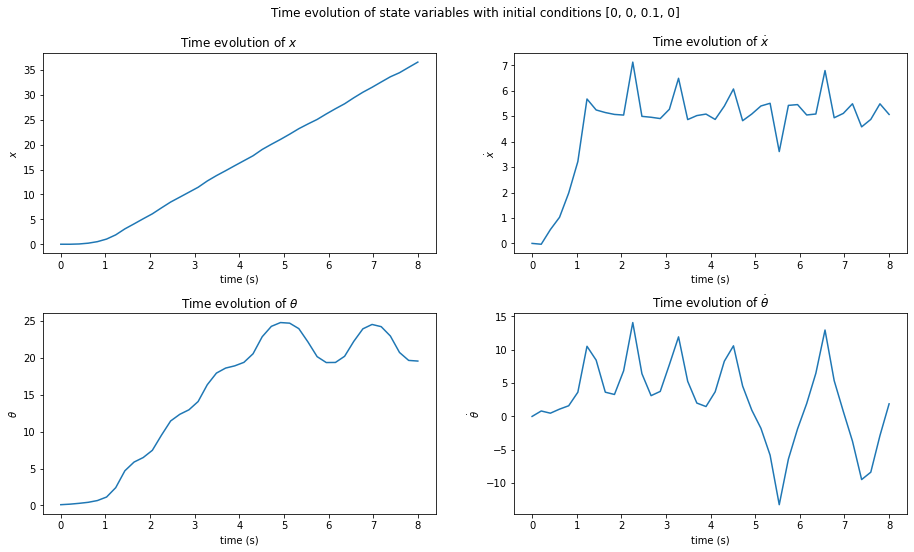

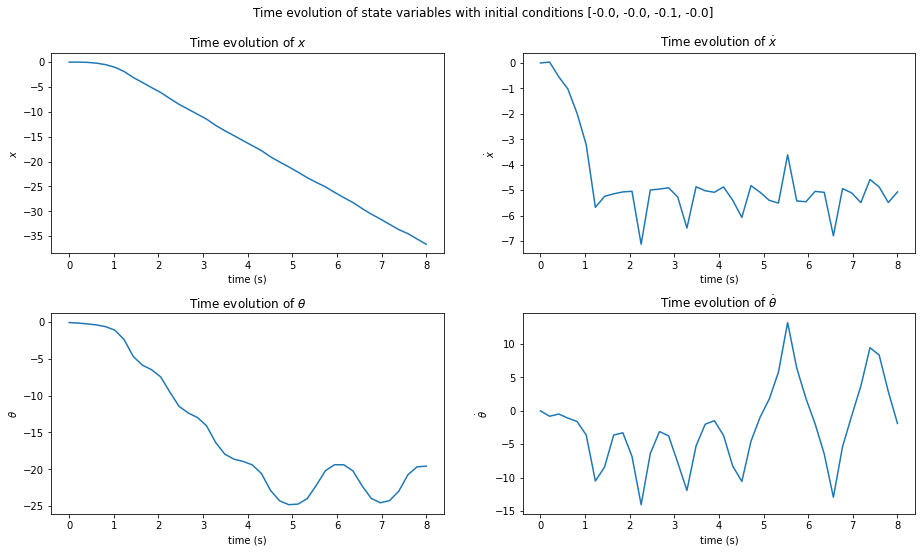

In [307]:
num_timesteps = 40
init_state = [0,0,0.1,0]
# basis=np.array([[0,0,p,0],[-0.5,-2,0.75*p,3],[-0.8,-1,0.5*p,5],[-0.5,-0.5,0.25*p,3],[0,0,0,0]])
# W_half = np.array([[0.4,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
traj, forces = rolloutf_nl(init_state, num_timesteps, basis, weights, W_half)
t = np.linspace(0,0.2*num_timesteps,num_timesteps)
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Time evolution of state variables with initial conditions {list(init_state)}")
for i in range(4):
    axs[ax[i][0],ax[i][1]].plot(t, traj[:,i])
    axs[ax[i][0],ax[i][1]].set_title(f"Time evolution of {labels[i]}")
    axs[ax[i][0],ax[i][1]].set_xlabel("time (s)")
    axs[ax[i][0],ax[i][1]].set_ylabel(labels[i])
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
traj, forces = rolloutf_nl(-np.array(init_state), num_timesteps, basis, weights, W_half)
t = np.linspace(0,0.2*num_timesteps,num_timesteps)
ax = [[0,0],[0,1],[1,0],[1,1]]
labels = ["$x$", "$\dot{x}$", r"$\theta$", r"$\dot{\theta}$"]
fig, axs = plt.subplots(2,2)
fig.suptitle(f"Time evolution of state variables with initial conditions {list(-np.array(init_state))}")
for i in range(4):
    axs[ax[i][0],ax[i][1]].plot(t, traj[:,i])
    axs[ax[i][0],ax[i][1]].set_title(f"Time evolution of {labels[i]}")
    axs[ax[i][0],ax[i][1]].set_xlabel("time (s)")
    axs[ax[i][0],ax[i][1]].set_ylabel(labels[i])
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

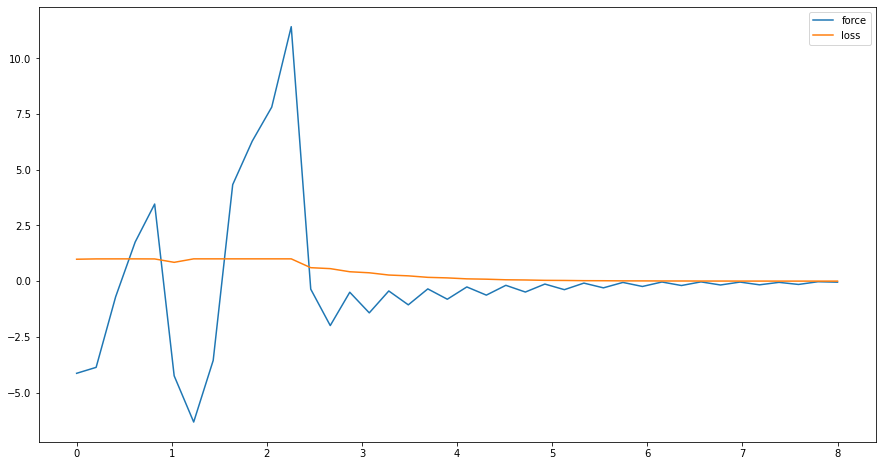

In [303]:
plt.plot(t, forces, label="force")
plt.plot(t, [nl_loss(state) for state in traj], label="loss")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=311b2eac-87ee-407e-ba93-45839f7a92e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>